# Final full idea put together



# Load Data

In [ ]:
%%writefile ml/load_and_prepare_data/load_data_and_analyze.py

import numpy as np
import pandas as pd
import json
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import shap

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


###############################################################################
# HELPER FUNCTION FOR DEBUG OUTPUTS
###############################################################################
def _print_debug_info(step_name, df, new_columns=None, debug=False):
    """
    Prints debug information about a DataFrame after a processing step.
    
    When debug=True, prints:
      - The step name.
      - The DataFrame shape.
      - If new_columns is provided (a list of column names), prints for each:
          • Data type and a sample of unique values (up to 5).
    When debug=False, prints a single-line message indicating step completion.
    """
    if debug:
        logging.info(f"Step [{step_name}]: DataFrame shape = {df.shape}")
        if new_columns:
            logging.info(f"New columns added: {new_columns}")
            for col in new_columns:
                sample = df[col].dropna().unique()[:5]
                logging.info(f" - {col}: dtype={df[col].dtype}, sample values={sample}")
    else:
        logging.info(f"Step [{step_name}] completed.")


###############################################################################
# FUNCTION DEFINITIONS
###############################################################################
def load_data(csv_path, json_path, participant_id='P0001', debug=False):
    """
    Loads the main dataset and participant information, then merges them.
    
    Parameters:
      - csv_path (str): Path to the main CSV file.
      - json_path (str): Path to the participant information JSON file.
      - participant_id (str): Participant identifier.
      - debug (bool): If True, prints detailed debug info.
    
    Returns:
      - data (pd.DataFrame): Merged DataFrame.
    """
    try:
        data = pd.read_csv(csv_path)
        logging.info(f"Loaded data from {csv_path} with shape {data.shape}")
    except FileNotFoundError:
        logging.error(f"File not found: {csv_path}")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Error loading {csv_path}: {e}")
        sys.exit(1)
    
    data['participant_id'] = participant_id
    logging.info(f"Added 'participant_id' column with value '{participant_id}'")
    
    try:
        with open(json_path, 'r') as file:
            participant_info = json.load(file)
        participant_df = pd.DataFrame([participant_info])
        logging.info(f"Loaded participant information from {json_path}")
    except FileNotFoundError:
        logging.error(f"File not found: {json_path}")
        sys.exit(1)
    except json.JSONDecodeError:
        logging.error(f"Invalid JSON format in {json_path}")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Error loading {json_path}: {e}")
        sys.exit(1)
    
    data = pd.merge(data, participant_df, on='participant_id', how='left')
    logging.info(f"Merged participant data. New shape: {data.shape}")
    _print_debug_info("load_data", data, debug=debug)
    
    # remove these columns
    data = data.drop(columns=['event_idx_leg', 'event_idx_elbow', 'event_idx_release', 'event_idx_wrist'])
    # filter out null shooting_phases
    if 'shooting_phases' in data.columns:
        data = data[data['shooting_phases'].notnull()]

    return data



def calculate_joint_angles(df, connections, debug=False):
    """
    Calculates joint angles from coordinate data using vector mathematics.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing joint coordinates.
        connections (list): Joint connections defining biomechanical segments.
        debug (bool): Enable debug logging.
        
    Returns:
        df (pd.DataFrame): Updated DataFrame with new angle columns.
    """
    angle_columns = []
    
    # Define angle calculation points for key joints
    # Note: The new "KNEE" definition uses hip, knee, and ankle as the points.
    angle_definitions = {
        'SHOULDER': {
            'left': ['L_HIP', 'L_SHOULDER', 'L_ELBOW'],
            'right': ['R_HIP', 'R_SHOULDER', 'R_ELBOW']
        },
        'HIP': {
            'left': ['L_SHOULDER', 'L_HIP', 'L_KNEE'],
            'right': ['R_SHOULDER', 'R_HIP', 'R_KNEE']
        },
        'KNEE': {
            'left': ['L_HIP', 'L_KNEE', 'L_ANKLE'],
            'right': ['R_HIP', 'R_KNEE', 'R_ANKLE']
        },
        'ANKLE': {
            'left': ['L_KNEE', 'L_ANKLE', 'L_5THTOE'],
            'right': ['R_KNEE', 'R_ANKLE', 'R_5THTOE']
        }
    }

    for joint, sides in angle_definitions.items():
        for side in ['left', 'right']:
            points = sides[side]
            prefix = 'L' if side == 'left' else 'R'
            
            # Build list of required coordinate columns for this calculation
            required_cols = []
            for point in points:
                required_cols += [f'{point}_x', f'{point}_y', f'{point}_z']
                
            if all(col in df.columns for col in required_cols):
                # Calculate the vectors needed for the angle
                vec1 = df[[f'{points[0]}_x', f'{points[0]}_y', f'{points[0]}_z']].values - \
                       df[[f'{points[1]}_x', f'{points[1]}_y', f'{points[1]}_z']].values
                vec2 = df[[f'{points[2]}_x', f'{points[2]}_y', f'{points[2]}_z']].values - \
                       df[[f'{points[1]}_x', f'{points[1]}_y', f'{points[1]}_z']].values

                # Compute the dot product and the norms of the vectors
                dot_product = np.sum(vec1 * vec2, axis=1)
                norm_product = np.linalg.norm(vec1, axis=1) * np.linalg.norm(vec2, axis=1)
                
                # Compute the angle (in degrees) and add a small epsilon to avoid division by zero
                angles = np.degrees(np.arccos(dot_product / (norm_product + 1e-8)))
                
                col_name = f'{prefix}_{joint}_angle'
                df[col_name] = angles
                angle_columns.append(col_name)
                
                if debug:
                    logging.info(f"Calculated {col_name} with mean: {angles.mean():.2f}°")
            else:
                logging.warning(f"Missing coordinates for {prefix}_{joint} angle calculation")

    _print_debug_info("calculate_joint_angles", df, new_columns=angle_columns, debug=debug)
    return df



def prepare_joint_features(data, debug=False, group_trial=False, group_shot_phase=False):
    """
    Aggregates joint-level energy and power, creates additional biomechanical features,
    and adds new features:
      - energy_acceleration: instantaneous rate of change of joint_energy.
      - ankle_power_ratio: ratio of left to right ankle ongoing power.
      - Additional asymmetry metrics.
      - Power ratios for all joint pairs.
      - Side-Specific Range-of-Motion (ROM) metrics (ROM, deviation, and binary extreme flag).
      - Removal of the wrist_angle_release column if present.
      
    NEW GROUPING FEATURE (optional):
      - If group_trial is True, computes aggregated trial-level features (e.g., trial mean exhaustion and total joint energy)
        and merges them into the DataFrame.
      - If group_shot_phase is True, and if the column 'shooting_phases' exists, computes shot-phase level aggregates
        (based on both 'trial_id' and 'shooting_phases') and merges them in.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints detailed debug outputs.
      - group_trial (bool): If True, add trial-level aggregated features.
      - group_shot_phase (bool): If True, add shot-phase-level aggregated features.
    
    Returns:
      - data (pd.DataFrame): Updated DataFrame with new features and, optionally, grouping-based extra columns.
    """
    step = "prepare_joint_features"
    new_cols = []
    connections = [
        ("R_EYE", "L_EYE"), ("R_EYE", "NOSE"), ("L_EYE", "NOSE"),
        ("R_EYE", "R_EAR"), ("L_EYE", "L_EAR"), ("R_SHOULDER", "L_SHOULDER"),
        ("R_SHOULDER", "R_ELBOW"), ("L_SHOULDER", "L_ELBOW"), ("R_ELBOW", "R_WRIST"),
        ("L_ELBOW", "L_WRIST"), ("R_SHOULDER", "R_HIP"), ("L_SHOULDER", "L_HIP"),
        ("R_HIP", "L_HIP"), ("R_HIP", "R_KNEE"), ("L_HIP", "L_KNEE"),
        ("R_KNEE", "R_ANKLE"), ("L_KNEE", "L_ANKLE"), ("R_WRIST", "R_1STFINGER"),
        ("R_WRIST", "R_5THFINGER"), ("L_WRIST", "L_1STFINGER"), ("L_WRIST", "L_5THFINGER"),
        ("R_ANKLE", "R_1STTOE"), ("R_ANKLE", "R_5THTOE"), ("L_ANKLE", "L_1STTOE"),
        ("L_ANKLE", "L_5THTOE"), ("R_ANKLE", "R_CALC"), ("L_ANKLE", "L_CALC"),
        ("R_1STTOE", "R_5THTOE"), ("L_1STTOE", "L_5THTOE"), ("R_1STTOE", "R_CALC"),
        ("L_1STTOE", "L_CALC"), ("R_5THTOE", "R_CALC"), ("L_5THTOE", "L_CALC"),
        ("R_1STFINGER", "R_5THFINGER"), ("L_1STFINGER", "L_5THFINGER")
    ]
    # Compute joint angles first.
    data = calculate_joint_angles(data, connections, debug=debug)
    # Example: Assume a base datetime for when the recording started.
    base_datetime = pd.Timestamp('2025-01-01 00:00:00')

    # Determine the unit of continuous_frame_time:
    # If continuous_frame_time is in milliseconds, then:
    data['datetime'] = base_datetime + pd.to_timedelta(data['continuous_frame_time'], unit='ms')

    # Rename participant anthropometrics if available.
    if 'height_in_meters' in data.columns and 'weight__in_kg' in data.columns:
        data['player_height_in_meters'] = data['height_in_meters']
        data['player_weight__in_kg'] = data['weight__in_kg']
        data.drop(['height_in_meters', 'weight__in_kg'], axis=1, inplace=True, errors='ignore')
        new_cols.extend(['player_height_in_meters', 'player_weight__in_kg'])
        logging.info("Renamed participant anthropometrics.")
    else:
        logging.warning("Participant anthropometric columns not found during renaming.")

    # Identify joint energy and power columns.
    joint_energy_columns = [col for col in data.columns if '_energy' in col and not ('by_trial' in col or 'overall' in col)]
    print("Joint energy columns: ", joint_energy_columns)
    joint_power_columns = [col for col in data.columns if '_ongoing_power' in col]
    print("Joint power columns: ", joint_power_columns)
    print("All angle columns: ", [col for col in data.columns if 'angle' in col])
    logging.info(f"Identified {len(joint_energy_columns)} joint energy and {len(joint_power_columns)} joint power columns.")
    if not joint_energy_columns:
        logging.error("No joint energy columns found. Check naming conventions.")
        sys.exit(1)
    if not joint_power_columns:
        logging.error("No joint power columns found. Check naming conventions.")
        sys.exit(1)
    
    # Create aggregated columns.
    data['joint_energy'] = data[joint_energy_columns].sum(axis=1)
    data['joint_power'] = data[joint_power_columns].sum(axis=1)
    new_cols.extend(['joint_energy', 'joint_power'])
    logging.info("Created aggregated 'joint_energy' and 'joint_power'.")

    # --- NEW FEATURE: Energy Acceleration ---
    if 'continuous_frame_time' in data.columns:
        time_diff = data['continuous_frame_time'].diff().replace(0, 1e-6)  # Avoid division by zero
        data['energy_acceleration'] = data['joint_energy'].diff() / time_diff
        data['energy_acceleration'] = data['energy_acceleration'].replace([np.inf, -np.inf], np.nan)
        new_cols.append('energy_acceleration')
        logging.info("Created 'energy_acceleration' as derivative of joint_energy over time.")
    else:
        logging.error("Missing 'continuous_frame_time' for energy_acceleration calculation.")
        sys.exit(1)
    
    # --- NEW FEATURE: Ankle Power Ratio ---
    if 'L_ANKLE_ongoing_power' in data.columns and 'R_ANKLE_ongoing_power' in data.columns:
        data['ankle_power_ratio'] = data['L_ANKLE_ongoing_power'] / (data['R_ANKLE_ongoing_power'] + 1e-6)
        new_cols.append('ankle_power_ratio')
        logging.info("Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.")
    else:
        logging.warning("Ankle ongoing power columns not found; 'ankle_power_ratio' not created.")

    # --- NEW FEATURES: Additional Asymmetry Metrics ---
    additional_asymmetry_joints = ['hip', 'ankle', 'wrist', 'elbow', 'knee', '1stfinger', '5thfinger']
    for joint in additional_asymmetry_joints:
        left_col = f"L_{joint.upper()}_energy"
        right_col = f"R_{joint.upper()}_energy"
        if left_col in data.columns and right_col in data.columns:
            col_name = f"{joint}_asymmetry"
            data[col_name] = np.abs(data[left_col] - data[right_col])
            new_cols.append(col_name)
            logging.info(f"Created asymmetry feature: {col_name}")
        else:
            logging.warning(f"Columns {left_col} and/or {right_col} not found; skipping {joint}_asymmetry.")

    # --- NEW FEATURES: Power Ratios for All Joints ---
    joints_for_power_ratio = additional_asymmetry_joints.copy()
    if 'knee' not in joints_for_power_ratio:
        joints_for_power_ratio.append('knee')
    for joint in joints_for_power_ratio:
        if joint == 'foot':
            left_col = 'left_foot_power'
            right_col = 'right_foot_power'
        else:
            left_col = f"L_{joint.upper()}_ongoing_power"
            right_col = f"R_{joint.upper()}_ongoing_power"
        logging.debug(f"Expecting power columns: {left_col} and {right_col}")
        if left_col in data.columns and right_col in data.columns:
            ratio_col = f"{joint}_power_ratio"
            data[ratio_col] = data[left_col] / (data[right_col] + 1e-6)
            new_cols.append(ratio_col)
            logging.info(f"Created power ratio feature: {ratio_col} using columns {left_col} and {right_col}")
        else:
            logging.warning(f"Columns {left_col} and/or {right_col} not found; skipping {joint}_power_ratio.")

    # --- NEW FEATURES: Side-Specific Range-of-Motion (ROM) Metrics ---
    rom_joints = {
        'KNEE': {'min': 120, 'max': 135},
        'SHOULDER': {'min': 0,  'max': 150},
        'HIP': {'min': 0,  'max': 120},
        'ANKLE': {'min': 0,  'max': 20},
        'WRIST': {'min': 0,  'max': 80}
    }
    for joint, thresholds in rom_joints.items():
        for side in ['L', 'R']:
            angle_col = f"{side}_{joint}_angle"
            if angle_col in data.columns:
                rom_col = f"{side}_{joint}_ROM"
                data[rom_col] = data.groupby('trial_id')[angle_col].transform(lambda x: x.max() - x.min())
                new_cols.append(rom_col)
                logging.info(f"Computed ROM for {side} {joint} as {rom_col}")

                deviation_col = f"{side}_{joint}_ROM_deviation"
                normal_min = thresholds['min']
                normal_max = thresholds['max']
                data[deviation_col] = np.maximum(0, normal_min - data[rom_col]) + np.maximum(0, data[rom_col] - normal_max)
                new_cols.append(deviation_col)
                logging.info(f"Computed ROM deviation for {side} {joint} as {deviation_col}")

                extreme_col = f"{side}_{joint}_ROM_extreme"
                data[extreme_col] = ((data[rom_col] < normal_min) | (data[rom_col] > normal_max)).astype(int)
                new_cols.append(extreme_col)
                logging.info(f"Created binary flag for {side} {joint} ROM extremes: {extreme_col}")
            else:
                logging.info(f"Angle column '{angle_col}' not found; skipping ROM metrics for {side} {joint}.")

    # --- Removal of Non-Contributing Features ---
    if 'wrist_angle_release' in data.columns:
        data.drop(columns=['wrist_angle_release'], inplace=True)
        logging.info("Dropped 'wrist_angle_release' column as it is not helpful for the model.")
    
    # --- Sort Data ---
    if 'continuous_frame_time' in data.columns and 'participant_id' in data.columns:
        data.sort_values(by=['participant_id', 'continuous_frame_time'], inplace=True)
        data.reset_index(drop=True, inplace=True)
        logging.info("Sorted data by 'participant_id' and 'continuous_frame_time'.")
    else:
        logging.error("Missing required columns for sorting ('participant_id', 'continuous_frame_time').")
        sys.exit(1)

    # --- Create Exhaustion Rate ---
    if 'by_trial_exhaustion_score' in data.columns and 'by_trial_time' in data.columns:
        data['exhaustion_rate'] = data['by_trial_exhaustion_score'].diff() / data['by_trial_time'].diff()
        print("print all the columns with by_trial_exhaustion_score: ", [col for col in data.columns if 'by_trial_exhaustion_score' in col])
        new_cols.append('exhaustion_rate')
        logging.info("Created 'exhaustion_rate' feature.")
    else:
        logging.error("Missing columns for 'exhaustion_rate' calculation.")
        sys.exit(1)
    
    # --- Create Simulated Heart Rate ---
    if 'by_trial_exhaustion_score' in data.columns and 'joint_energy' in data.columns:
        data['simulated_HR'] = 60 + (data['by_trial_exhaustion_score'] * 1.5) + (data['joint_energy'] * 0.3)
        new_cols.append('simulated_HR')
        logging.info("Created 'simulated_HR' feature.")
    else:
        logging.error("Missing columns for 'simulated_HR' calculation.")
        sys.exit(1)
    
    # ----- NEW: Add Grouping-Based Aggregation Features -----
    # Trial-level aggregations
    if group_trial:
        # For example, compute the trial mean exhaustion score and trial total joint energy.
        trial_aggs = data.groupby('trial_id').agg({
            'by_trial_exhaustion_score': 'mean',
            'joint_energy': 'sum'
        }).rename(columns={
            'by_trial_exhaustion_score': 'trial_mean_exhaustion',
            'joint_energy': 'trial_total_joint_energy'
        }).reset_index()
        data = data.merge(trial_aggs, on='trial_id', how='left')
        new_cols.extend(['trial_mean_exhaustion', 'trial_total_joint_energy'])
        logging.info("Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.")

    # Shot-phase-level aggregations (requires shooting_phases column)
    if group_shot_phase:
        if 'shooting_phases' in data.columns:
            shot_aggs = data.groupby(['trial_id', 'shooting_phases']).agg({
                'by_trial_exhaustion_score': 'mean',
                'joint_energy': 'sum'
            }).rename(columns={
                'by_trial_exhaustion_score': 'shot_phase_mean_exhaustion',
                'joint_energy': 'shot_phase_total_joint_energy'
            }).reset_index()
            data = data.merge(shot_aggs, on=['trial_id', 'shooting_phases'], how='left')
            new_cols.extend(['shot_phase_mean_exhaustion', 'shot_phase_total_joint_energy'])
            logging.info("Added shot-phase-level aggregated features: shot_phase_mean_exhaustion, shot_phase_total_joint_energy.")
        else:
            logging.warning("Column 'shooting_phases' not found; skipping shot-phase aggregation features.")
    

    
    _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    return data



def summarize_data(data, groupby_cols, lag_columns=None, rolling_window=3, 
                   agg_columns=None, phase_list=None, global_lag=False, debug=False):
    """
    Summarize the dataset with advanced feature engineering by grouping on specified columns.
    
    This function computes:
      - The mean of selected numeric columns (except for 'injury_risk', which is aggregated using max).
      - The standard deviation of these columns (with a '_std' suffix).
      - The count of records in each group.
      - A computed duration (e.g., frame_count * 0.33 seconds if applicable).
    
    Additionally, for the columns specified in lag_columns, it computes:
      - A lag feature.
      - A delta feature (current value minus the lag).
      - A rolling average (using the specified rolling window).
    
    If a phase_list is provided and 'shooting_phases' is in groupby_cols,
    the function forces the final DataFrame to include all combinations of trial_id and
    the specified phases (Cartesian product).
    
    Parameters:
        global_lag (bool): If True, lag is computed over the entire DataFrame (across all trials);
                           if False, lag is computed within groups defined by the last groupby column.
    
    Returns:
        pd.DataFrame: Aggregated DataFrame with additional lag features.
    """
    import pandas as pd
    import numpy as np

    # 1) Set default aggregation and lag columns if not provided.
    default_agg_columns = [
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy',
        'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy',
        'L_HIP_energy', 'R_HIP_energy',
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power',
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        'L_KNEE_angle', 'R_KNEE_angle',
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    default_lag_columns = [
        'joint_energy', 'joint_power',
        'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'elbow_asymmetry', 'wrist_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'simulated_HR'
    ]
    if agg_columns is None:
        agg_columns = default_agg_columns.copy()
    if lag_columns is None:
        lag_columns = default_lag_columns.copy()

    if debug:
        print("\n--- DEBUG: summarize_data START ---")
        print(f"Initial data shape: {data.shape}")
        print(f"Grouping by: {groupby_cols}")
        print(f"Aggregation columns: {agg_columns}")
        print(f"Lag columns: {lag_columns}")
        print(f"Rolling window: {rolling_window}")
        print(f"Global lag: {global_lag}")
        if phase_list is not None:
            print(f"Forced phase list: {phase_list}")
        else:
            print("No forced phase list provided.")

    # 2) Build aggregation dictionary.
    # Use 'mean' for all columns by default, but for 'injury_risk' use 'max' to force binary outcome.
    agg_dict = {col: 'mean' for col in agg_columns}
    if 'injury_risk' in agg_columns:
        agg_dict['injury_risk'] = 'max'
    
    # 3) Group by the specified columns and compute aggregates.
    grouped = data.groupby(groupby_cols)
    mean_df = grouped.agg(agg_dict).reset_index()
    std_df = grouped[agg_columns].std(ddof=0).reset_index()
    count_df = grouped.size().reset_index(name='frame_count')

    # 4) Merge aggregates.
    summary = pd.merge(mean_df, std_df, on=groupby_cols, suffixes=("", "_std"))
    summary = pd.merge(summary, count_df, on=groupby_cols)

    # 5) Compute duration metric.
    if 'frame_count' in summary.columns:
        summary['phase_duration'] = summary['frame_count'] * 0.33

    # 6) Sort the summary by the grouping columns.
    summary = summary.sort_values(groupby_cols)

    # 7) Compute lag, delta, and rolling average features.
    for col in lag_columns:
        if col in summary.columns:
            if global_lag:
                summary[f"{col}_lag1"] = summary[col].shift(1)
                summary[f"{col}_rolling_avg"] = summary[col].rolling(window=rolling_window, min_periods=1).mean()
            else:
                group_key = groupby_cols[-1]
                summary[f"{col}_lag1"] = summary.groupby(group_key)[col].shift(1)
                summary[f"{col}_rolling_avg"] = (
                    summary.groupby(group_key)[col]
                    .rolling(window=rolling_window, min_periods=1)
                    .mean()
                    .reset_index(level=0, drop=True)
                )
            summary[f"{col}_delta"] = summary[col] - summary[f"{col}_lag1"]
            if debug:
                print(f"\nComputed lag features for '{col}' with global_lag={global_lag}")

    # 8) Impute NaN values in lag and delta columns.
    lag_feature_cols = []
    for col in lag_columns:
        for suffix in ['_lag1', '_delta']:
            new_col = f"{col}{suffix}"
            if new_col in summary.columns:
                lag_feature_cols.append(new_col)
    for lag_col in lag_feature_cols:
        overall_mean = summary[lag_col].mean(skipna=True)
        summary[lag_col] = summary[lag_col].fillna(overall_mean)
        if debug:
            nan_count = summary[lag_col].isna().sum()
            print(f"Imputed {nan_count} NaN(s) in column '{lag_col}' with overall mean {overall_mean:.4f}")

    # 9) Handle forced phase list for shot phase data.
    if phase_list is not None and 'shooting_phases' in groupby_cols:
        trial_ids = data['trial_id'].unique()
        phase_list = np.array(phase_list)
        all_combinations = pd.MultiIndex.from_product([trial_ids, phase_list],
                                                        names=['trial_id', 'shooting_phases']).to_frame(index=False)
        summary = pd.merge(all_combinations, summary, on=['trial_id', 'shooting_phases'], how='left')
        summary = summary[summary['shooting_phases'].notnull()]

    # 10) Final sort and re-index.
    summary = summary.sort_values(groupby_cols).reset_index(drop=True)
    if debug:
        print(f"\n--- Final debug: summary at end of function ---")
        print("Final summary shape:", summary.shape)
        print("Final summary columns:", summary.columns.tolist())
        print("Sample final summary rows:\n", summary.head(10))
        print("--- DEBUG: summarize_data END ---\n")

    return summary



def add_datetime_column(data, 
                        base_datetime=pd.Timestamp('2025-01-01 00:00:00'),
                        break_seconds=10,
                        trial_id_col='trial_id',
                        freq='33ms'):
    """
    Generates a new timestamp column for the data such that within each trial the timestamps are evenly spaced
    with the specified frequency, and a fixed break (in seconds) is added between trials.
    
    Parameters:
      data (pd.DataFrame): DataFrame containing at least the trial identifier column.
      base_datetime (pd.Timestamp): The starting datetime reference.
      break_seconds (int): Number of seconds to insert as a break between trials.
      trial_id_col (str): The column in the DataFrame that identifies trials.
      freq (str): Frequency string (compatible with pd.date_range) for timestamps within each trial.
    
    Returns:
      pd.DataFrame: The original DataFrame with a new 'timestamp' column that contains evenly spaced timestamps 
                    for each trial and includes the specified break between trials.
    """
    # Get sorted unique trial identifiers. Zero-padded trial IDs sort lexicographically.
    unique_trials = sorted(data[trial_id_col].unique())
    
    # List to hold timestamp ranges for each trial.
    timestamp_list = []
    
    # Initialize the current trial start.
    current_time = base_datetime
    
    # Process each trial individually.
    for trial in unique_trials:
        # Select the rows for this trial.
        trial_mask = data[trial_id_col] == trial
        trial_data = data[trial_mask]
        n = len(trial_data)
        
        # Generate a date_range for this trial with n periods at the specified frequency.
        trial_timestamps = pd.date_range(start=current_time, periods=n, freq=freq)
        timestamp_list.append(trial_timestamps)
        
        # Set the start time for the next trial:
        # current_time becomes the last timestamp of this trial plus the fixed break.
        current_time = trial_timestamps[-1] + pd.Timedelta(seconds=break_seconds) + pd.Timedelta(milliseconds=33)
    
    # Construct a single timestamp Series aligned with the original data.
    timestamps = pd.Series(index=data.index, dtype='datetime64[ns]')
    for trial, trial_timestamps in zip(unique_trials, timestamp_list):
        indices = data.index[data[trial_id_col] == trial]
        timestamps.loc[indices] = trial_timestamps
        

    data = data.copy()
    data['timestamp'] = timestamps
    # Set the 'datetime' column as index, then force a uniform frequency.
    # After setting the index and applying asfreq:
    # data = data.set_index('timestamp')
    return data



def feature_engineering(data, window_size=5, debug=False, group_trial=False, group_shot_phase=False):
    """Optimized feature engineering with vectorized operations.
    
    NEW GROUPING FEATURE (optional):
      - If group_trial is True, adds trial-level aggregated features (mean exhaustion and injury rate).
      - If group_shot_phase is True, and if 'shooting_phases' exists, adds shot-phase-level aggregated features.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - window_size (int): Window size for some rolling computations.
      - debug (bool): If True, prints detailed debug outputs.
      - group_trial (bool): If True, add trial-level aggregated features.
      - group_shot_phase (bool): If True, add shot-phase-level aggregated features.
    
    Returns:
      - data (pd.DataFrame): Updated DataFrame with engineered features and optional grouping-based columns.
    """
    step = "feature_engineering"
    new_cols = []
    rolling_window = 20
    required_columns = {
        'base': ['by_trial_exhaustion_score', 'joint_power', 'simulated_HR', 'continuous_frame_time'],
        'joints': ['by_trial_time']
    }
    
    # Validate required columns
    missing = [col for col in required_columns['base'] if col not in data.columns]
    if missing:
        logging.error(f"Missing required columns: {missing}")
        sys.exit(1)

    # Vectorized temporal features
    data['time_since_start'] = data['continuous_frame_time'] - data['continuous_frame_time'].min()
    new_cols.append('time_since_start')
    
    # Fill ball-related columns with 0 when not in play
    ball_cols = ['ball_speed', 'ball_velocity_x', 'ball_velocity_y', 'ball_velocity_z']
    data[ball_cols] = data[ball_cols].fillna(0)

    # For motion columns, forward-fill missing values
    motion_cols = ['dx', 'dy', 'dz']
    data[motion_cols] = data[motion_cols].ffill().fillna(0)


    # Rolling features
    roll_config = {
        'power_avg_5': ('joint_power', 'mean'),
        'rolling_power_std': ('joint_power', 'std'),
        'rolling_hr_mean': ('simulated_HR', 'mean')
    }
    for new_col, (base_col, func) in roll_config.items():
        data[new_col] = getattr(data[base_col].rolling(window_size, min_periods=1), func)()
    
    # Safe expanding quantile function
    def safe_expanding_quantile(s):
        return s.expanding().quantile(0.75).shift().fillna(0)
    
    # Optional new feature: Rolling Energy Standard Deviation
    if 'joint_energy' in data.columns:
        data['rolling_energy_std'] = data['joint_energy'].rolling(window=window_size, min_periods=1).std(ddof=0)
        logging.info(f"Created 'rolling_energy_std' with sample: {data['rolling_energy_std'].head(10).tolist()}")
        logging.info(f"Created 'rolling_energy_std' with window {window_size}.")
    else:
        logging.warning("Column 'joint_energy' missing for 'rolling_energy_std'.")
    new_cols.append('rolling_energy_std')
    
    # Vectorized exhaustion features
    data['exhaustion_lag1'] = data['by_trial_exhaustion_score'].shift(1)
    data['ema_exhaustion'] = data['by_trial_exhaustion_score'].ewm(span=10, adjust=False).mean()
    data['rolling_exhaustion'] = data['by_trial_exhaustion_score'].rolling(rolling_window, min_periods=1).sum()
    
    # Injury risk calculation
    data['injury_risk'] = (data['rolling_exhaustion'] > safe_expanding_quantile(data['rolling_exhaustion'])).astype(int)
    new_cols += ['exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'injury_risk']

    # Joint features computed per joint & side
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    sides = ['L', 'R']
    dt = data['by_trial_time'].diff().replace(0, np.nan)
    for joint in joints:
        for side in sides:
            joint_name = f"{side}_{joint}"
            score_col = f'{joint_name}_energy_by_trial_exhaustion_score'
            if score_col not in data.columns:
                continue
            data[f'{joint_name}_exhaustion_rate'] = data[score_col].diff() / dt
            data[f'{joint_name}_rolling_exhaustion'] = data[score_col].rolling(rolling_window, min_periods=1).sum()
            rolling_series = data[f'{joint_name}_rolling_exhaustion']
            data[f'{joint_name}_injury_risk'] = (rolling_series > safe_expanding_quantile(rolling_series)).astype(int)
            new_cols.extend([f'{joint_name}_exhaustion_rate', f'{joint_name}_rolling_exhaustion', f'{joint_name}_injury_risk'])

    # Drop rows with NA in exhaustion_lag1
    data.dropna(subset=['exhaustion_lag1'], inplace=True)
    
    # ----- NEW: Add Grouping-Based Aggregation Features in Feature Engineering -----
    # Trial-level aggregations for feature engineering
    if group_trial:
        trial_aggs = data.groupby('trial_id').agg({
            'by_trial_exhaustion_score': 'mean',
            'injury_risk': 'mean'
        }).rename(columns={
            'by_trial_exhaustion_score': 'trial_mean_exhaustion_fe',
            'injury_risk': 'trial_injury_rate_fe'
        }).reset_index()
        data = data.merge(trial_aggs, on='trial_id', how='left')
        new_cols.extend(['trial_mean_exhaustion_fe', 'trial_injury_rate_fe'])
        logging.info("Added trial-level aggregated features in feature_engineering: trial_mean_exhaustion_fe, trial_injury_rate_fe.")

    # Shot-phase-level aggregations
    if group_shot_phase:
        if 'shooting_phases' in data.columns:
            shot_aggs = data.groupby(['trial_id', 'shooting_phases']).agg({
                'by_trial_exhaustion_score': 'mean',
                'injury_risk': 'mean'
            }).rename(columns={
                'by_trial_exhaustion_score': 'shot_phase_mean_exhaustion_fe',
                'injury_risk': 'shot_phase_injury_rate_fe'
            }).reset_index()
            data = data.merge(shot_aggs, on=['trial_id', 'shooting_phases'], how='left')
            new_cols.extend(['shot_phase_mean_exhaustion_fe', 'shot_phase_injury_rate_fe'])
            logging.info("Added shot-phase-level aggregated features in feature_engineering: shot_phase_mean_exhaustion_fe, shot_phase_injury_rate_fe.")
        else:
            logging.warning("Column 'shooting_phases' not found; skipping shot-phase grouping features in feature_engineering.")
    
    # Remove duplicate columns, if any.
    data = data.loc[:, ~data.columns.duplicated()]

    ## Add datetime column using our new function
    data = add_datetime_column(data, base_datetime=pd.Timestamp('2025-01-01 00:00:00'), 
                               break_seconds=0, trial_id_col='trial_id', freq='33ms')
    print("Data columns for Darts processing:", data.columns.tolist())
        
    if debug:
        _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    
    return data


def make_exhaustion_monotonic_and_time_to_zero(data):
    # (A) Cumulative exhaustion example
    data['cumulative_exhaustion'] = (
        data.groupby('participant_id')['by_trial_exhaustion_score']
            .cumsum()
    )
    
    # (B) Invert the raw exhaustion so that 1=Fresh, 0=Exhausted
    data['remaining_capacity'] = 1.0 - data['by_trial_exhaustion_score']
    
    # (C) Compute "time to 0 exhaustion"
    data = data.sort_values(['participant_id', 'continuous_frame_time']).reset_index(drop=True)
    times = data['continuous_frame_time'].values
    exhaustion = data['by_trial_exhaustion_score'].values
    time_to_zero = np.full(len(data), np.nan)
    
    for i in range(len(data)):
        if exhaustion[i] <= 0.0:
            time_to_zero[i] = 0.0
        else:
            future_idxs = np.where(exhaustion[i:] <= 0.0)[0]
            if len(future_idxs) > 0:
                j = i + future_idxs[0]
                time_to_zero[i] = times[j] - times[i]
            else:
                # If it never reaches 0 in the future, leave it as NaN or set a default
                time_to_zero[i] = np.nan

    data['time_to_zero_exhaustion'] = time_to_zero
    
    return data



def add_simulated_player_metrics(df, window=5, debug=False):
    """
    Adds simulated player metrics to mimic heart rate and fatigue.
    
    New Metrics:
      - simulated_HR_fake: Alternative simulated heart rate.
      - fatigue_index_fake: Combined fatigue index.
      - fatigue_rate_fake: Frame-by-frame rate of change of fatigue_index_fake.
      - HR_variability_fake: Rolling standard deviation of simulated_HR_fake.
    
    Parameters:
      - df (pd.DataFrame): DataFrame with required columns (e.g., by_trial_exhaustion_score, joint_energy, overall_exhaustion_score, dt).
      - window (int): Rolling window size for HR variability.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - df (pd.DataFrame): DataFrame with new simulated metrics.
    """
    step = "add_simulated_player_metrics"
    new_cols = []
    
    # Use maximum joint_energy for scaling
    max_joint_energy = df['joint_energy'].max() if 'joint_energy' in df.columns else 1
    df['simulated_HR_fake'] = 60 + (df['by_trial_exhaustion_score'] * 2.0) + ((df['joint_energy'] / max_joint_energy) * 20)
    new_cols.append('simulated_HR_fake')
    
    df['fatigue_index_fake'] = df['overall_exhaustion_score'] + ((df['simulated_HR_fake'] - 60) / 100)
    new_cols.append('fatigue_index_fake')
    
    df['fatigue_rate_fake'] = df['fatigue_index_fake'].diff() / df['dt']
    df['fatigue_rate_fake'] = df['fatigue_rate_fake'].fillna(0)
    new_cols.append('fatigue_rate_fake')
    
    df['HR_variability_fake'] = df['simulated_HR_fake'].rolling(window=window, min_periods=1).std()
    new_cols.append('HR_variability_fake')
    
    _print_debug_info(step, df, new_columns=new_cols, debug=debug)
    return df


def check_and_drop_nulls(df, columns_to_drop=None, df_name="DataFrame", debug=False):
    """
    Prints a summary of null values for all columns in the DataFrame.
    Optionally drops rows with nulls in the specified columns and then prints
    the updated null summary.

    Parameters:
      df (pd.DataFrame): The DataFrame to check.
      columns_to_drop (list, optional): List of columns in which, if nulls are present,
                                        the corresponding rows should be dropped.
                                        If None, no rows will be dropped.
      df_name (str, optional): Name for the DataFrame used in print messages.

    Returns:
      pd.DataFrame: The resulting DataFrame after dropping rows (if columns_to_drop is provided).
    """
    total_rows = len(df)
    print(f"\nNull summary for {df_name}: Total Rows = {total_rows}")
    
    # Print summary for all columns.
    null_sums = df.isnull().sum()
    for col, count in null_sums.items():
        percent = (count / total_rows) * 100
        if debug:
            print(f"{col}: {count} nulls, {percent:.2f}% null")
    
    if columns_to_drop:
        df = df.dropna(subset=columns_to_drop)
        print(f"\nAfter dropping rows with nulls in columns: {columns_to_drop}")
        total_rows = len(df)
        print(f"Total Rows = {total_rows}")
        null_sums = df.isnull().sum()
        for col, count in null_sums.items():
            percent = (count / total_rows) * 100
            print(f"{col}: {count} nulls, {percent:.2f}% null")
    
    return df


def clip_outliers(df, column, k=3.0, min_value=0.0):
    """
    Clips outliers in a given column to the IQR-based range [max(Q1 - k*IQR, min_value), Q3 + k*IQR].
    Ensures the lower bound is at least `min_value`, preventing negative values if min_value=0.0.
    
    Parameters:
      - df (pd.DataFrame): The DataFrame with data.
      - column (str): Name of the column to clip.
      - k (float): Multiplier for the IQR to define the clip boundaries.
      - min_value (float): Minimum allowed value (defaults to 0.0).
    
    Returns:
      - df (pd.DataFrame): Modified DataFrame with clipped column values.
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    # Compute the IQR-based bounds
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    
    # Enforce a hard floor at min_value (e.g., 0.0)
    lower_bound = max(lower_bound, min_value)
    
    df[column] = df[column].clip(lower_bound, upper_bound)
    return df



def prepare_base_datasets(csv_path, json_path, debug=False):
    # 1) Load and base‐engineer:
    data = load_data(csv_path, json_path, debug=debug)
    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)
    data = check_and_drop_nulls(data,
                                columns_to_drop=['energy_acceleration', 'exhaustion_rate'],
                                df_name="Final Data")

    # 2) Trial‐summary:
    trial = prepare_joint_features(data, debug=debug, group_trial=True)
    trial = feature_engineering(trial, debug=debug, group_trial=True)
    trial_summary = summarize_data(
        data,
        groupby_cols=['trial_id'],
        lag_columns=[
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
        'L_KNEE_angle', 'R_KNEE_angle',
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ],
        rolling_window=3,
        agg_columns= [
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
        'L_KNEE_angle', 'R_KNEE_angle',
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ],
        global_lag=True,
        debug=debug
    )

    # 3) Shot‐phase‐summary:
    shot = prepare_joint_features(data, debug=debug, group_trial=True, group_shot_phase=True)
    shot = feature_engineering(shot, debug=debug, group_trial=True, group_shot_phase=True)
    shot_summary = summarize_data(
        shot,
        groupby_cols=['trial_id', 'shooting_phases'],
        lag_columns=[
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
        'L_KNEE_angle', 'R_KNEE_angle',
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ],
        rolling_window=3,
        agg_columns= [
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
        'L_KNEE_angle', 'R_KNEE_angle',
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ],
        phase_list=["arm_cock", "arm_release", "leg_cock", "wrist_release"],
        debug=debug
    )
    data = check_and_drop_nulls(data, columns_to_drop=['energy_acceleration', 'exhaustion_rate'], df_name="Final Data")
    # Example usage
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    sides = ['L', 'R']
    data = clip_outliers(data, 'exhaustion_rate', k=3.0, min_value=0.0)
    data = clip_outliers(data, 'joint_power', k=3.0, min_value=0.0)
    data = clip_outliers(data, 'joint_energy', k=3.0, min_value=0.0)
    for joint in joints:
        for side in sides:
            data = clip_outliers(data, f'{side}_{joint}_exhaustion_rate', k=3.0, min_value=0.0)
            
    return data, trial_summary, shot_summary



def joint_specific_analysis(data, joint_energy_columns, debug=False):
    """
    Performs joint-specific analysis including:
      - Energy distribution per joint.
      - Injury risk analysis for each joint.
      - Cumulative energy accumulation patterns.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of joint energy column names.
      - debug (bool): If True, prints debug information.
    """
    step = "joint_specific_analysis"
    # Energy distribution across joints
    joint_energy_melted = data[joint_energy_columns].melt(var_name='Joint', value_name='Energy')
    plt.figure(figsize=(15, 8))
    order = joint_energy_melted.groupby('Joint')['Energy'].median().sort_values().index
    sns.boxplot(x='Joint', y='Energy', data=joint_energy_melted, order=order)
    plt.title('Joint Energy Distributions (Sorted by Median Energy)')
    plt.xticks(rotation=45)
    plt.show()
    if debug:
        logging.info("Displayed boxplot for joint energy distributions.")
    else:
        logging.info("Energy distribution plot displayed.")
    
    # Injury risk analysis: only run if 'injury_risk' exists.
    if 'injury_risk' not in data.columns:
        logging.warning("Column 'injury_risk' not found; skipping injury risk analysis in joint_specific_analysis.")
    else:
        num_plots = len(joint_energy_columns)
        ncols = 4
        nrows = int(np.ceil(num_plots / ncols))
        plt.figure(figsize=(15, 10))
        for i, joint in enumerate(joint_energy_columns, 1):
            plt.subplot(nrows, ncols, i)
            sns.boxplot(x='injury_risk', y=joint, data=data)
            plt.title(f'{joint.split("_")[0].title()} Energy')
            plt.tight_layout()
        plt.suptitle('Joint Energy Distributions by Injury Risk', y=1.02)
        plt.show()
        if debug:
            logging.info("Displayed injury risk analysis plots for joint energy.")
        else:
            logging.info("Injury risk analysis plots displayed.")
    
    # Cumulative energy accumulation patterns
    joint_cumulative = data.groupby('participant_id')[joint_energy_columns].cumsum()
    joint_cumulative['time'] = data['continuous_frame_time']
    joint_cumulative_melted = joint_cumulative.melt(id_vars='time', var_name='Joint', value_name='Cumulative Energy')
    plt.figure(figsize=(15, 8))
    sns.lineplot(x='time', y='Cumulative Energy', hue='Joint', 
                 data=joint_cumulative_melted, estimator='median', errorbar=None)
    plt.title('Cumulative Joint Energy Over Time (Median Across Participants)')
    plt.xlabel('Time (s)')
    plt.ylabel('Cumulative Energy')
    plt.show()
    if debug:
        logging.info("Displayed cumulative joint energy plot.")
    else:
        logging.info("Cumulative energy plot displayed.")
    
    _print_debug_info(step, data, debug=debug)


def movement_pattern_analysis(data, debug=False):
    """
    Performs movement pattern analysis:
      - Angular velocity histograms with KDE.
      - Asymmetry analysis via pairplot.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints debug information.
    """
    step = "movement_pattern_analysis"
    # Angular velocity analysis
    angular_columns = [col for col in data.columns if '_angular_velocity' in col]
    if angular_columns:
        fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
        axes = axes.flatten()
        for ax, col in zip(axes, angular_columns):
            sns.histplot(data[col], ax=ax, kde=True)
            ax.set_title(f'{col.split("_")[0].title()} Angular Velocity')
        for j in range(len(angular_columns), len(axes)):
            fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()
        logging.info("Displayed angular velocity histograms.")
    else:
        logging.info("No angular velocity columns found.")
    
    # Asymmetry analysis
    asymmetry_metrics = [col for col in data.columns if 'asymmetry' in col]
    if 'injury_risk' in data.columns and asymmetry_metrics:
        sns.pairplot(data[asymmetry_metrics + ['injury_risk']], hue='injury_risk', corner=True)
        plt.suptitle('Joint Asymmetry Relationships with Injury Risk', y=1.02)
        plt.show()
        logging.info("Displayed asymmetry pairplot.")
    else:
        logging.info("Required columns for asymmetry analysis not found.")
    
    _print_debug_info(step, data, debug=debug)


def temporal_analysis_enhancements(data, debug=False):
    """
    Performs temporal analysis enhancements:
      - Computes lagged correlations between joint energy and exhaustion score.
      - Plots autocorrelation of joint energy.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints debug information.
    """
    step = "temporal_analysis_enhancements"
    max_lag = 10
    lagged_corrs = []
    for lag in range(1, max_lag + 1):
        corr_val = data['joint_energy'].corr(data['by_trial_exhaustion_score'].shift(lag))
        lagged_corrs.append(corr_val)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_lag + 1), lagged_corrs, marker='o')
    plt.title('Lagged Correlation Between Joint Energy and Exhaustion Score')
    plt.xlabel('Time Lag (periods)')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.show()
    
    from statsmodels.graphics.tsaplots import plot_acf
    plt.figure(figsize=(12, 6))
    plot_acf(data['joint_energy'].dropna(), lags=50, alpha=0.05)
    plt.title('Joint Energy Autocorrelation')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.show()
    
    _print_debug_info(step, data, debug=debug)


def multivariate_analysis(data, joint_energy_columns, debug=False):
    """
    Performs multivariate analysis separately for left- and right-sided joints:
      - 3D visualization of joint energy interactions for each side.
      - KMeans clustering on selected features for each side.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of all joint energy columns.
      - debug (bool): If True, prints debug information.
    """
    step = "multivariate_analysis"

    # --- 3D Visualization: Left Side ---
    required_left = ['L_ELBOW_energy', 'L_KNEE_energy', 'L_ANKLE_energy', 'injury_risk']
    if all(col in data.columns for col in required_left):
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data['L_ELBOW_energy'], 
                             data['L_KNEE_energy'], 
                             data['L_ANKLE_energy'], 
                             c=data['injury_risk'],
                             cmap='viridis',
                             alpha=0.6)
        ax.set_xlabel('L Elbow Energy')
        ax.set_ylabel('L Knee Energy')
        ax.set_zlabel('L Ankle Energy')
        plt.title('3D Joint Energy Space (Left Side) with Injury Risk Coloring')
        plt.colorbar(scatter, label='Injury Risk')
        plt.show()
    else:
        logging.info("Required left-side columns for 3D analysis not found; skipping left side 3D plot.")

    # --- 3D Visualization: Right Side ---
    required_right = ['R_ELBOW_energy', 'R_KNEE_energy', 'R_ANKLE_energy', 'injury_risk']
    if all(col in data.columns for col in required_right):
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data['R_ELBOW_energy'], 
                             data['R_KNEE_energy'], 
                             data['R_ANKLE_energy'], 
                             c=data['injury_risk'],
                             cmap='viridis',
                             alpha=0.6)
        ax.set_xlabel('R Elbow Energy')
        ax.set_ylabel('R Knee Energy')
        ax.set_zlabel('R Ankle Energy')
        plt.title('3D Joint Energy Space (Right Side) with Injury Risk Coloring')
        plt.colorbar(scatter, label='Injury Risk')
        plt.show()
    else:
        logging.info("Required right-side columns for 3D analysis not found; skipping right side 3D plot.")

    # --- Clustering Analysis: Left Side ---
    left_features = ['L_ELBOW_energy', 'L_KNEE_energy', 'L_ANKLE_energy']
    # Optionally include asymmetry features if desired (they compare L vs R)
    left_features = [feat for feat in left_features if feat in data.columns]
    if left_features:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        X_left = data[left_features].dropna()
        X_left_scaled = StandardScaler().fit_transform(X_left)
        kmeans_left = KMeans(n_clusters=3, random_state=42).fit(X_left_scaled)
        data.loc[X_left.index, 'left_movement_cluster'] = kmeans_left.labels_
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='L_ELBOW_energy', y='L_KNEE_energy', hue='left_movement_cluster', 
                        data=data, palette='viridis', alpha=0.6)
        plt.title('Left Side Movement Clusters in Elbow-Knee Energy Space')
        plt.xlabel('L Elbow Energy')
        plt.ylabel('L Knee Energy')
        plt.show()
    else:
        logging.info("Not enough left-side features available for clustering analysis.")

    # --- Clustering Analysis: Right Side ---
    right_features = ['R_ELBOW_energy', 'R_KNEE_energy', 'R_ANKLE_energy']
    right_features = [feat for feat in right_features if feat in data.columns]
    if right_features:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        X_right = data[right_features].dropna()
        X_right_scaled = StandardScaler().fit_transform(X_right)
        kmeans_right = KMeans(n_clusters=3, random_state=42).fit(X_right_scaled)
        data.loc[X_right.index, 'right_movement_cluster'] = kmeans_right.labels_
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='R_ELBOW_energy', y='R_KNEE_energy', hue='right_movement_cluster', 
                        data=data, palette='viridis', alpha=0.6)
        plt.title('Right Side Movement Clusters in Elbow-Knee Energy Space')
        plt.xlabel('R Elbow Energy')
        plt.ylabel('R Knee Energy')
        plt.show()
    else:
        logging.info("Not enough right-side features available for clustering analysis.")

    _print_debug_info(step, data, debug=debug)



def statistical_testing(data, joint_energy_columns, debug=False):
    """
    Performs Mann-Whitney U tests on each joint energy metric between low and high injury risk groups.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of joint energy column names.
      - debug (bool): If True, prints detailed test outputs.
    
    Returns:
      - results_df (pd.DataFrame): Summary table of test statistics.
    """
    from scipy.stats import mannwhitneyu
    step = "statistical_testing"
    results = []
    for joint in joint_energy_columns:
        if joint in data.columns and 'injury_risk' in data.columns:
            low_risk = data[data['injury_risk'] == 0][joint]
            high_risk = data[data['injury_risk'] == 1][joint]
            stat, p = mannwhitneyu(low_risk, high_risk, alternative='two-sided')
            effect_size = stat / (len(low_risk) * len(high_risk)) if (len(low_risk) * len(high_risk)) > 0 else np.nan
            results.append({
                'Joint': joint.split('_')[0],
                'U Statistic': stat,
                'p-value': p,
                'Effect Size': effect_size
            })
    results_df = pd.DataFrame(results).sort_values('p-value')
    logging.info("Mann-Whitney U Test Results:")
    logging.info(results_df)
    _print_debug_info(step, data, debug=debug)
    return results_df



## Utility function to print debug information
def validate_target_column(target_array, target_name, expected_type):
    """
    Validates that the target array meets the expected type.
    
    Parameters:
      - target_array (np.ndarray): The target values.
      - target_name (str): Name of the target (for logging).
      - expected_type (str): Either "binary" or "continuous".
    
    Raises:
      - ValueError: If the target values do not match the expectation.
    """
    unique_vals = np.unique(target_array)
    logging.info(f"Validating target '{target_name}': unique values = {unique_vals}")
    
    if expected_type == "binary":
        # Check that the unique values are a subset of {0, 1}
        if not set(unique_vals).issubset({0, 1, 0.0, 1.0}):
            raise ValueError(f"Target '{target_name}' expected to be binary, but got values: {unique_vals}")
    elif expected_type == "continuous":
        # For continuous targets, if there are only two unique values (0 and 1), warn or error.
        if set(unique_vals).issubset({0, 1, 0.0, 1.0}):
            raise ValueError(f"Target '{target_name}' expected to be continuous, but appears binary: {unique_vals}")
    else:
        raise ValueError(f"Unknown expected_type '{expected_type}' for target '{target_name}'")



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, probplot

def check_distribution_and_zscore(df, col_list, zscore_suffix='_zscore'):
    """
    For each column in col_list, this function:
      - Prints summary stats
      - Plots histogram + KDE
      - Performs Shapiro-Wilk test for normality
      - Plots QQ-plot
      - Creates a z-score column in the DataFrame
    """
    results = {}
    for col in col_list:
        print(f"\n--- Analyzing Column: {col} ---")

        # 1. Summary statistics
        desc = df[col].describe()
        print(desc)

        # 2. Plot histogram and KDE
        plt.figure(figsize=(7,4))
        df[col].dropna().hist(bins=30, alpha=0.5, density=True, label=f"{col} Histogram")
        df[col].dropna().plot(kind='kde', label=f"{col} KDE")
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.show()

        # 3. Normality check (Shapiro-Wilk)
        #    Note: Shapiro test can be sensitive to large n. If you have a lot of rows,
        #    you might want to sample or use another normality test.
        sample_for_shapiro = df[col].dropna()
        if len(sample_for_shapiro) > 3:
            stat, p_value = shapiro(sample_for_shapiro)
            print(f"Shapiro-Wilk p-value for {col}: {p_value:.4f}")
        else:
            stat, p_value = np.nan, np.nan
            print(f"Not enough non-null values for Shapiro test in {col}.")

        # 4. QQ-plot (to visually check normality)
        plt.figure(figsize=(5,5))
        probplot(sample_for_shapiro, dist="norm", plot=plt)
        plt.title(f"QQ-Plot of {col}")
        plt.grid(True)
        plt.show()

        # 5. Compute z-score and attach to DataFrame
        mean_val = df[col].mean()
        std_val = df[col].std(ddof=0)  # population-like; use ddof=1 for sample
        z_column = col + zscore_suffix
        df[z_column] = (df[col] - mean_val) / (std_val if std_val != 0 else 1e-8)

        # identify potential outliers: e.g., absolute z-score > 3
        outliers = df[z_column].abs() > 3
        outlier_count = outliers.sum()
        outlier_pct = 100.0 * outlier_count / len(df)
        print(f"Number of potential outliers for {col} (|z|>3): {outlier_count} ({outlier_pct:.2f}%)")

        # Store stats in a results dictionary if you want to use them later
        results[col] = {
            'mean': mean_val,
            'std': std_val,
            'shapiro_stat': stat,
            'shapiro_p': p_value,
            'outlier_count': outlier_count,
            'outlier_pct': outlier_pct
        }
    return df, pd.DataFrame(results).T


###############################################################################
# NEW FUNCTION FOR SCALING DATA BEFORE LSTM
###############################################################################
def scale_for_lstm(df, columns_to_scale, method="standard", debug=False):
    """
    Scales specified columns for LSTM training, either by z-score (StandardScaler)
    or min-max normalization (MinMaxScaler).
    
    Parameters:
      - df (pd.DataFrame): The DataFrame containing the features to be scaled.
      - columns_to_scale (list of str): Columns to scale.
      - method (str): "standard" for StandardScaler (z-score), "minmax" for MinMaxScaler.
      - debug (bool): If True, prints debug information about scaling.
      
    Returns:
      - scaled_df (pd.DataFrame): Copy of the original DataFrame with scaled columns.
      - scaler (object): The fitted scaler object (useful if you need inverse transforms later).
    
    Note:
      This function does NOT drop or rename columns; it overwrites them with scaled values
      to keep them numeric but on a uniform scale.
    """
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
    # 1) Make a copy so we don't mutate the original
    scaled_df = df.copy()
    
    # 2) Choose which scaler to use
    if method == "standard":
        scaler = StandardScaler()
        if debug:
            print("Using StandardScaler for columns:", columns_to_scale)
    elif method == "minmax":
        scaler = MinMaxScaler()
        if debug:
            print("Using MinMaxScaler for columns:", columns_to_scale)
    else:
        raise ValueError(f"Unknown scaling method '{method}'. Choose 'standard' or 'minmax'.")
    
    # 3) Fit and transform the specified columns
    # Drop NaNs to avoid issues with partial columns, then reassign
    subset = scaled_df[columns_to_scale].dropna()
    scaled_values = scaler.fit_transform(subset)
    
    # Put scaled values back into the DataFrame (at the same indices)
    scaled_df.loc[subset.index, columns_to_scale] = scaled_values
    
    if debug:
        print(f"Scaler mean_ (if standard) or data_min_ (if minmax): {scaler.mean_ if method=='standard' else scaler.data_min_}")
        print(f"Scaler scale_ (if standard) or data_range_ (if minmax): {scaler.scale_ if method=='standard' else scaler.data_range_}")
        print("Sample after scaling:\n", scaled_df[columns_to_scale].head(5))
    
    return scaled_df, scaler






###############################################################################
# MAIN SCRIPT
###############################################################################

if __name__ == "__main__":
    # Run the main pipeline with debug output enabled.

    debug=True
 
    # """
    # Main processing pipeline:
    #   1. Loads and merges data.
    #   2. Prepares joint features.
    #   3. Performs feature engineering.
    #   4. Adds simulated player metrics.
    #   5. Executes various analyses (joint-specific, movement pattern, temporal, multivariate, statistical, and fatigue-injury interaction).
    
    # Parameters:
    #   - debug (bool): Controls verbose debug output.
    #   - csv_path (str): Path to input CSV file.
    #   - json_path (str): Path to participant info JSON.
    # """
    csv_path="../../data/processed/final_granular_dataset.csv"
    json_path="../../data/basketball/freethrow/participant_information.json"
    data, trial_summary_data, shot_phase_summary_data = prepare_base_datasets(csv_path, json_path, debug=debug)
        

    # data = add_simulated_player_metrics(data, window=5, debug=debug)

    # === NEW ADDITION: Validate Target Columns ===
    try:
        # 'by_trial_exhaustion_score' should be continuous
        validate_target_column(data['by_trial_exhaustion_score'].values, 
                               'by_trial_exhaustion_score', 'continuous')
        # 'injury_risk' should be binary
        validate_target_column(data['injury_risk'].values, 
                               'injury_risk', 'binary')
        # 'by_trial_exhaustion_score' should be continuous
        validate_target_column(trial_summary_data['by_trial_exhaustion_score'].values, 
                               'by_trial_exhaustion_score', 'continuous')
        # 'injury_risk' should be binary
        validate_target_column(trial_summary_data['injury_risk'].values, 
                               'injury_risk', 'binary')
        # 'by_trial_exhaustion_score' should be continuous
        validate_target_column(shot_phase_summary_data['by_trial_exhaustion_score'].values, 
                               'by_trial_exhaustion_score', 'continuous')
        # 'injury_risk' should be binary
        validate_target_column(shot_phase_summary_data['injury_risk'].values, 
                               'injury_risk', 'binary')
    except ValueError as e:
        logging.error(f"Target validation error: {e}")
        sys.exit(1)


    # For demonstration, define features/targets (you can adjust these as needed)
    features_exhaustion = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'L_WRIST_angle', 'R_WRIST_angle',  # Updated: removed "wrist_angle"
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_exhaustion = 'by_trial_exhaustion_score'

    features_injury = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'knee_asymmetry', 
        'L_WRIST_angle', 'R_WRIST_angle',  # Updated: removed "wrist_angle"
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_injury = 'injury_risk'

    
    # Identify joint energy columns (excluding the aggregated 'joint_energy')
    joint_energy_columns = [
        col for col in data.columns
        if '_energy' in col and not ('by_trial' in col or 'overall' in col) and col != 'joint_energy'
    ]
    logging.info(f"Joint Energy Columns after excluding 'joint_energy' ({len(joint_energy_columns)}): {joint_energy_columns}")
    
    # # Execute analysis functions
    # joint_specific_analysis(data, joint_energy_columns, debug=debug)
    # movement_pattern_analysis(data, debug=debug)
    # temporal_analysis_enhancements(data, debug=debug)
    # multivariate_analysis(data, joint_energy_columns, debug=debug)
    # statistical_testing(data, joint_energy_columns, debug=debug)
    # Drop rows with NaNs in the key columns (e.g., energy_acceleration and exhaustion_rate)

    #check if energy_acceleration and exhaustion_rate are dropped
    print("Columns in the final data:", data.columns.tolist())
    print("Number of NaNs in energy_acceleration:", data['energy_acceleration'].isna().sum())
    print("Number of NaNs in exhaustion_rate:", data['exhaustion_rate'].isna().sum())
    logging.info("Processing pipeline completed successfully.")
    
    
    

    # right after feature_engineering(data, ...) or wherever both columns exist:

    import matplotlib.pyplot as plt

    # choose the joint‐specific exhaustion rate you want to check:
    x = data['joint_power']
    y = data['exhaustion_rate']  # or any other '<side>_<JOINT>_exhaustion_rate'

    plt.figure(figsize=(8,6))
    plt.scatter(x, y, alpha=0.6)
    plt.xlabel('Total Joint Power')
    plt.ylabel('L Elbow Exhaustion Rate')
    plt.title('Scatter: Joint Power vs. L Elbow Exhaustion Rate')
    plt.grid(True)
    plt.show()

    data[['L_ELBOW_energy_by_trial_exhaustion_score','by_trial_time']].head(20)


    # ------------------------------------------------------------
    # Example usage with your DataFrame and “x”, “y” columns:
    # ------------------------------------------------------------
    # Suppose `data` is the DataFrame from your pipeline.


    columns_to_check = ["joint_power", "exhaustion_rate"]
    data, dist_results = check_distribution_and_zscore(data, columns_to_check)

    print("\before scaling z-score columns added to DataFrame:")
    print([col for col in data.columns if col.endswith('_zscore')])

    print("\nbefore scaling Distribution check summary:")
    print(dist_results)
    
    # Suppose we want to scale just these two columns for baseline LSTM:
    columns_to_scale = ["joint_power", "exhaustion_rate"]

    # 1) Use StandardScaler (z-score) as a baseline:
    scaled_data, standard_scaler = scale_for_lstm(
        df=data,
        columns_to_scale=columns_to_scale,
        method="standard",  # or "minmax"
        debug=True
    )
    
    columns_to_check = ["joint_power", "exhaustion_rate"]
    data, dist_results = check_distribution_and_zscore(scaled_data, columns_to_check)

    print("\nFinal z-score columns added to DataFrame:")
    print([col for col in data.columns if col.endswith('_zscore')])

    print("\nDistribution check summary:")
    print(dist_results)


Overwriting ml/load_and_prepare_data/load_data_and_analyze.py


# Feature Engineering

In [29]:
%%writefile ml/feature_selection/feature_selection.py

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from pathlib import Path
from joblib import Parallel, delayed
from ml.load_and_prepare_data.load_data_and_analyze import (
    load_data, prepare_joint_features, feature_engineering, summarize_data, check_and_drop_nulls
)
    
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


def prepare_base_datasets(csv_path, json_path, debug=False):
    data = load_data(csv_path, json_path, debug=debug)
    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)
    data = check_and_drop_nulls(data,
                                columns_to_drop=['energy_acceleration', 'exhaustion_rate'],
                                df_name="Final Data")
    trial = prepare_joint_features(data, debug=debug, group_trial=True)
    trial = feature_engineering(trial, debug=debug, group_trial=True)
    trial_summary = summarize_data(
        data,
        groupby_cols=['trial_id'],
        lag_columns=[
            'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
            'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
            'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
            'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
            'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
            'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
            'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
            'L_KNEE_angle', 'R_KNEE_angle',
            'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
            'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
            'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
            'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
            'simulated_HR',
            'player_height_in_meters', 'player_weight__in_kg'
        ],
        rolling_window=3,
        agg_columns=[
            'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
            'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
            'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
            'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
            'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
            'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
            'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
            'L_KNEE_angle', 'R_KNEE_angle',
            'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
            'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
            'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
            'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
            'simulated_HR',
            'player_height_in_meters', 'player_weight__in_kg'
        ],
        global_lag=True,
        debug=debug
    )
    shot = prepare_joint_features(data, debug=debug, group_trial=True, group_shot_phase=True)
    shot = feature_engineering(shot, debug=debug, group_trial=True, group_shot_phase=True)
    shot_summary = summarize_data(
        shot,
        groupby_cols=['trial_id', 'shooting_phases'],
        lag_columns=[
            'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
            'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
            'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
            'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
            'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
            'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
            'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
            'L_KNEE_angle', 'R_KNEE_angle',
            'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
            'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
            'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
            'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
            'simulated_HR',
            'player_height_in_meters', 'player_weight__in_kg'
        ],
        rolling_window=3,
        agg_columns=[
            'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
            'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
            'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
            'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
            'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
            'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
            'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
            'L_KNEE_angle', 'R_KNEE_angle',
            'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
            'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
            'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
            'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
            'simulated_HR',
            'player_height_in_meters', 'player_weight__in_kg'
        ],
        phase_list=["arm_cock", "arm_release", "leg_cock", "wrist_release"],
        debug=debug
    )
    data = check_and_drop_nulls(data, columns_to_drop=['energy_acceleration', 'exhaustion_rate'], df_name="Final Data")
    return data, trial_summary, shot_summary





def validate_features(features, df, context):
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        logging.error(f"{context} - Missing features: {missing_features}")
        raise ValueError(f"{context} - Missing features: {missing_features}")


def select_top_n_features_from_df(features_df, n_top=5, sort_by="Consensus_Rank", ascending=True):
    sorted_df = features_df.sort_values(by=sort_by, ascending=ascending)
    top_features = sorted_df.head(n_top)['Feature'].tolist()
    return top_features


def save_top_features(results, output_dir="feature_lists/base", importance_threshold=0.5, n_top=10):
    """
    Saves the top features that exceed the importance threshold to pickle files for each target.
    If the filtering yields fewer than n_top features, falls back to selecting the top n_top based on Consensus_Rank.
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    for target, (combined, _) in results.items():
        combined['Consensus_Rank'] = (
            combined['Perm_Importance'].rank(ascending=False) +
            combined['RFE_Rank'] +
            combined['SHAP_Importance'].rank(ascending=False)
        )
        logging.debug(f"[{target}] Combined shape before filtering: {combined.shape}")
        filtered_features = combined[
            (combined['Perm_Importance'] > importance_threshold) &
            (combined['SHAP_Importance'] > importance_threshold)
        ].sort_values("Consensus_Rank")
        logging.debug(f"[{target}] Shape after threshold filtering: {filtered_features.shape}")
        if len(filtered_features) < n_top:
            logging.warning(f"[{target}] Only {len(filtered_features)} features exceeded the thresholds; falling back to top {n_top} by Consensus_Rank.")
            filtered_features = combined.sort_values("Consensus_Rank", ascending=True).head(n_top)
        else:
            filtered_features = filtered_features.head(n_top)
        top_features = filtered_features['Feature'].tolist()
        logging.debug(f"[{target}] Top features to be saved: {top_features}")
        filename = Path(output_dir) / f"{target}_model_feature_list.pkl"
        pd.to_pickle(top_features, filename)
        logging.info(f"✅ {target}: Saved features at {filename}. Top features: {top_features}")



def load_top_features(target, feature_dir, df, n_top=10):
    filename = Path(feature_dir) / f"{target}_model_feature_list.pkl"
    logging.debug(f"Attempting to load feature list for target '{target}' from file: {filename}")
    if not filename.exists():
        logging.error(f"Feature list for '{target}' not found at {filename}")
        dir_contents = list(Path(feature_dir).iterdir())
        logging.error(f"Contents of {feature_dir}: {dir_contents}")
        sys.exit(1)
    features = pd.read_pickle(filename)
    logging.info(f"Loaded feature list for '{target}': {features}")
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        logging.error(f"Features missing in DataFrame for {target}: {missing_features}")
        raise KeyError(f"{missing_features} not in index")
    if n_top is not None:
        features = features[:n_top]
    return features


def perform_feature_importance_analysis(data, features, target, n_features_to_select=5, debug=False):
    filtered_features = [f for f in features if f in data.columns]
    missing = [f for f in features if f not in data.columns]
    if missing:
        logging.warning(f"The following features are missing and will be ignored: {missing}")
    features = filtered_features
    X = data[features].fillna(method='ffill').fillna(method='bfill')
    y = data[target].fillna(method='ffill').fillna(method='bfill')
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    rf = RandomForestRegressor(n_estimators=50, random_state=42)
    rf.fit(X_train, y_train)
    perm_result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
    perm_df = pd.DataFrame({
        'Feature': features,
        'Perm_Importance': perm_result.importances_mean
    })
    from sklearn.feature_selection import RFE
    rfe_selector = RFE(estimator=rf, n_features_to_select=n_features_to_select, step=1)
    rfe_selector.fit(X_train, y_train)
    rfe_df = pd.DataFrame({
        'Feature': features,
        'RFE_Rank': rfe_selector.ranking_,
        'RFE_Support': rfe_selector.support_
    })
    combined = perm_df.merge(rfe_df, on='Feature')
    explainer = shap.TreeExplainer(rf)
    sample_size = min(100, X_test.shape[0])
    X_test_sampled = X_test.sample(sample_size, random_state=42)
    shap_values = explainer.shap_values(X_test_sampled)
    shap_abs = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        'Feature': features,
        'SHAP_Importance': shap_abs
    })
    combined = combined.merge(shap_df, on='Feature')
    if debug:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Perm_Importance', y='Feature', data=combined.nlargest(20, 'Perm_Importance'))
        plt.title('Top Permutation Importances')
        plt.xlabel('Mean Permutation Importance')
        plt.ylabel('Feature')
        plt.show()
        shap.summary_plot(shap_values, X_test_sampled, plot_type="bar", max_display=20)
    return combined, rf


def analyze_and_display_top_features(results, n_top=5):
    for target, (combined, _) in results.items():
        print(f"\n=== Feature Analysis for Target: {target.upper()} ===")
        perm_top = combined.nlargest(n_top, 'Perm_Importance')['Feature'].tolist()
        rfe_top = combined[combined['RFE_Support']]['Feature'].tolist()
        shap_top = combined.nlargest(n_top, 'SHAP_Importance')['Feature'].tolist()
        combined['Consensus_Rank'] = (
            combined['Perm_Importance'].rank(ascending=False) +
            combined['RFE_Rank'] +
            combined['SHAP_Importance'].rank(ascending=False)
        )
        consensus_top = combined.nsmallest(n_top, 'Consensus_Rank')['Feature'].tolist()
        print(f"Permutation Top {n_top}: {perm_top}")
        print(f"RFE Selected Features: {rfe_top}")
        print(f"SHAP Top {n_top}: {shap_top}")
        print(f"Consensus Top {n_top}: {consensus_top}")


def check_for_invalid_values(df):
    numeric_df = df.select_dtypes(include=[np.number])
    inf_mask = numeric_df.isin([np.inf, -np.inf])
    if inf_mask.any().any():
        logging.error(f"Found infinite values in columns: {numeric_df.columns[inf_mask.any()].tolist()}")
    na_mask = numeric_df.isna()
    if na_mask.any().any():
        logging.error(f"Found NA values in columns: {numeric_df.columns[na_mask.any()].tolist()}")
    extreme_mask = (numeric_df.abs() > 1e30).any(axis=1)
    if extreme_mask.any():
        logging.error(f"Found extreme values (>1e30) in rows: {numeric_df.index[extreme_mask].tolist()}")
    return inf_mask.sum().sum() + na_mask.sum().sum() + extreme_mask.sum()


def analyze_joint_injury_features(results, joint, output_dir, n_top=10, importance_threshold=0.0):
    joint_keys = [key for key in results if f"_{joint}_injury_risk" in key]
    if not joint_keys:
        logging.warning(f"No injury models found for joint: {joint}")
        return [], None
    df_list = []
    for key in joint_keys:
        combined_df, _ = results[key]
        df_list.append(combined_df.copy())
    concat_df = pd.concat(df_list, axis=0)
    agg_df = concat_df.groupby("Feature", as_index=False).agg({
        'Perm_Importance': 'mean',
        'SHAP_Importance': 'mean',
        'RFE_Rank': 'mean',
        'RFE_Support': 'max'
    })
    agg_df['Consensus_Rank'] = (
        agg_df['Perm_Importance'].rank(ascending=False) +
        agg_df['RFE_Rank'].rank(ascending=True) +
        agg_df['SHAP_Importance'].rank(ascending=False)
    )
    agg_df = agg_df.sort_values("Consensus_Rank")
    top_n = agg_df.nsmallest(n_top, "Consensus_Rank")
    filtered_top = top_n[
        (top_n['Perm_Importance'] > importance_threshold) &
        (top_n['SHAP_Importance'] > importance_threshold)
    ]
    top_features = filtered_top['Feature'].tolist()
    filename = Path(output_dir) / f"{joint}_aggregated_top_features.pkl"
    pd.to_pickle(top_features, filename)
    logging.info(f"Aggregated and saved top features for joint {joint} at {filename}: {top_features}")
    return top_features, agg_df


def run_feature_importance_analysis(dataset, features, targets, base_output_dir, output_subdir, 
                                    debug=False, dataset_label="Dataset", importance_threshold=0.0, n_top=10):
    features = [f for f in features if f in dataset.columns]
    missing_targets = [t for t in targets if t not in dataset.columns]
    if missing_targets:
        logging.error(f"{dataset_label} missing targets: {missing_targets}")
        sys.exit(1)
    results = dict(zip(
        targets,
        Parallel(n_jobs=-1)(delayed(perform_feature_importance_analysis)(dataset, features, target, debug=debug)
                             for target in targets)
    ))
    analyze_and_display_top_features(results, n_top=n_top)
    output_path = Path(base_output_dir) / output_subdir
    save_top_features(results, output_dir=str(output_path), importance_threshold=importance_threshold, n_top=n_top)


def run_feature_import_and_load_top_features(dataset, features, targets, base_output_dir, output_subdir,
                                             debug=False, dataset_label="Dataset", importance_threshold=0.0, n_top=10,
                                             run_analysis=True):
    output_path = Path(base_output_dir) / output_subdir
    if run_analysis:
        logging.info(f"Running feature importance analysis for {dataset_label}.")
        run_feature_importance_analysis(
            dataset=dataset,
            features=features,
            targets=targets,
            base_output_dir=base_output_dir,
            output_subdir=output_subdir,
            debug=debug,
            dataset_label=dataset_label,
            importance_threshold=importance_threshold,
            n_top=n_top
        )
    else:
        logging.info(f"Skipping analysis for {dataset_label}; using pre-saved feature lists from {output_path}")
    loaded_features = {}
    for t in targets:
        try:
            loaded = load_top_features(t, feature_dir=output_path, df=dataset, n_top=n_top)
            loaded_features[t] = loaded
            logging.info(f"[{dataset_label}] Loaded top features for target '{t}': {loaded}")
        except Exception as e:
            logging.error(f"Error loading features for target '{t}': {e}")
    return loaded_features





# --- Main Script: Running Three Separate Analyses ---
if __name__ == "__main__":
    import os
    from pathlib import Path
    from ml.load_and_prepare_data.load_data_and_analyze import (
        load_data, prepare_joint_features, feature_engineering, summarize_data, check_and_drop_nulls
    )
    debug = True
    importance_threshold = 0.01
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    output_dir = "../../data/Deep_Learning_Final"
    
    base_feature_dir = os.path.join(output_dir, "feature_lists/base")
    trial_feature_dir = os.path.join(output_dir, "feature_lists/trial_summary")
    shot_feature_dir = os.path.join(output_dir, "feature_lists/shot_phase_summary")
    
    data, trial_df, shot_df = prepare_base_datasets(csv_path, json_path, debug=debug)
    numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
    summary_targets = ['exhaustion_rate', 'injury_risk']
    trial_summary_features = [col for col in trial_df.columns if col not in summary_targets]
    trial_summary_features = [col for col in trial_summary_features if col in numeric_features]
    shot_summary_features = [col for col in shot_df.columns if col not in summary_targets]
    shot_summary_features = [col for col in shot_summary_features if col in numeric_features]
    # ========================================
    # 1) Overall Base Dataset (including Joint-Specific Targets)
    # ========================================
    features = [
        'joint_energy', 'joint_power', 'energy_acceleration',
        'elbow_asymmetry', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 
        '1stfinger_asymmetry', '5thfinger_asymmetry',
        'elbow_power_ratio', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 
        'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio',
        'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme',
        'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme',
        'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme',
        'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme',
        'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme',
        'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme',
        'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme',
        'R_ANKLE_ROM', 'R_ANKLE_ROM_deviation', 'R_ANKLE_ROM_extreme',
        'exhaustion_lag1', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'time_since_start', 'ema_exhaustion', 'rolling_exhaustion', 'rolling_energy_std',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    base_targets = ['exhaustion_rate', 'injury_risk']
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    joint_injury_targets = [f"{side}_{joint}_injury_risk" for joint in joints for side in ['L', 'R']]
    joint_exhaustion_targets = [f"{side}_{joint}_exhaustion_rate" for joint in joints for side in ['L', 'R']]
    joint_targets = joint_injury_targets + joint_exhaustion_targets
    all_targets = base_targets + joint_targets

    logging.info("=== Base Dataset Analysis (Overall + Joint-Specific) ===")
    base_loaded_features = run_feature_import_and_load_top_features(
        dataset=data,
        features=features,
        targets=all_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/base",
        debug=debug,
        dataset_label="Base Data",
        importance_threshold=importance_threshold,
        n_top=10,
        run_analysis=False
    )
    print(f"Base Loaded Features: {base_loaded_features}")
    
    joint_feature_dict = {}
    for target in joint_targets:
        try:
            feat_loaded = base_loaded_features.get(target, [])
            logging.info(f"Test Load: Features for {target}: {feat_loaded}")
            joint_feature_dict[target] = feat_loaded
        except Exception as e:
            logging.error(f"Error loading features for {target}: {e}")
    
    # ========================================
    # 2) Trial Summary Dataset Analysis
    # ========================================

    
    logging.info("=== Trial Summary Dataset Analysis ===")
    trial_loaded_features = run_feature_import_and_load_top_features(
        dataset=trial_df,
        features=trial_summary_features,
        targets=summary_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/trial_summary",
        debug=debug,
        dataset_label="Trial Summary Data",
        importance_threshold=importance_threshold,
        n_top=10,
        run_analysis=False
    )
    exhaustion_rate_list = trial_loaded_features.get('exhaustion_rate', [])
    injury_risk_list = trial_loaded_features.get('injury_risk', [])

    
    # ========================================
    # 3) Shot Phase Summary Dataset Analysis
    # ========================================

    
    logging.info("=== Shot Phase Summary Dataset Analysis ===")
    shot_loaded_features = run_feature_import_and_load_top_features(
        dataset=shot_df,
        features=shot_summary_features,
        targets=summary_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/shot_phase_summary",
        debug=debug,
        dataset_label="Shot Phase Summary Data",
        importance_threshold=importance_threshold,
        n_top=10,
        run_analysis=False
    )
    exhaustion_rate_list = shot_loaded_features.get('exhaustion_rate', [])
    injury_risk_list = shot_loaded_features.get('injury_risk', [])
    

Overwriting ml/feature_selection/feature_selection.py


# Preprocessing and Split (ensure that the preprocessing is correctly occuring to the right)

In [41]:
%%writefile ml/preprocess_train_predict/base_training.py

import numpy as np
import pandas as pd
import json
import sys
import logging
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error,
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from tensorflow.keras import Input
from ml.load_and_prepare_data.load_data_and_analyze import (
    load_data, prepare_joint_features, feature_engineering, summarize_data, check_and_drop_nulls)

from ml.feature_selection.feature_selection import (
    load_top_features, perform_feature_importance_analysis, save_top_features,
    analyze_joint_injury_features, check_for_invalid_values,
    perform_feature_importance_analysis, analyze_and_display_top_features, validate_features)



# ==================== UTILS ====================
       
def temporal_train_test_split(data, test_size=0.2):
    """Time-based split maintaining temporal order"""
    split_idx = int(len(data) * (1 - test_size))
    train_data = data.iloc[:split_idx].copy()
    test_data = data.iloc[split_idx:].copy()
    logging.info(f"Performed temporal train-test split with test size = {test_size}")
    logging.info(f"Training data shape: {train_data.shape}, Testing data shape: {test_data.shape}")
    return train_data, test_data

def scale_features(X_train, X_test):
    """
    Scales features using StandardScaler.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    logging.info("Features have been scaled using StandardScaler.")
    return X_train_scaled, X_test_scaled, scaler

def create_sequences(X, y, timesteps):
    """
    Creates sequences of data for LSTM input.
    """
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    logging.info(f"Created LSTM sequences: {X_seq.shape}, {y_seq.shape}")
    return X_seq, y_seq
# ==================== TRAINING FUNCTIONS ====================

def train_exhaustion_model(train_data, test_data, features, timesteps, 
                           epochs=50, batch_size=32, early_stop_patience=5,
                           num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                           dense_units=1, dense_activation=None, target_col="by_trial_exhaustion_score"):
    """
    Trains an exhaustion model (regression) with a separate target scaler.
    
    An optional parameter 'target_col' is added so that this function can be used
    for joint-specific exhaustion targets if needed. The default is "by_trial_exhaustion_score".
    
    Parameters:
      - train_data (DataFrame): Training set.
      - test_data (DataFrame): Testing set.
      - features (list): List of feature column names for exhaustion.
      - timesteps (int): Number of past observations to include in each sequence.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.
      - early_stop_patience (int): Patience for EarlyStopping callback.
      - num_lstm_layers (int): Number of LSTM layers in the model.
      - lstm_units (int): Number of units in each LSTM layer.
      - dropout_rate (float): Dropout rate applied after each LSTM layer.
      - dense_units (int): Number of units in the final Dense layer.
      - dense_activation (str or None): Activation function for the Dense layer.
      - target_col (str): The name of the target column to use. Default is "by_trial_exhaustion_score".
      
    Returns:
      - model_exhaustion: Trained Keras model.
      - scaler_exhaustion: Fitted scaler for the features.
      - target_scaler: Fitted scaler for the target values.
      - X_lstm_exhaustion_val, y_lstm_exhaustion_val: Validation sequences.
    """
    # --- Debug: Log the feature list and available columns ---
    logging.info(f"Features provided for training exhaustion model: {features}")
    logging.info(f"Available train_data columns: {train_data.columns.tolist()}")
    missing_features = [f for f in features if f not in train_data.columns]
    if missing_features:
        logging.error(f"Missing features in train_data for target {target_col}: {missing_features}")
        raise KeyError(f"{missing_features} not in train_data.columns")
    
    # Extract features and target from training and testing data using target_col
    X_train = train_data[features].values
    y_train = train_data[target_col].values
    X_test = test_data[features].values
    y_test = test_data[target_col].values

    # Scale features
    X_train_scaled, X_test_scaled, scaler_exhaustion = scale_features(X_train, X_test)
    
    # Scale target values separately
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))
    
    # Create sequences for LSTM input
    X_lstm, y_lstm = create_sequences(X_train_scaled, y_train_scaled, timesteps)
    X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test_scaled, timesteps)


    model_exhaustion = Sequential()
    model_exhaustion.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
    for i in range(num_lstm_layers):
        return_seq = True if i < num_lstm_layers - 1 else False
        model_exhaustion.add(LSTM(lstm_units, return_sequences=return_seq))
        model_exhaustion.add(Dropout(dropout_rate))
    model_exhaustion.add(Dense(dense_units, activation=dense_activation))
    
    model_exhaustion.compile(optimizer='adam', loss='mse')
    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=early_stop_patience)
    
    logging.info("Training exhaustion model...")
    model_exhaustion.fit(
        X_lstm, y_lstm,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_lstm_val, y_lstm_val),
        callbacks=[early_stop]
    )
    
    return model_exhaustion, scaler_exhaustion, target_scaler, X_lstm_val, y_lstm_val


def train_injury_model(train_data, test_data, features, timesteps,
                       epochs=50, batch_size=32, early_stop_patience=5,
                       num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                       dense_units=1, dense_activation='sigmoid', target_col="injury_risk"):
    """
    Trains an injury risk model (classification). An optional parameter 'target_col'
    is added so that this function can be used for joint-specific injury targets.
    The default is "injury_risk".
    
    Parameters:
      - train_data (DataFrame): Training set.
      - test_data (DataFrame): Testing set.
      - features (list): List of feature column names for injury risk.
      - timesteps (int): Number of past observations to include in each sequence.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.
      - num_lstm_layers (int): Number of LSTM layers in the model.
      - lstm_units (int): Number of units in each LSTM layer.
      - dropout_rate (float): Dropout rate applied after each LSTM layer.
      - dense_units (int): Number of units in the final Dense layer.
      - dense_activation (str): Activation function for the Dense layer.
      - target_col (str): The target column to use. Default is "injury_risk".
      
    Returns:
      - model_injury: Trained Keras model.
      - scaler_injury: Fitted scaler for the features.
      - X_lstm_injury_val, y_lstm_injury_val: Validation sequences.
    """
    # --- Debug: Log the feature list and available columns ---
    logging.info(f"Features provided for training injury model: {features}")
    logging.info(f"Available train_data columns: {train_data.columns.tolist()}")
    missing_features = [f for f in features if f not in train_data.columns]
    if missing_features:
        logging.error(f"Missing features in train_data for target {target_col}: {missing_features}")
        raise KeyError(f"{missing_features} not in train_data.columns")
    
    # Extract features and target using target_col
    X_train = train_data[features].values
    y_train = train_data[target_col].values
    X_test = test_data[features].values
    y_test = test_data[target_col].values

    # Scale features
    X_train_scaled, X_test_scaled, scaler_injury = scale_features(X_train, X_test)
    # Create LSTM sequences
    X_lstm, y_lstm = create_sequences(X_train_scaled, y_train, timesteps)
    X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test, timesteps)


    model_injury = Sequential()
    model_injury.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
    for i in range(num_lstm_layers):
        return_seq = True if i < num_lstm_layers - 1 else False
        model_injury.add(LSTM(lstm_units, return_sequences=return_seq))
        model_injury.add(Dropout(dropout_rate))
    model_injury.add(Dense(dense_units, activation=dense_activation))
    
    model_injury.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    logging.info("Training injury risk model...")
    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=early_stop_patience)
    # Include early_stop in model.fit():
    model_injury.fit(
        X_lstm, y_lstm,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_lstm_val, y_lstm_val),
        callbacks=[early_stop]
    )
    
    return model_injury, scaler_injury, X_lstm_val, y_lstm_val



# ==================== JOINT-SPECIFIC TRAINING FUNCTION ====================



def train_joint_models(train_data, test_data, joints, timesteps, feature_dir,
                       epochs=50, batch_size=32,
                       num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                       dense_units=1, dense_activation='sigmoid',
                       joint_feature_dict=None):
    """
    Trains injury risk models for multiple joints.
    
    Parameters:
      - train_data (DataFrame): Training set.
      - test_data (DataFrame): Testing set.
      - joints (list): List of joint names.
      - timesteps (int): Number of past observations to include in each sequence.
      - feature_dir (str): Directory containing feature lists.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.
      - num_lstm_layers (int): Number of LSTM layers in the model.
      - lstm_units (int): Number of units in each LSTM layer.
      - dropout_rate (float): Dropout rate applied after each LSTM layer.
      - dense_units (int): Number of units in the final Dense layer.
      - dense_activation (str): Activation function for the Dense layer.
      - joint_feature_dict (dict or None): (Optional) Dictionary mapping each joint target (e.g., 
            "L_ANKLE_injury_risk") to a preloaded feature list. If None, the function calls
            load_top_features for each target.
      
    Returns:
      - joint_models (dict): Dictionary with joint model information.
    """
    joint_models = {}

    for joint in joints:
        for side in ['L', 'R']:
            target_joint = f"{side}_{joint}_injury_risk"
            logging.info(f"Training model for {target_joint}...")

            # If a joint_feature_dict is provided and has the target, use it;
            # otherwise, call load_top_features from the specified directory.
            if joint_feature_dict is not None and target_joint in joint_feature_dict:
                joint_features = joint_feature_dict[target_joint]
                logging.info(f"Using preloaded feature list for {target_joint}: {joint_features}")
            else:
                joint_features = load_top_features(target_joint, feature_dir=feature_dir)
            
            # Extract joint-specific features and target values.
            X_train_joint = train_data[joint_features].values
            y_train_joint = train_data[target_joint].values
            X_test_joint = test_data[joint_features].values
            y_test_joint = test_data[target_joint].values

            # Scale features for the joint-specific model.
            X_train_scaled, X_test_scaled, scaler_joint = scale_features(X_train_joint, X_test_joint)
            # Create sequences for LSTM input.
            X_lstm, y_lstm = create_sequences(X_train_scaled, y_train_joint, timesteps)
            X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test_joint, timesteps)

            # Build the joint model.
            model_joint = Sequential()
            model_joint.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
            for i in range(num_lstm_layers):
                return_seq = True if i < num_lstm_layers - 1 else False
                model_joint.add(LSTM(lstm_units, return_sequences=return_seq))
                model_joint.add(Dropout(dropout_rate))
            model_joint.add(Dense(dense_units, activation=dense_activation))

            model_joint.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            model_joint.fit(
                X_lstm, y_lstm,
                epochs=epochs, 
                batch_size=batch_size,
                validation_data=(X_lstm_val, y_lstm_val)
            )

            joint_models[target_joint] = {
                'model': model_joint,
                'features': joint_features,
                'scaler': scaler_joint
            }

    # Save the loaded feature lists for all joint models.
    with open("loaded_features.json", "w") as f:
        json.dump({target: info['features'] for target, info in joint_models.items()}, f, indent=4)
    logging.info("Saved loaded features list for each joint model to 'loaded_features.json'.")

    return joint_models




# ==================== FORECASTING FUNCTION ====================

def forecast_and_plot_exhaustion(model, test_data, forecast_features, scaler_exhaustion, target_scaler, timesteps, future_steps=0, title="Exhaustion Forecast"):
    """
    Generates predictions for the exhaustion target using multi-feature input.
    
    This function extracts the same features used during training (e.g. a 10-dimensional input),
    scales them with the features scaler (scaler_exhaustion), builds forecasting sequences, makes predictions,
    and finally inverse-transforms the predictions using the target scaler.
    
    Parameters:
      - model: Trained exhaustion Keras model.
      - test_data (DataFrame): The test DataFrame containing all features.
      - forecast_features (list): List of feature names used for forecasting (e.g. features_exhaustion).
      - scaler_exhaustion: Fitted StandardScaler used to scale the features.
      - target_scaler: Fitted StandardScaler used to scale the target values.
      - timesteps (int): Number of past observations to include in each sequence.
      - future_steps (int): Number of future time steps to forecast.
                          (Note: Future forecasting is approximate since it assumes constant features.)
      - title (str): Plot title.
    """

    # Extract multi-dimensional input from test data
    X_forecast = test_data[forecast_features].values  # shape (n, num_features)
    
    # Scale the features using the features scaler
    X_forecast_scaled = scaler_exhaustion.transform(X_forecast)
    
    # Create sequences for forecasting using a dummy y array (since only X is needed)
    X_seq, _ = create_sequences(X_forecast_scaled, np.zeros(len(X_forecast_scaled)), timesteps)
    
    # Make predictions on the scaled sequences
    predictions_scaled = model.predict(X_seq)
    # Inverse-transform predictions using the target scaler
    predictions = target_scaler.inverse_transform(predictions_scaled)
    
    forecast_predictions_inv = None
    if future_steps > 0:
        # For additional future steps, we assume the features remain constant.
        # WARNING: This is an approximation.
        current_sequence = X_seq[-1].copy()  # shape: (timesteps, num_features)
        forecast_predictions = []
        for _ in range(future_steps):
            next_pred = model.predict(current_sequence.reshape(1, timesteps, current_sequence.shape[1]))
            forecast_predictions.append(next_pred[0, 0])
            # Update sequence: drop the first row and append the last row (assumed constant)
            new_row = current_sequence[-1, :].copy()
            current_sequence = np.vstack([current_sequence[1:], new_row])
        forecast_predictions = np.array(forecast_predictions).reshape(-1, 1)
        forecast_predictions_inv = target_scaler.inverse_transform(forecast_predictions)
    
    # Plot actual exhaustion scores versus predictions
    plt.figure(figsize=(10, 6))
    actual = test_data['by_trial_exhaustion_score'].values
    plt.plot(range(timesteps, len(actual)), actual[timesteps:], color='red', label='Actual')
    plt.plot(range(timesteps, len(actual)), predictions, color='blue', label='Predicted')
    if forecast_predictions_inv is not None:
        future_x = list(range(len(actual), len(actual) + future_steps))
        plt.plot(future_x, forecast_predictions_inv, color='green', linestyle='--', label='Forecast')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Exhaustion Score')
    plt.legend()
    plt.show()


def forecast_and_plot_injury(model, test_data, forecast_features, scaler_injury, timesteps, future_steps=0, title="Injury Risk Forecast"):
    """
    Generates predictions for the injury risk model using multi-feature input.
    
    This function extracts the injury features from the test data, scales them using scaler_injury,
    builds forecasting sequences, and makes predictions. Since this is a classification model,
    it outputs probability predictions. These probabilities (or rounded binary classes) are compared
    to the actual injury risk (assumed to be 0 or 1).
    
    Parameters:
      - model: Trained injury risk Keras model.
      - test_data (DataFrame): The test DataFrame containing all features.
      - forecast_features (list): List of feature names used for forecasting (e.g. features_injury).
      - scaler_injury: Fitted StandardScaler used to scale the injury features.
      - timesteps (int): Number of past observations to include in each sequence.
      - future_steps (int): Number of future time steps to forecast.
                          (For classification, future forecasting is less common.)
      - title (str): Plot title.
    """

    # Extract multi-dimensional input for injury risk from test data
    X_forecast = test_data[forecast_features].values  # shape (n, num_features)
    print(f"X_forecast shape: {X_forecast.shape}, min: {X_forecast.min()}, max: {X_forecast.max()}")
        
    # Scale the features using the injury features scaler
    X_forecast_scaled = scaler_injury.transform(X_forecast)
    print(f"X_forecast_scaled shape: {X_forecast_scaled.shape}, min: {X_forecast_scaled.min()}, max: {X_forecast_scaled.max()}")
    
    # Create sequences for forecasting (dummy y used, since only X is needed)
    X_seq, _ = create_sequences(X_forecast_scaled, np.zeros(len(X_forecast_scaled)), timesteps)
    
    # Predict probabilities on the sequences
    predictions_prob = model.predict(X_seq)
    print(f"predictions_prob shape: {predictions_prob.shape}, min: {predictions_prob.min()}, max: {predictions_prob.max()}")
    
    # Add clipping to ensure valid probability range
    predictions_prob_clipped = np.clip(predictions_prob, 0, 1)
    print(f"After clipping - min: {predictions_prob_clipped.min()}, max: {predictions_prob_clipped.max()}")
    
    # Convert probabilities to binary predictions (threshold=0.5)
    predictions_class = (predictions_prob >= 0.5).astype(int)
    
    forecast_predictions = None
    if future_steps > 0:
        # For future steps, we assume features remain constant (approximation)
        current_sequence = X_seq[-1].copy()  # shape: (timesteps, num_features)
        forecast_predictions = []
        for _ in range(future_steps):
            next_pred = model.predict(current_sequence.reshape(1, timesteps, current_sequence.shape[1]))
            forecast_predictions.append((next_pred[0, 0] >= 0.5).astype(int))
            new_row = current_sequence[-1, :].copy()
            current_sequence = np.vstack([current_sequence[1:], new_row])
        forecast_predictions = np.array(forecast_predictions)
    
    # Plot the actual injury risk versus predicted probability (or binary prediction)
    plt.figure(figsize=(10, 6))
    actual = test_data['injury_risk'].values
    # For plotting, we align the sequences starting at index 'timesteps'
    plt.plot(range(timesteps, len(actual)), actual[timesteps:], color='red', label='Actual')
    plt.plot(range(timesteps, len(actual)), predictions_prob, color='blue', label='Predicted Probability')
    if forecast_predictions is not None:
        future_x = list(range(len(actual), len(actual) + future_steps))
        plt.plot(future_x, forecast_predictions, color='green', linestyle='--', label='Forecasted Class')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Injury Risk')
    plt.legend()
    plt.show()


def forecast_and_plot_joint(joint_models, test_data, timesteps, future_steps=0):
    """
    Generates forecasts for each joint model using their corresponding features and scalers.
    
    For each joint model in the joint_models dictionary (returned by train_joint_models),
    this function extracts the joint-specific features from test_data, scales them using the model's scaler,
    builds sequences, obtains predictions (probabilities), converts them to binary predictions,
    and then plots the actual joint injury risk versus predicted values.
    
    Parameters:
      - joint_models (dict): Dictionary where each key is a joint target name and each value is a dict 
                             containing 'model', 'features', and 'scaler'.
      - test_data (DataFrame): The test DataFrame containing all features.
      - timesteps (int): Number of past observations to include in each sequence.
      - future_steps (int): Number of future time steps to forecast (optional).
    """
    for target_joint, info in joint_models.items():
        model_joint = info['model']
        joint_features = info['features']
        scaler_joint = info['scaler']
        
        # Extract joint-specific features from test data
        X_forecast = test_data[joint_features].values  # shape (n, num_features)
        # Scale the features
        X_forecast_scaled = scaler_joint.transform(X_forecast)
        # Create sequences for forecasting (dummy y used)
        X_seq, _ = create_sequences(X_forecast_scaled, np.zeros(len(X_forecast_scaled)), timesteps)
        
        # Predict probabilities and convert to binary predictions
        predictions_prob = model_joint.predict(X_seq)
        predictions_class = (predictions_prob >= 0.5).astype(int)
        
        forecast_predictions = None
        if future_steps > 0:
            # Approximate forecasting by assuming constant features
            current_sequence = X_seq[-1].copy()  # shape: (timesteps, num_features)
            forecast_predictions = []
            for _ in range(future_steps):
                next_pred = model_joint.predict(current_sequence.reshape(1, timesteps, current_sequence.shape[1]))
                forecast_predictions.append((next_pred[0, 0] >= 0.5).astype(int))
                new_row = current_sequence[-1, :].copy()
                current_sequence = np.vstack([current_sequence[1:], new_row])
            forecast_predictions = np.array(forecast_predictions)
        
        # Plot for this joint model
        plt.figure(figsize=(10, 6))
        actual = test_data[target_joint].values
        plt.plot(range(timesteps, len(actual)), actual[timesteps:], color='red', label='Actual')
        plt.plot(range(timesteps, len(actual)), predictions_prob, color='blue', label='Predicted Probability')
        if forecast_predictions is not None:
            future_x = list(range(len(actual), len(actual) + future_steps))
            plt.plot(future_x, forecast_predictions, color='green', linestyle='--', label='Forecasted Class')
        plt.title(f"Forecast for {target_joint}")
        plt.xlabel('Time')
        plt.ylabel('Injury Risk')
        plt.legend()
        plt.show()



def summarize_regression_model(model, X_val, y_val, target_scaler=None, debug=False):
    """
    Evaluates regression model performance.
    
    Parameters:
      - model: Trained regression Keras model.
      - X_val: Validation feature sequences.
      - y_val: Validation target values (scaled).
      - target_scaler: Optional StandardScaler used to inverse-transform targets.
      - debug (bool): If True, prints detailed debug information.
      
    Returns:
      - A dictionary containing Mean Squared Error (MSE), Mean Absolute Error (MAE), and R2 Score.
    """
    preds_scaled = model.predict(X_val)
    
    if target_scaler:
        preds = target_scaler.inverse_transform(preds_scaled)
        y_true = target_scaler.inverse_transform(y_val)
    else:
        preds = preds_scaled
        y_true = y_val

    if debug:
        print(f"[DEBUG] Predictions stats: min={preds.min()}, max={preds.max()}, nan_count={np.isnan(preds).sum()}")
        print(f"[DEBUG] True values stats: min={y_true.min()}, max={y_true.max()}, nan_count={np.isnan(y_true).sum()}")

    mse = mean_squared_error(y_true, preds)
    mae = mean_absolute_error(y_true, preds)
    r2 = r2_score(y_true, preds)

    return {
        "MSE": mse,
        "MAE": mae,
        "R2 Score": r2
    }


def summarize_classification_model(model, X_val, y_val, debug=False):
    """
    Evaluates classification model performance.
    
    Parameters:
      - model: Trained classification Keras model.
      - X_val: Validation feature sequences.
      - y_val: True binary labels.
      - debug (bool): If True, prints detailed debug information.
      
    Returns:
      - A dictionary containing Accuracy, Precision, Recall, and F1 Score.
    """
    preds_prob = model.predict(X_val)
    preds_class = (preds_prob >= 0.5).astype(int)
    
    if debug:
        print(f"[DEBUG] Predicted probabilities stats: min={preds_prob.min()}, max={preds_prob.max()}, nan_count={np.isnan(preds_prob).sum()}")

    accuracy = accuracy_score(y_val, preds_class)
    precision = precision_score(y_val, preds_class, zero_division=0)
    recall = recall_score(y_val, preds_class, zero_division=0)
    f1 = f1_score(y_val, preds_class, zero_division=0)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

def summarize_joint_models(joint_models, test_data, timesteps, debug=False):
    """
    Summarizes evaluation metrics for each joint model (classification or regression).
    
    For every joint model, the function:
      - Extracts joint-specific features from test_data.
      - Scales the features.
      - Creates sequences for LSTM input.
      - Computes classification or regression metrics using the appropriate function.
    
    Parameters:
      - joint_models (dict): Dictionary with joint model info ('model', 'features', 'scaler').
      - test_data (DataFrame): Test dataset containing joint-specific features.
      - timesteps (int): Number of past observations per sequence.
      - debug (bool): If True, enables debugging outputs.
      
    Returns:
      - Dictionary mapping each joint target to its evaluation metrics.
    """
    summaries = {}
    for target_joint, info in joint_models.items():
        model_joint = info['model']
        joint_features = info['features']
        scaler_joint = info['scaler']
        
        validate_features(joint_features, test_data, context=f"summarize_joint_models for {target_joint}")
        
        X_joint = test_data[joint_features].values
        y_joint = test_data[target_joint].values

        X_joint_scaled = scaler_joint.transform(X_joint)
        X_seq, y_seq = create_sequences(X_joint_scaled, y_joint, timesteps)
        
        # Determine if this is a classification or regression model
        if 'injury_risk' in target_joint:
            metrics = summarize_classification_model(model_joint, X_seq, y_seq, debug=debug)
        elif 'by_trial_exhaustion_score' in target_joint:
            # Assuming we have a target_scaler for regression models
            target_scaler = info.get('target_scaler')
            metrics = summarize_regression_model(model_joint, X_seq, y_seq, target_scaler, debug=debug)
        else:
            logging.warning(f"Unknown model type for {target_joint}. Skipping evaluation.")
            continue
        
        summaries[target_joint] = metrics
        
        if debug:
            logging.debug(f"[DEBUG] For {target_joint}: expected features: {joint_features}")
            logging.debug(f"[DEBUG] Test data columns: {test_data.columns.tolist()}")

    return summaries



def summarize_all_models(model_exhaustion, X_val_exh, y_val_exh, target_scaler,
                         model_injury, X_val_injury, y_val_injury,
                         joint_models, test_data, timesteps, output_dir,
                         include_joint_models=True, debug=False):
    """
    Summarizes exhaustion, injury, and optionally joint models into one DataFrame.

    Parameters:
      - include_joint_models (bool): Set False when summarizing aggregated datasets to prevent errors.
    """
    summary_data = []

    # Regression model summary
    exh_metrics = summarize_regression_model(model_exhaustion, X_val_exh, y_val_exh, target_scaler, debug=debug)
    summary_data.append({
        "Model": "Exhaustion Model",
        "Type": "Regression",
        "MSE": exh_metrics["MSE"],
        "MAE": exh_metrics["MAE"],
        "R2 Score": exh_metrics["R2 Score"],
        "Accuracy": None, "Precision": None, "Recall": None, "F1 Score": None
    })

    # Classification model summary
    injury_metrics = summarize_classification_model(model_injury, X_val_injury, y_val_injury, debug=debug)
    summary_data.append({
        "Model": "Injury Model",
        "Type": "Classification",
        "MSE": None, "MAE": None, "R2 Score": None,
        "Accuracy": injury_metrics["Accuracy"],
        "Precision": injury_metrics["Precision"],
        "Recall": injury_metrics["Recall"],
        "F1 Score": injury_metrics["F1 Score"]
    })

    # Joint models summary (if included)
    if include_joint_models:
        joint_summaries = summarize_joint_models(joint_models, test_data, timesteps, debug=debug)
        for joint, metrics in joint_summaries.items():
            # Determine the model type based on the metrics available
            if "MSE" in metrics:
                # This is a regression model
                summary_data.append({
                    "Model": joint,
                    "Type": "Regression",
                    "MSE": metrics["MSE"],
                    "MAE": metrics["MAE"],
                    "R2 Score": metrics["R2 Score"],
                    "Accuracy": None, "Precision": None, "Recall": None, "F1 Score": None
                })
            elif "Accuracy" in metrics:
                # This is a classification model
                summary_data.append({
                    "Model": joint,
                    "Type": "Classification",
                    "MSE": None, "MAE": None, "R2 Score": None,
                    "Accuracy": metrics["Accuracy"],
                    "Precision": metrics["Precision"],
                    "Recall": metrics["Recall"],
                    "F1 Score": metrics["F1 Score"]
                })
            else:
                logging.warning(f"Unknown metrics type for {joint}: {list(metrics.keys())}")

    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(Path(output_dir) / "model_summary_final.csv", index=False)
    logging.info(f"Saved summary to {output_dir}/model_summary_final.csv")
    
    return summary_df



def final_model_summary(
    regression_summaries, classification_summaries,
    regression_names=None, classification_names=None,
    joint_summaries=None, joint_names=None,
    darts_metrics=None
):
    """
    Combines multiple summary DataFrames for regression and classification models.
    
    Parameters:
      - regression_summaries (list of DataFrame): Each DataFrame contains regression model summary metrics.
      - classification_summaries (list of DataFrame): Each DataFrame contains classification model summary metrics.
      - regression_names (list of str, optional): Names for each regression summary (e.g., "Base", "Trial Aggregated", "Shot Aggregated").
      - classification_names (list of str, optional): Names for each classification summary.
      - joint_summaries (list of DataFrame, optional): Each DataFrame contains joint model summary metrics.
      - joint_names (list of str, optional): Names for each joint summary.
    
    Returns:
      - final_reg (DataFrame): Combined regression summaries.
      - final_class (DataFrame): Combined classification summaries.
      - final_joint (DataFrame): Combined joint model summaries.
      - final_all (DataFrame): Combined DataFrame of all summaries.
    """
    # If names are provided, add a "Dataset" column to each corresponding DataFrame.
    regression_dfs = []
    if regression_names is not None:
        for df, name in zip(regression_summaries, regression_names):
            df = df.copy()
            df["Dataset"] = name
            regression_dfs.append(df)
    else:
        regression_dfs = regression_summaries

    classification_dfs = []
    if classification_names is not None:
        for df, name in zip(classification_summaries, classification_names):
            df = df.copy()
            df["Dataset"] = name
            classification_dfs.append(df)
    else:
        classification_dfs = classification_summaries
        
    joint_dfs = []
    if joint_names is not None and joint_summaries is not None:
        for df, name in zip(joint_summaries, joint_names):
            df = df.copy()
            df["Dataset"] = name
            joint_dfs.append(df)
    elif joint_summaries is not None:
        joint_dfs = joint_summaries

    # Concatenate the lists into final DataFrames.
    final_reg = pd.concat(regression_dfs, ignore_index=True)
    final_class = pd.concat(classification_dfs, ignore_index=True)
    
    if joint_dfs:
        final_joint = pd.concat(joint_dfs, ignore_index=True)
        final_all = pd.concat([final_reg, final_class, final_joint], ignore_index=True)
    else:
        final_joint = pd.DataFrame()  # Empty DataFrame
        final_all = pd.concat([final_reg, final_class], ignore_index=True)
        
    # AFTER building final_all:
    if darts_metrics is not None and not darts_metrics.empty:
        try:
            # darts_metrics must have columns: Model, MAE, MAPE, RMSE, SMAPE, Target
            dm = darts_metrics.copy()
            dm['Type'] = 'Time Series Forecast'
            dm['Dataset'] = 'Darts Models'
            # reorder columns to match final_all if needed
            # e.g. ['Model','Type','Dataset','MAE','MAPE','RMSE','SMAPE','Target']
            final_all = pd.concat([final_all, dm], ignore_index=True, sort=False)
            logging.info("[Summary] appended Darts metrics")
        except Exception as e:
            logging.error(f"[Summary] failed to append Darts metrics: {e}")

    return final_reg, final_class, final_joint, final_all


def summarize_joint_exhaustion_models(joint_exh_models, test_data, timesteps, debug=False):
    """
    Computes evaluation metrics for each joint-specific exhaustion model (regression).
    
    For each model in joint_exh_models:
      - Extracts the joint-specific features from test_data.
      - Scales the features.
      - Creates sequences.
      - Computes regression metrics using summarize_regression_model.
    
    Parameters:
      - joint_exh_models (dict): Dictionary with keys as target names and values containing 'model', 'features', and 'scaler'.
      - test_data (DataFrame): Test data.
      - timesteps (int): Number of past observations per sequence.
      - debug (bool): Enables debug output if True.
      
    Returns:
      - summaries (dict): Dictionary mapping each joint exhaustion target to its evaluation metrics.
    """
    summaries = {}
    for target, info in joint_exh_models.items():
        model_exh = info['model']
        features = info['features']
        scaler = info['scaler']
        
        # Validate that the required features exist in test_data.
        validate_features(features, test_data, context=f"summarize_joint_exhaustion_models for {target}")
        
        # Extract features and target.
        X_joint = test_data[features].values
        y_joint = test_data[target].values
        
        # Scale features.
        X_joint_scaled = scaler.transform(X_joint)
        # Create sequences.
        X_seq, y_seq = create_sequences(X_joint_scaled, y_joint, timesteps)
        
        # Use the regression summary function (no target_scaler needed if y is not scaled further).
        metrics = summarize_regression_model(model_exh, X_seq, y_seq, target_scaler=None, debug=debug)
        summaries[target] = metrics
    return summaries


# --- Main Script (Updated) ---
if __name__ == "__main__":
    import os
    from pathlib import Path
    from ml.load_and_prepare_data.load_data_and_analyze import (
        load_data, prepare_joint_features, feature_engineering, summarize_data, check_and_drop_nulls)
    
    from ml.feature_selection.feature_selection import (
        load_top_features, perform_feature_importance_analysis, save_top_features,
        analyze_joint_injury_features, check_for_invalid_values,
        perform_feature_importance_analysis, analyze_and_display_top_features, validate_features)
    # from ml.preprocess_train_predict.base_training.py import (
    #     temporal_train_test_split, scale_features, create_sequences, train_exhaustion_model, 
    #     train_injury_model,  train_joint_models, forecast_and_plot_exhaustion, forecast_and_plot_injury,
    #     forecast_and_plot_joint, summarize_regression_model, summarize_classification_model, 
    #     summarize_joint_models, summarize_all_models, final_model_summary, 
    #     summarize_joint_exhaustion_models
    #     )
    debug = True
    importance_threshold = 0.05  # Set threshold as needed
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    feature_dir = "../../data/Deep_Learning_Final"  # Directory where feature lists were saved
    output_dir = "../../data/Deep_Learning_Final"  # Base directory
    
    # Define directories for saving feature lists per dataset type
    base_feature_dir = os.path.join(output_dir, "feature_lists/base")
    trial_feature_dir = os.path.join(output_dir, "feature_lists/trial_summary")
    shot_feature_dir = os.path.join(output_dir, "feature_lists/shot_phase_summary")
    
    # Load and process data
    data = load_data(csv_path, json_path, debug=debug)
    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)
    print("Base data columns:", data.columns.tolist())
    
    # Create aggregated datasets for trial and shot-phase analyses
    default_agg_columns = [
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
        'L_KNEE_angle', 'R_KNEE_angle',
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    default_lag_columns = [
        'joint_energy', 'joint_power',
        'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'elbow_asymmetry', 'wrist_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        'exhaustion_rate', 'by_trial_exhaustion_score',
        'simulated_HR'
    ]
    rolling_window = 3
    
    trial_data = prepare_joint_features(data, debug=True, group_trial=True)
    trial_data = feature_engineering(trial_data, debug=True, group_trial=True)
    
    trial_summary_data = summarize_data(data,
                                          groupby_cols=['trial_id'],
                                          lag_columns=default_lag_columns,
                                          rolling_window=rolling_window,
                                          agg_columns=default_agg_columns,
                                          global_lag=True,
                                          debug=True)
    
    shot_phase_data = prepare_joint_features(data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_data = feature_engineering(shot_phase_data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_summary_data = summarize_data(shot_phase_data,
                                               groupby_cols=['trial_id', 'shooting_phases'],
                                               lag_columns=default_lag_columns,
                                               rolling_window=rolling_window,
                                               agg_columns=default_agg_columns,
                                               phase_list=["arm_cock", "arm_release", "leg_cock", "wrist_release"],
                                               debug=True)
    print("Shot Phase Summary Sample:")
    print(shot_phase_summary_data.head())
    print("Trial Summary Sample:")
    print(trial_summary_data.head())
    data = check_and_drop_nulls(data, columns_to_drop=['energy_acceleration', 'exhaustion_rate'], df_name="Final Data")
    
    # Filter base data for modeling
    data.drop(columns=['event_idx_leg', 'event_idx_elbow', 'event_idx_release', 'event_idx_wrist'], inplace=True)
    data = data[data['shooting_motion'] == 1]
    invalid_count = check_for_invalid_values(data)
    if invalid_count > 0:
        logging.error("Invalid values detected in feature matrix")
        sys.exit(1)
    
    # Define the base features list and target variables.
    features = [
        'joint_energy', 'joint_power', 'energy_acceleration',
        'elbow_asymmetry', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 
        '1stfinger_asymmetry', '5thfinger_asymmetry',
        'elbow_power_ratio', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 
        'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio',
        'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme',
        'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme',
        'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme',
        'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme',
        'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme',
        'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme',
        'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme',
        'R_ANKLE_ROM', 'R_ANKLE_ROM_deviation', 'R_ANKLE_ROM_extreme',
        'exhaustion_lag1', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'time_since_start', 'ema_exhaustion', 'rolling_exhaustion', 'rolling_energy_std',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    # Build target lists without duplication
    base_targets = ['by_trial_exhaustion_score', 'injury_risk']

    # Create joint-specific targets for each joint and side
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    joint_injury_targets = [f"{side}_{joint}_injury_risk" for joint in joints for side in ['L', 'R']]

    # Use the correct column naming pattern that exists in the dataset
    joint_exhaustion_targets = [f"{side}_{joint}_energy_by_trial_exhaustion_score" for joint in joints for side in ['L', 'R']]
    joint_targets = joint_injury_targets + joint_exhaustion_targets

    # Combine all targets
    all_targets = base_targets + joint_injury_targets + joint_exhaustion_targets

    # # Run feature importance analysis for all targets on the base dataset.
    # results = run_feature_importance_analysis(
    #     dataset=data,
    #     features=features,
    #     targets=all_targets,
    #     base_output_dir=output_dir,
    #     output_subdir="feature_lists/base",
    #     debug=debug,
    #     dataset_label="Base Data",
    #     importance_threshold=importance_threshold
    # )
    
    # Now, step by step, test that each joint-specific feature list is saved and can be loaded.
    # Build a dictionary of joint-specific feature lists for each joint target.
    joint_feature_dict = {}
    for target in joint_targets:
        try:
            features_loaded = load_top_features(target, feature_dir=base_feature_dir, df=data, n_top=10)
            logging.info(f"Test Load: Features for {target}: {features_loaded}")
            joint_feature_dict[target] = features_loaded
        except Exception as e:
            logging.error(f"Error loading features for {target}: {e}")
    # --- Aggregated Datasets: Run Feature Importance Analysis for Trial and Shot-Phase ---
    summary_features = default_agg_columns + [f"{col}_lag1" for col in default_lag_columns]
    logging.info(f"Summary features for aggregated datasets: {summary_features}")
    summary_targets = ['by_trial_exhaustion_score', 'injury_risk']
    
    # trial_results = run_feature_importance_analysis(
    #     dataset=trial_summary_data,
    #     features=summary_features,
    #     targets=summary_targets,
    #     base_output_dir=output_dir,
    #     output_subdir="feature_lists/trial_summary",
    #     debug=debug,
    #     dataset_label="Trial Summary Data",
    #     importance_threshold=importance_threshold
    # )
    
    # shot_results = run_feature_importance_analysis(
    #     dataset=shot_phase_summary_data,
    #     features=summary_features,
    #     targets=summary_targets,
    #     base_output_dir=output_dir,
    #     output_subdir="feature_lists/shot_phase_summary",
    #     debug=debug,
    #     dataset_label="Shot Phase Summary Data",
    #     importance_threshold=importance_threshold
    # )
    
    # Test loading a feature list for trial_summary (e.g., for "by_trial_exhaustion_score")
    loaded_features_trial = load_top_features("by_trial_exhaustion_score", feature_dir=trial_feature_dir, df=trial_summary_data, n_top=10)
    logging.info(f"Test Load: Trial Summary features for by_trial_exhaustion_score: {loaded_features_trial}")
    
    # Test loading a feature list for shot_phase_summary (e.g., for "by_trial_exhaustion_score")
    loaded_features_shot = load_top_features("by_trial_exhaustion_score", feature_dir=shot_feature_dir, df=shot_phase_summary_data, n_top=10)
    logging.info(f"Test Load: Shot Phase Summary features for by_trial_exhaustion_score: {loaded_features_shot}")
    
        
    # ------------------------------
    # 5. Split Base Data for Training Models
    # ------------------------------
    train_data, test_data = temporal_train_test_split(data, test_size=0.2)
    timesteps = 5

    # Hyperparameters and architecture definitions.
    hyperparams = {
        "epochs": 200,
        "batch_size": 32,
        "early_stop_patience": 5
    }
    arch_exhaustion = {
        "num_lstm_layers": 1,
        "lstm_units": 64,
        "dropout_rate": 0.2,
        "dense_units": 1,
        "dense_activation": None
    }
    arch_injury = {
        "num_lstm_layers": 1,
        "lstm_units": 64,
        "dropout_rate": 0.2,
        "dense_units": 1,
        "dense_activation": "sigmoid"
    }

    # For demonstration, define features/targets (you can adjust these as needed)
    features_exhaustion = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'L_WRIST_angle', 'R_WRIST_angle',  # Updated: removed "wrist_angle"
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_exhaustion = 'by_trial_exhaustion_score' # exhaustion_rate

    features_injury = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'knee_asymmetry', 
        'L_WRIST_angle', 'R_WRIST_angle',  # Updated: removed "wrist_angle"
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_injury = 'injury_risk'
    # ------------------------------
    # 6a. Train Models on Base Data for Overall Exhaustion and Injury Risk
    # ------------------------------
    model_exhaustion, scaler_exhaustion, target_scaler, X_val_exh, y_val_exh = train_exhaustion_model(
        train_data, test_data, features_exhaustion, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury, scaler_injury, X_val_injury, y_val_injury = train_injury_model(
        train_data, test_data, features_injury, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    # For joint models, we train using the base data and the corresponding features saved earlier.
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    # Now train joint models by passing the preloaded joint feature dictionary.
    # Assume joint_feature_dict is already built (or loaded) mapping each joint target to its feature list.
    # For example:
    # joint_feature_dict = {
    #    "L_ANKLE_injury_risk": [list of features],
    #    "R_ANKLE_injury_risk": [list of features],
    #    "L_WRIST_injury_risk": [list of features],
    #    ... etc.
    # }
    # 6b. Train Models on Base Data for individual joint Exhaustion and Injury Risk
    joint_models = {}
    for joint_target, features_list in joint_feature_dict.items():
        try:
            logging.info(f"Training joint-specific injury model for {joint_target} using features: {features_list}")
            model, scaler, X_val_joint, y_val_joint = train_injury_model(
                train_data, test_data,
                features=features_list,
                timesteps=timesteps, 
                epochs=hyperparams["epochs"],
                batch_size=hyperparams["batch_size"],
                early_stop_patience=hyperparams["early_stop_patience"],
                num_lstm_layers=arch_exhaustion["num_lstm_layers"],
                lstm_units=arch_exhaustion["lstm_units"],
                dropout_rate=arch_exhaustion["dropout_rate"],
                dense_units=arch_exhaustion["dense_units"],
                dense_activation=arch_exhaustion["dense_activation"],  # Use the same activation as for injury models, typically sigmoid for binary classification
                target_col=joint_target  # use the joint-specific target
            )
            joint_models[joint_target] = {
                'model': model,
                'features': features_list,
                'scaler': scaler
            }
            logging.info(f"Successfully trained joint model for {joint_target}.")
        except Exception as e:
            logging.error(f"Error training joint model for {joint_target}: {e}")



    # 6c. Train Models on Base Data for individual joint Exhaustion (by_trial_exhaustion) 
    #    (in addition to the injury models)
    joint_exhaustion_models = {}
    for joint in joints:
        for side in ['L', 'R']:
            target_joint_exh = f"{side}_{joint}_energy_by_trial_exhaustion_score"
            try:
                # Try to use the preloaded feature list if available; otherwise, load it.
                if target_joint_exh in joint_feature_dict:
                    features_list = joint_feature_dict[target_joint_exh]
                    logging.info(f"Using preloaded features for {target_joint_exh}: {features_list}")
                else:
                    features_list = load_top_features(target_joint_exh, feature_dir=base_feature_dir, df=data, n_top=10)
                    logging.info(f"Loaded features for {target_joint_exh}: {features_list}")
                
                # Train a regression model for the joint-specific exhaustion score.
                model_exh, scaler_exh, target_scaler_exh, X_val_joint_exh, y_val_joint_exh = train_exhaustion_model(
                    train_data, test_data,
                    features=features_list,
                    timesteps=timesteps,
                    epochs=hyperparams["epochs"],
                    batch_size=hyperparams["batch_size"],
                    early_stop_patience=hyperparams["early_stop_patience"],
                    num_lstm_layers=arch_exhaustion["num_lstm_layers"],
                    lstm_units=arch_exhaustion["lstm_units"],
                    dropout_rate=arch_exhaustion["dropout_rate"],
                    dense_units=arch_exhaustion["dense_units"],
                    dense_activation=arch_exhaustion["dense_activation"],
                    target_col=target_joint_exh
                )
                joint_exhaustion_models[target_joint_exh] = {
                    'model': model_exh,
                    'features': features_list,
                    'scaler': scaler_exh
                }
                logging.info(f"Successfully trained joint exhaustion model for {target_joint_exh}.")
            except Exception as e:
                logging.error(f"Error training joint exhaustion model for {target_joint_exh}: {e}")

    # ------------------------------
    # 7a. Forecasting for Base Models
    # ------------------------------
    forecast_and_plot_exhaustion(
        model=model_exhaustion,
        test_data=test_data,
        forecast_features=features_exhaustion,
        scaler_exhaustion=scaler_exhaustion,
        target_scaler=target_scaler,
        timesteps=timesteps,
        future_steps=50,
        title="Overall Exhaustion Model Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury,
        test_data=test_data,
        forecast_features=features_injury,
        scaler_injury=scaler_injury,
        timesteps=timesteps,
        future_steps=50,
        title="Overall Injury Risk Forecast"
    )
    forecast_and_plot_joint(
        joint_models=joint_models,
        test_data=test_data,
        timesteps=timesteps,
        future_steps=50
    )

    # ------------------------------
    # 8. Summarize Base Model Testing Results
    # ------------------------------
    summary_df = summarize_all_models(
        model_exhaustion, X_val_exh, y_val_exh, target_scaler,
        model_injury, X_val_injury, y_val_injury,
        joint_models, test_data, timesteps, output_dir
    )
    print("=== Model Summaries (Base Data) ===")
    print(summary_df)

    # ------------------------------
    # 9. Train, Forecast, and Summarize Aggregated Models
    # ------------------------------
    # Instead of using a hard-coded summary_features list, we now load the top features
    # specific to each aggregated dataset (which were saved using the threshold filter).
    
    # --- 9a. Process Trial Summary Data ---
    trial_train_data, trial_test_data = temporal_train_test_split(trial_summary_data, test_size=0.2)
    
    # Load the dataset-specific features from the "trial_summary" folder.
    features_exhaustion_trial = load_top_features('by_trial_exhaustion_score',
                                                feature_dir=os.path.join(feature_dir, "trial_summary"),
                                                df=trial_summary_data,
                                                n_top=10)
    features_injury_trial = load_top_features('injury_risk',
                                            feature_dir=os.path.join(feature_dir, "trial_summary"),
                                            df=trial_summary_data,
                                            n_top=10)

    model_exhaustion_trial, scaler_exhaustion_trial, target_scaler_trial, X_val_exh_trial, y_val_exh_trial = train_exhaustion_model(
        trial_train_data, trial_test_data, features_exhaustion_trial, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury_trial, scaler_injury_trial, X_val_injury_trial, y_val_injury_trial = train_injury_model(
        trial_train_data, trial_test_data, features_injury_trial, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    
    forecast_and_plot_exhaustion(
        model=model_exhaustion_trial,
        test_data=trial_test_data,
        forecast_features=features_exhaustion_trial,
        scaler_exhaustion=scaler_exhaustion_trial,
        target_scaler=target_scaler_trial,
        timesteps=timesteps,
        future_steps=50,
        title="Trial Summary Aggregated Exhaustion Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury_trial,
        test_data=trial_test_data,
        forecast_features=features_injury_trial,
        scaler_injury=scaler_injury_trial,
        timesteps=timesteps,
        future_steps=50,
        title="Trial Summary Aggregated Injury Forecast"
    )
    
    trial_summary_df = summarize_all_models(
        model_exhaustion_trial, X_val_exh_trial, y_val_exh_trial, target_scaler_trial,
        model_injury_trial, X_val_injury_trial, y_val_injury_trial,
        joint_models, trial_test_data, timesteps, output_dir,
        include_joint_models=False, debug=debug
    )

    print("=== Model Summaries (Trial Summary Aggregated Data) ===")
    print(trial_summary_df)
    
    # --- 9b. Process Shot Phase Summary Data ---
    shot_train_data, shot_test_data = temporal_train_test_split(shot_phase_summary_data, test_size=0.2)
    
    # Load the dataset-specific features from the "shot_phase_summary" folder.
    features_exhaustion_shot = load_top_features('by_trial_exhaustion_score',
                                                feature_dir=os.path.join(feature_dir, "shot_phase_summary"),
                                                df=shot_phase_summary_data,
                                                n_top=10)
    features_injury_shot = load_top_features('injury_risk',
                                            feature_dir=os.path.join(feature_dir, "shot_phase_summary"),
                                            df=shot_phase_summary_data,
                                            n_top=10)

    model_exhaustion_shot, scaler_exhaustion_shot, target_scaler_shot, X_val_exh_shot, y_val_exh_shot = train_exhaustion_model(
        shot_train_data, shot_test_data, features_exhaustion_shot, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury_shot, scaler_injury_shot, X_val_injury_shot, y_val_injury_shot = train_injury_model(
        shot_train_data, shot_test_data, features_injury_shot, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    
    forecast_and_plot_exhaustion(
        model=model_exhaustion_shot,
        test_data=shot_test_data,
        forecast_features=features_exhaustion_shot,
        scaler_exhaustion=scaler_exhaustion_shot,
        target_scaler=target_scaler_shot,
        timesteps=timesteps,
        future_steps=50,
        title="Shot Phase Summary Aggregated Exhaustion Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury_shot,
        test_data=shot_test_data,
        forecast_features=features_injury_shot,
        scaler_injury=scaler_injury_shot,
        timesteps=timesteps,
        future_steps=50,
        title="Shot Phase Summary Aggregated Injury Forecast"
    )
    
    shot_summary_df = summarize_all_models(
        model_exhaustion_shot, X_val_exh_shot, y_val_exh_shot, target_scaler_shot,
        model_injury_shot, X_val_injury_shot, y_val_injury_shot,
        joint_models, shot_test_data, timesteps, output_dir,
        include_joint_models=False, debug=debug
    )

    print("=== Model Summaries (Shot Phase Summary Aggregated Data) ===")
    print(shot_summary_df)


    # ------------------------------
    # Final Step: Group and Compare Summaries Across Datasets
    # ------------------------------

    # Separate base summary into regression and classification parts.
    base_reg = summary_df[summary_df["Type"] == "Regression"]
    base_class = summary_df[summary_df["Type"] == "Classification"]

    trial_reg = trial_summary_df[trial_summary_df["Type"] == "Regression"]
    trial_class = trial_summary_df[trial_summary_df["Type"] == "Classification"]

    shot_reg = shot_summary_df[shot_summary_df["Type"] == "Regression"]
    shot_class = shot_summary_df[shot_summary_df["Type"] == "Classification"]

    # Generate joint injury summary from the base test data.
    joint_injury_dict = summarize_joint_models(joint_models, test_data, timesteps, debug=debug)
    joint_injury_df = pd.DataFrame.from_dict(joint_injury_dict, orient='index').reset_index().rename(columns={'index': 'Model'})
    joint_injury_df["Type"] = "Classification"

    # Generate joint exhaustion summary from the base test data.
    joint_exh_dict = summarize_joint_exhaustion_models(joint_exhaustion_models, test_data, timesteps, debug=debug)
    joint_exh_df = pd.DataFrame.from_dict(joint_exh_dict, orient='index').reset_index().rename(columns={'index': 'Model'})
    joint_exh_df["Type"] = "Regression"

    # Build lists for each group.
    regression_summaries = [base_reg, trial_reg, shot_reg]
    classification_summaries = [base_class, trial_class, shot_class]
    # Combine both joint summaries into one list.
    joint_summaries = [joint_injury_df, joint_exh_df]

    # Provide names for each dataset.
    dataset_names = ["Base", "Trial Aggregated", "Shot Aggregated"]
    # For joint models, you may label them as "Joint Injury" and "Joint Exhaustion".
    joint_names = ["Joint Injury Models", "Joint Exhaustion Models"]

    # Get the final combined summaries (including joint summaries).
    final_reg, final_class, final_joint, final_all = final_model_summary(
        regression_summaries, classification_summaries, 
        regression_names=dataset_names, classification_names=dataset_names,
        joint_summaries=joint_summaries, joint_names=joint_names
    )

    print("=== Final Regression Summary ===")
    print(final_reg)
    print("\n=== Final Classification Summary ===")
    print(final_class)
    print("\n=== Final Joint Summary ===")
    print(final_joint)
    print("\n=== Final Combined Summary ===")
    print(final_all)
    

Overwriting ml/preprocess_train_predict/base_training.py


# add in Conformal Tights
https://github.com/superlinear-ai/conformal-tights

In [70]:
%%writefile ml/preprocess_train_predict/conformal_tights.py

import numpy as np
import pandas as pd
import json
import sys
import logging
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from ml.load_and_prepare_data.load_data_and_analyze import (
    load_data, prepare_joint_features, feature_engineering, summarize_data, check_and_drop_nulls,
    prepare_base_datasets)

from ml.feature_selection.feature_selection import (
    load_top_features, perform_feature_importance_analysis, save_top_features,
    analyze_joint_injury_features, check_for_invalid_values,
    perform_feature_importance_analysis, analyze_and_display_top_features,
    run_feature_import_and_load_top_features)

from ml.preprocess_train_predict.base_training import (
    temporal_train_test_split, scale_features, create_sequences, train_exhaustion_model, 
    train_injury_model,  train_joint_models, forecast_and_plot_exhaustion, forecast_and_plot_injury,
    forecast_and_plot_joint, summarize_regression_model, summarize_classification_model, 
    summarize_joint_models, summarize_all_models, final_model_summary, 
    summarize_joint_exhaustion_models
    )



# ==================== CONFORMAL UNCERTAINTY FUNCTIONS ====================
def train_conformal_model(train_data, test_data, features, target_col="by_trial_exhaustion_score", 
                         estimator=None):
    """
    Trains a scikit-learn model with Conformal Tights for uncertainty quantification.
    
    Parameters:
      - train_data (DataFrame): Training data.
      - test_data (DataFrame): Testing data.
      - features (list): List of feature column names.
      - target_col (str): Target variable name (default "by_trial_exhaustion_score").
      - estimator: A scikit-learn estimator. If None, uses XGBRegressor by default.
      
    Returns:
      - conformal_predictor: Fitted ConformalCoherentQuantileRegressor.
      - X_test (numpy array): Test features.
      - y_test (numpy array): Test target values.
    """
    from conformal_tights import ConformalCoherentQuantileRegressor
    from xgboost import XGBRegressor
    
    # Use XGBRegressor as the default estimator if none is provided.
    if estimator is None:
        estimator = XGBRegressor(objective="reg:squarederror")
    
    # Extract features and target from train and test data.
    X_train = train_data[features].values
    y_train = train_data[target_col].values
    X_test = test_data[features].values
    y_test = test_data[target_col].values
    
    # Create and fit the conformal predictor.
    conformal_predictor = ConformalCoherentQuantileRegressor(estimator=estimator)
    conformal_predictor.fit(X_train, y_train)
    
    logging.info(f"Trained conformal model for target '{target_col}' using {len(features)} features")
    
    return conformal_predictor, X_test, y_test

def predict_with_uncertainty(conformal_predictor, X_test, y_test, 
                           quantiles=(0.025, 0.05, 0.1, 0.5, 0.9, 0.95, 0.975)):
    """
    Makes predictions with uncertainty estimates.
    
    Parameters:
      - conformal_predictor: Fitted conformal predictor.
      - X_test (numpy array): Test features.
      - y_test (numpy array): True target values.
      - quantiles (tuple): Quantiles to compute.
      
    Returns:
      - y_pred: Point predictions.
      - y_quantiles: DataFrame of quantile predictions.
      - y_interval: Prediction interval for 95% coverage.
    """
    # Make point predictions.
    y_pred = conformal_predictor.predict(X_test)
    
    # Get quantile predictions (as a DataFrame).
    y_quantiles = conformal_predictor.predict_quantiles(X_test, quantiles=quantiles)
    
    # Get interval predictions (95% coverage).
    y_interval = conformal_predictor.predict_interval(X_test, coverage=0.95)
    
    # Calculate empirical coverage.
    lower_bound = y_interval[:, 0]
    upper_bound = y_interval[:, 1]
    empirical_coverage = np.mean((lower_bound <= y_test) & (y_test <= upper_bound))
    print(f"Empirical coverage: {empirical_coverage:.4f}")
    
    return y_pred, y_quantiles, y_interval

def plot_conformal_results(X_test, y_test, y_pred, y_quantiles, y_interval, sample_size=50):
    """
    Plots predictions with uncertainty for a subset of test points.
    
    Parameters:
      - X_test: Test features (not used directly in plot).
      - y_test: True target values.
      - y_pred: Point predictions.
      - y_quantiles: DataFrame of quantile predictions.
      - y_interval: Array of prediction intervals.
      - sample_size: Number of sample points to plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Select sample indices.
    if len(y_test) > sample_size:
        idx = np.sort(np.random.choice(len(y_test), sample_size, replace=False))
    else:
        idx = np.arange(len(y_test))
    
    plt.figure(figsize=(12, 6))
    
    # Plot actual values.
    plt.plot(range(len(idx)), y_test[idx], 'ro', markersize=5, label='Actual')
    
    # Plot predicted values.
    plt.plot(range(len(idx)), y_pred[idx], 'bo', markersize=3, label='Predicted')
    
    # Plot a 90% prediction interval (using 0.05 and 0.95 quantiles).
    try:
        lower_q = np.where(y_quantiles.columns == 0.05)[0][0]
        upper_q = np.where(y_quantiles.columns == 0.95)[0][0]
        plt.fill_between(
            range(len(idx)),
            y_quantiles.iloc[idx, lower_q],
            y_quantiles.iloc[idx, upper_q],
            alpha=0.3,
            color='skyblue',
            label='90% Prediction Interval'
        )
    except Exception as e:
        print("Error plotting quantile intervals:", e)
    
    plt.title('Predictions with Conformal Uncertainty')
    plt.xlabel('Sample Index')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def add_conformal_to_exhaustion_model(train_data, test_data, target_col="by_trial_exhaustion_score"):
    """
    Example integration to add conformal prediction to the exhaustion model.

    Parameters
    ----------
    train_data : pandas.DataFrame
        The training dataset, must include all features listed below plus the target column.
    test_data : pandas.DataFrame
        The test dataset, must include all features listed below plus the target column.

    Returns
    -------
    conformal_model : object
        The fitted conformal predictor.
    X_test : pandas.DataFrame
        The test‐set features used for evaluation.
    y_test : pandas.Series
        The true target values for the test set.
    y_pred : numpy.ndarray
        The point predictions on the test set.
    y_quantiles : numpy.ndarray
        The predicted lower and upper quantiles for each test instance.
    y_interval : numpy.ndarray
        The full prediction intervals for each test instance.
    """
    # Define features for the exhaustion model (can be adjusted as needed).
    features_exhaustion = [
        'joint_energy', 'joint_power', 'energy_acceleration',
        'elbow_asymmetry', 'hip_asymmetry', 'wrist_asymmetry', 'knee_asymmetry',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM',
        'exhaustion_lag1', 'power_avg_5', 'rolling_hr_mean'
    ]

    # Split into X/y for train and test
    X_train = train_data[features_exhaustion]
    y_train = train_data[target_col]

    # Train the conformal model using the provided train/test data.
    conformal_model, X_test, y_test = train_conformal_model(
        train_data, test_data,
        features=features_exhaustion,
        target_col=target_col
    )

    # Get predictions with uncertainty.
    y_pred, y_quantiles, y_interval = predict_with_uncertainty(
        conformal_model, X_test, y_test
    )

    # Visualize the results.
    plot_conformal_results(X_test, y_test, y_pred, y_quantiles, y_interval)

    return conformal_model


def add_time_series_forecasting(
    data: pd.DataFrame,
    time_col: str = 'timestamp',
    value_cols: list = ['by_trial_exhaustion_score']
):
    """
    Parameters
    ----------
    data : pandas.DataFrame
        The full DataFrame with your time series data.
    time_col : str
        Column name for timestamps.
    value_cols : list of str
        Column(s) for target series.
    """
    import pandas as pd
    from darts import TimeSeries
    from conformal_tights import ConformalCoherentQuantileRegressor, DartsForecaster
    from xgboost import XGBRegressor
    
    features_exhaustion = [
        'joint_energy', 'joint_power', 'energy_acceleration',
        'elbow_asymmetry', 'hip_asymmetry', 'wrist_asymmetry', 'knee_asymmetry',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM',
        'exhaustion_lag1', 'power_avg_5', 'rolling_hr_mean'
    ]
    # Ensure timestamp column exists
    if time_col not in data.columns:
        raise ValueError(f"Timestamp column '{time_col}' not found in DataFrame.")

    # Instantiate predictor
    xgb_regressor = XGBRegressor(objective="reg:squarederror")
    conformal_predictor = ConformalCoherentQuantileRegressor(estimator=xgb_regressor)

    # Build TimeSeries objects
    target_series = TimeSeries.from_dataframe(data, time_col=time_col, value_cols=value_cols)
    covariates    = TimeSeries.from_dataframe(data, time_col=time_col, value_cols=features_exhaustion)

    # Split 80/20
    train_cutoff   = int(0.8 * len(data))
    train_target   = target_series[:train_cutoff]
    test_target    = target_series[train_cutoff:]
    train_covariates = covariates[:train_cutoff]
    test_covariates  = covariates[train_cutoff:]

    # Fit forecaster
    forecaster = DartsForecaster(model=conformal_predictor, lags=24, lags_future_covariates=[0])
    forecaster.fit(train_target, future_covariates=train_covariates)

    # Predict
    forecast = forecaster.predict(
        n=len(test_target),
        future_covariates=test_covariates,
        num_samples=500,
        quantiles=(0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95)
    )

    return forecaster, forecast, test_target


# ==================== MODEL SUMMARY FUNCTIONS ====================

# --- Main Script: Running Three Separate Analyses ---
if __name__ == "__main__":
    import os
    from pathlib import Path
    from ml.load_and_prepare_data.load_data_and_analyze import (
        load_data, prepare_joint_features, feature_engineering, summarize_data, check_and_drop_nulls
    )
    debug = True
    importance_threshold = 0.01
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    output_dir = "../../data/Deep_Learning_Final"
    
    base_feature_dir = os.path.join(output_dir, "feature_lists/base")
    trial_feature_dir = os.path.join(output_dir, "feature_lists/trial_summary")
    shot_feature_dir = os.path.join(output_dir, "feature_lists/shot_phase_summary")
    
    data, trial_df, shot_df = prepare_base_datasets(csv_path, json_path, debug=debug)
    numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
    summary_targets = ['exhaustion_rate', 'injury_risk']
    trial_summary_features = [col for col in trial_df.columns if col not in summary_targets]
    trial_summary_features = [col for col in trial_summary_features if col in numeric_features]
    shot_summary_features = [col for col in shot_df.columns if col not in summary_targets]
    shot_summary_features = [col for col in shot_summary_features if col in numeric_features]
    # ========================================
    # 1) Overall Base Dataset (including Joint-Specific Targets)
    # ========================================
    features = [
        'joint_energy', 'joint_power', 'energy_acceleration',
        'elbow_asymmetry', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 
        '1stfinger_asymmetry', '5thfinger_asymmetry',
        'elbow_power_ratio', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 
        'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio',
        'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme',
        'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme',
        'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme',
        'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme',
        'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme',
        'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme',
        'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme',
        'R_ANKLE_ROM', 'R_ANKLE_ROM_deviation', 'R_ANKLE_ROM_extreme',
        'exhaustion_lag1', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'time_since_start', 'ema_exhaustion', 'rolling_exhaustion', 'rolling_energy_std',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    base_targets = ['exhaustion_rate', 'injury_risk']
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    joint_injury_targets = [f"{side}_{joint}_injury_risk" for joint in joints for side in ['L', 'R']]
    joint_exhaustion_targets = [f"{side}_{joint}_exhaustion_rate" for joint in joints for side in ['L', 'R']]
    joint_targets = joint_injury_targets + joint_exhaustion_targets
    all_targets = base_targets + joint_targets

    logging.info("=== Base Dataset Analysis (Overall + Joint-Specific) ===")
    base_loaded_features = run_feature_import_and_load_top_features(
        dataset=data,
        features=features,
        targets=all_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/base",
        debug=debug,
        dataset_label="Base Data",
        importance_threshold=importance_threshold,
        n_top=10,
        run_analysis=False
    )
    print(f"Base Loaded Features: {base_loaded_features}")
    
    joint_feature_dict = {}
    for target in joint_targets:
        try:
            feat_loaded = base_loaded_features.get(target, [])
            logging.info(f"Test Load: Features for {target}: {feat_loaded}")
            joint_feature_dict[target] = feat_loaded
        except Exception as e:
            logging.error(f"Error loading features for {target}: {e}")
    
    # ========================================
    # 2) Trial Summary Dataset Analysis
    # ========================================

    
    logging.info("=== Trial Summary Dataset Analysis ===")
    trial_loaded_features = run_feature_import_and_load_top_features(
        dataset=trial_df,
        features=trial_summary_features,
        targets=summary_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/trial_summary",
        debug=debug,
        dataset_label="Trial Summary Data",
        importance_threshold=importance_threshold,
        n_top=10,
        run_analysis=False
    )
    features_exhaustion_trial = trial_loaded_features.get('exhaustion_rate', [])
    features_injury_trial = trial_loaded_features.get('injury_risk', [])
    trial_summary_data = trial_df.copy()
    
    # ========================================
    # 3) Shot Phase Summary Dataset Analysis
    # ========================================

    
    logging.info("=== Shot Phase Summary Dataset Analysis ===")
    shot_loaded_features = run_feature_import_and_load_top_features(
        dataset=shot_df,
        features=shot_summary_features,
        targets=summary_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/shot_phase_summary",
        debug=debug,
        dataset_label="Shot Phase Summary Data",
        importance_threshold=importance_threshold,
        n_top=10,
        run_analysis=False
    )
    features_exhaustion_shot = shot_loaded_features.get('exhaustion_rate', [])
    features_injury_shot = shot_loaded_features.get('injury_risk', [])
    shot_phase_summary_data = shot_df.copy()
    
    # ------------------------------
    # 5. Split Base Data for Training Models
    # ------------------------------
    train_data, test_data = temporal_train_test_split(data, test_size=0.2)
    timesteps = 5

    # Hyperparameters and architecture definitions.
    hyperparams = {
        "epochs": 10,
        "batch_size": 32,
        "early_stop_patience": 5
    }
    arch_exhaustion = {
        "num_lstm_layers": 1,
        "lstm_units": 64,
        "dropout_rate": 0.2,
        "dense_units": 1,
        "dense_activation": None
    }
    arch_injury = {
        "num_lstm_layers": 1,
        "lstm_units": 64,
        "dropout_rate": 0.2,
        "dense_units": 1,
        "dense_activation": "sigmoid"
    }
    
    # For demonstration, define features/targets (you can adjust these as needed)
    features_exhaustion = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'L_WRIST_angle', 'R_WRIST_angle',  # Updated: removed "wrist_angle"
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_exhaustion = 'by_trial_exhaustion_score'

    features_injury = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'knee_asymmetry', 
        'L_WRIST_angle', 'R_WRIST_angle',  # Updated: removed "wrist_angle"
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_injury = 'injury_risk'
    # ------------------------------
    # 6a. Train Models on Base Data for Overall Exhaustion and Injury Risk
    # ------------------------------
    model_exhaustion, scaler_exhaustion, target_scaler, X_val_exh, y_val_exh = train_exhaustion_model(
        train_data, test_data, features_exhaustion, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury, scaler_injury, X_val_injury, y_val_injury = train_injury_model(
        train_data, test_data, features_injury, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    # For joint models, train using the base data and the corresponding feature lists.
    joint_models = {}
    for joint_target, features_list in joint_feature_dict.items():
        try:
            logging.info(f"Training joint-specific injury model for {joint_target} using features: {features_list}")
            model, scaler, X_val_joint, y_val_joint = train_injury_model(
                train_data, test_data,
                features=features_list,
                timesteps=timesteps, 
                epochs=hyperparams["epochs"],
                batch_size=hyperparams["batch_size"],
                early_stop_patience=hyperparams["early_stop_patience"],
                num_lstm_layers=arch_exhaustion["num_lstm_layers"],
                lstm_units=arch_exhaustion["lstm_units"],
                dropout_rate=arch_exhaustion["dropout_rate"],
                dense_units=arch_exhaustion["dense_units"],
                dense_activation=arch_exhaustion["dense_activation"],
                target_col=joint_target
            )
            joint_models[joint_target] = {
                'model': model,
                'features': features_list,
                'scaler': scaler
            }
            logging.info(f"Successfully trained joint model for {joint_target}.")
        except Exception as e:
            logging.error(f"Error training joint model for {joint_target}: {e}")

    # 6c. Train joint exhaustion models (by_trial_exhaustion) for each joint.
    joint_exhaustion_models = {}
    for joint in joints:
        for side in ['L', 'R']:
            target_joint_exh = f"{side}_{joint}_energy_by_trial_exhaustion_score"
            try:
                if target_joint_exh in joint_feature_dict:
                    features_list = joint_feature_dict[target_joint_exh]
                    logging.info(f"Using preloaded features for {target_joint_exh}: {features_list}")
                else:
                    features_list = load_top_features(target_joint_exh, feature_dir=base_feature_dir, df=data, n_top=10)
                    logging.info(f"Loaded features for {target_joint_exh}: {features_list}")
                
                model_exh, scaler_exh, target_scaler_exh, X_val_joint_exh, y_val_joint_exh = train_exhaustion_model(
                    train_data, test_data,
                    features=features_list,
                    timesteps=timesteps,
                    epochs=hyperparams["epochs"],
                    batch_size=hyperparams["batch_size"],
                    early_stop_patience=hyperparams["early_stop_patience"],
                    num_lstm_layers=arch_exhaustion["num_lstm_layers"],
                    lstm_units=arch_exhaustion["lstm_units"],
                    dropout_rate=arch_exhaustion["dropout_rate"],
                    dense_units=arch_exhaustion["dense_units"],
                    dense_activation=arch_exhaustion["dense_activation"],
                    target_col=target_joint_exh
                )
                joint_exhaustion_models[target_joint_exh] = {
                    'model': model_exh,
                    'features': features_list,
                    'scaler': scaler_exh
                }
                logging.info(f"Successfully trained joint exhaustion model for {target_joint_exh}.")
            except Exception as e:
                logging.error(f"Error training joint exhaustion model for {target_joint_exh}: {e}")

    # ------------------------------
    # 7a. Forecasting for Base Models
    # ------------------------------
    forecast_and_plot_exhaustion(
        model=model_exhaustion,
        test_data=test_data,
        forecast_features=features_exhaustion,
        scaler_exhaustion=scaler_exhaustion,
        target_scaler=target_scaler,
        timesteps=timesteps,
        future_steps=50,
        title="Overall Exhaustion Model Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury,
        test_data=test_data,
        forecast_features=features_injury,
        scaler_injury=scaler_injury,
        timesteps=timesteps,
        future_steps=50,
        title="Overall Injury Risk Forecast"
    )
    forecast_and_plot_joint(
        joint_models=joint_models,
        test_data=test_data,
        timesteps=timesteps,
        future_steps=50
    )

    # ------------------------------
    # 8. Summarize Base Model Testing Results
    # ------------------------------
    summary_df = summarize_all_models(
        model_exhaustion, X_val_exh, y_val_exh, target_scaler,
        model_injury, X_val_injury, y_val_injury,
        joint_models, test_data, timesteps, output_dir
    )
    print("=== Model Summaries (Base Data) ===")
    print(summary_df)


    # ------------------------------
    # Additional: Conformal Uncertainty Integration
    # ------------------------------
    logging.info("Running conformal uncertainty integration for exhaustion model...")
    conformal_model = add_conformal_to_exhaustion_model(train_data, test_data, target_col='by_trial_exhaustion_score',)
    
    try:
        # Time series forecasting with uncertainty using Darts.
        logging.info("Running time series forecasting with conformal uncertainty...")
        forecaster, forecast, test_target = add_time_series_forecasting(data
                                                                        , time_col='timestamp'
                                                                        , value_cols=['by_trial_exhaustion_score'])
        # Plot forecast vs. actual (using Darts built-in plotting).
        forecast.plot(label="Forecast")
        test_target.plot(label="Actual")
        plt.title("Time Series Forecast with Conformal Uncertainty")
        plt.legend()
        plt.show()
    except Exception as e:
        logging.error("An error occurred in time series forecasting: " + str(e))
        sys.exit(1)

    # ------------------------------
    # 9. Train, Forecast, and Summarize Aggregated Models
    # ------------------------------
    # Instead of using a hard-coded summary_features list, we now load the top features
    # specific to each aggregated dataset (which were saved using the threshold filter).
    
    # --- 9a. Process Trial Summary Data ---
    trial_train_data, trial_test_data = temporal_train_test_split(trial_summary_data, test_size=0.2)
    

    model_exhaustion_trial, scaler_exhaustion_trial, target_scaler_trial, X_val_exh_trial, y_val_exh_trial = train_exhaustion_model(
        trial_train_data, trial_test_data, features_exhaustion_trial, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury_trial, scaler_injury_trial, X_val_injury_trial, y_val_injury_trial = train_injury_model(
        trial_train_data, trial_test_data, features_injury_trial, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    
    forecast_and_plot_exhaustion(
        model=model_exhaustion_trial,
        test_data=trial_test_data,
        forecast_features=features_exhaustion_trial,
        scaler_exhaustion=scaler_exhaustion_trial,
        target_scaler=target_scaler_trial,
        timesteps=timesteps,
        future_steps=50,
        title="Trial Summary Aggregated Exhaustion Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury_trial,
        test_data=trial_test_data,
        forecast_features=features_injury_trial,
        scaler_injury=scaler_injury_trial,
        timesteps=timesteps,
        future_steps=50,
        title="Trial Summary Aggregated Injury Forecast"
    )
    
    trial_summary_df = summarize_all_models(
        model_exhaustion_trial, X_val_exh_trial, y_val_exh_trial, target_scaler_trial,
        model_injury_trial, X_val_injury_trial, y_val_injury_trial,
        joint_models, trial_test_data, timesteps, output_dir,
        include_joint_models=False, debug=debug
    )

    print("=== Model Summaries (Trial Summary Aggregated Data) ===")
    print(trial_summary_df)
    
    # --- 9b. Process Shot Phase Summary Data ---
    shot_train_data, shot_test_data = temporal_train_test_split(shot_phase_summary_data, test_size=0.2)


    model_exhaustion_shot, scaler_exhaustion_shot, target_scaler_shot, X_val_exh_shot, y_val_exh_shot = train_exhaustion_model(
        shot_train_data, shot_test_data, features_exhaustion_shot, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury_shot, scaler_injury_shot, X_val_injury_shot, y_val_injury_shot = train_injury_model(
        shot_train_data, shot_test_data, features_injury_shot, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    
    forecast_and_plot_exhaustion(
        model=model_exhaustion_shot,
        test_data=shot_test_data,
        forecast_features=features_exhaustion_shot,
        scaler_exhaustion=scaler_exhaustion_shot,
        target_scaler=target_scaler_shot,
        timesteps=timesteps,
        future_steps=50,
        title="Shot Phase Summary Aggregated Exhaustion Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury_shot,
        test_data=shot_test_data,
        forecast_features=features_injury_shot,
        scaler_injury=scaler_injury_shot,
        timesteps=timesteps,
        future_steps=50,
        title="Shot Phase Summary Aggregated Injury Forecast"
    )
    
    shot_summary_df = summarize_all_models(
        model_exhaustion_shot, X_val_exh_shot, y_val_exh_shot, target_scaler_shot,
        model_injury_shot, X_val_injury_shot, y_val_injury_shot,
        joint_models, shot_test_data, timesteps, output_dir,
        include_joint_models=False, debug=debug
    )

    print("=== Model Summaries (Shot Phase Summary Aggregated Data) ===")
    print(shot_summary_df)


    # ------------------------------
    # Final Step: Group and Compare Summaries Across Datasets
    # ------------------------------

    # Separate base summary into regression and classification parts.
    base_reg = summary_df[summary_df["Type"] == "Regression"]
    base_class = summary_df[summary_df["Type"] == "Classification"]

    trial_reg = trial_summary_df[trial_summary_df["Type"] == "Regression"]
    trial_class = trial_summary_df[trial_summary_df["Type"] == "Classification"]

    shot_reg = shot_summary_df[shot_summary_df["Type"] == "Regression"]
    shot_class = shot_summary_df[shot_summary_df["Type"] == "Classification"]

    # Generate joint injury summary from the base test data.
    joint_injury_dict = summarize_joint_models(joint_models, test_data, timesteps, debug=debug)
    joint_injury_df = pd.DataFrame.from_dict(joint_injury_dict, orient='index').reset_index().rename(columns={'index': 'Model'})
    joint_injury_df["Type"] = "Classification"

    # Generate joint exhaustion summary from the base test data.
    joint_exh_dict = summarize_joint_exhaustion_models(joint_exhaustion_models, test_data, timesteps, debug=debug)
    joint_exh_df = pd.DataFrame.from_dict(joint_exh_dict, orient='index').reset_index().rename(columns={'index': 'Model'})
    joint_exh_df["Type"] = "Regression"
    

    # Build lists for each group.
    regression_summaries = [base_reg, trial_reg, shot_reg]
    classification_summaries = [base_class, trial_class, shot_class]
    # Combine both joint summaries into one list.
    joint_summaries = [joint_injury_df, joint_exh_df]

    # Provide names for each dataset.
    dataset_names = ["Base", "Trial Aggregated", "Shot Aggregated"]
    # For joint models, you may label them as "Joint Injury" and "Joint Exhaustion".
    joint_names = ["Joint Injury Models", "Joint Exhaustion Models"]

    # Get the final combined summaries (including joint summaries).
    final_reg, final_class, final_joint, final_all = final_model_summary(
        regression_summaries, classification_summaries, 
        regression_names=dataset_names, classification_names=dataset_names,
        joint_summaries=joint_summaries, joint_names=joint_names
    )

    print("=== Final Regression Summary ===")
    print(final_reg)
    print("\n=== Final Classification Summary ===")
    print(final_class)
    print("\n=== Final Joint Summary ===")
    print(final_joint)
    print("\n=== Final Combined Summary ===")
    print(final_all) 

Overwriting ml/preprocess_train_predict/conformal_tights.py


# add in Darts to compare to other regressors like XGBoost
https://github.com/unit8co/darts



cpu


INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 228)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 231)
INFO: Step [load_data]: DataFrame shape = (16047, 231)
INFO: Calculated L_SHOULDER_angle with mean: 105.13°
INFO: Calculated R_SHOULDER_angle with mean: 114.71°
INFO: Calculated L_HIP_angle with mean: 156.78°
INFO: Calculated R_HIP_angle with mean: 159.84°
INFO: Calculated L_KNEE_angle with mean: 150.54°
INFO: Calculated R_KNEE_angle with mean: 146.17°
INFO: Calculated L_ANKLE_angle with mean: 119.13°
INFO: Calculated R_ANKLE_angle with mean: 118.34°
INFO: Step [calculate_joint_angles]: DataFrame shape = (2958, 233)
INFO: New columns added: ['L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
INFO:  -

Joint energy columns:  ['L_ANKLE_energy', 'R_ANKLE_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_1STFINGER_energy', 'R_1STFINGER_energy', 'L_5THFINGER_energy', 'R_5THFINGER_energy', 'total_energy']
Joint power columns:  ['L_ANKLE_ongoing_power', 'R_ANKLE_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_1STFINGER_ongoing_power', 'L_5THFINGER_ongoing_power', 'R_1STFINGER_ongoing_power', 'R_5THFINGER_ongoing_power']
All angle columns:  ['entry_angle', 'L_ELBOW_angle', 'L_WRIST_angle', 'L_KNEE_angle', 'L_ELBOW_ongoing_angle', 'L_WRIST_ongoing_angle', 'L_KNEE_ongoing_angle', 'R_ELBOW_angle', 'R_WRIST_angle', 'R_KNEE_angle', 'R_ELBOW_ongoing_angle', 'R_WRIST_ongoing_angle', 'R_KNEE_ongoing_angle', 'initial_release_angle', 'calcu

INFO: New columns added: ['time_since_start', 'rolling_energy_std', 'exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'injury_risk', 'L_ANKLE_exhaustion_rate', 'L_ANKLE_rolling_exhaustion', 'L_ANKLE_injury_risk', 'R_ANKLE_exhaustion_rate', 'R_ANKLE_rolling_exhaustion', 'R_ANKLE_injury_risk', 'L_WRIST_exhaustion_rate', 'L_WRIST_rolling_exhaustion', 'L_WRIST_injury_risk', 'R_WRIST_exhaustion_rate', 'R_WRIST_rolling_exhaustion', 'R_WRIST_injury_risk', 'L_ELBOW_exhaustion_rate', 'L_ELBOW_rolling_exhaustion', 'L_ELBOW_injury_risk', 'R_ELBOW_exhaustion_rate', 'R_ELBOW_rolling_exhaustion', 'R_ELBOW_injury_risk', 'L_KNEE_exhaustion_rate', 'L_KNEE_rolling_exhaustion', 'L_KNEE_injury_risk', 'R_KNEE_exhaustion_rate', 'R_KNEE_rolling_exhaustion', 'R_KNEE_injury_risk', 'L_HIP_exhaustion_rate', 'L_HIP_rolling_exhaustion', 'L_HIP_injury_risk', 'R_HIP_exhaustion_rate', 'R_HIP_rolling_exhaustion', 'R_HIP_injury_risk']
INFO:  - time_since_start: dtype=int64, sample values=[ 34  67 100 134 167]



Null summary for Final Data: Total Rows = 2957

After dropping rows with nulls in columns: ['energy_acceleration', 'exhaustion_rate']
Total Rows = 2957
trial_id: 0 nulls, 0.00% null
result: 0 nulls, 0.00% null
landing_x: 0 nulls, 0.00% null
landing_y: 0 nulls, 0.00% null
entry_angle: 0 nulls, 0.00% null
frame_time: 0 nulls, 0.00% null
ball_x: 0 nulls, 0.00% null
ball_y: 0 nulls, 0.00% null
ball_z: 0 nulls, 0.00% null
R_EYE_x: 0 nulls, 0.00% null
R_EYE_y: 0 nulls, 0.00% null
R_EYE_z: 0 nulls, 0.00% null
L_EYE_x: 0 nulls, 0.00% null
L_EYE_y: 0 nulls, 0.00% null
L_EYE_z: 0 nulls, 0.00% null
NOSE_x: 0 nulls, 0.00% null
NOSE_y: 0 nulls, 0.00% null
NOSE_z: 0 nulls, 0.00% null
R_EAR_x: 0 nulls, 0.00% null
R_EAR_y: 0 nulls, 0.00% null
R_EAR_z: 0 nulls, 0.00% null
L_EAR_x: 0 nulls, 0.00% null
L_EAR_y: 0 nulls, 0.00% null
L_EAR_z: 0 nulls, 0.00% null
R_SHOULDER_x: 0 nulls, 0.00% null
R_SHOULDER_y: 0 nulls, 0.00% null
R_SHOULDER_z: 0 nulls, 0.00% null
L_SHOULDER_x: 0 nulls, 0.00% null
L_SHOULDER

INFO:  - R_HIP_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - L_ANKLE_ROM: dtype=float64, sample values=[32.32505371 32.99123382 36.39764221 35.45367686 32.1162011 ]
INFO:  - L_ANKLE_ROM_deviation: dtype=float64, sample values=[12.32505371 12.99123382 16.39764221 15.45367686 12.1162011 ]
INFO:  - L_ANKLE_ROM_extreme: dtype=int32, sample values=[1]
INFO:  - R_ANKLE_ROM: dtype=float64, sample values=[39.81071151 45.54250042 45.70572465 43.1338381  39.83072086]
INFO:  - R_ANKLE_ROM_deviation: dtype=float64, sample values=[19.81071151 25.54250042 25.70572465 23.1338381  19.83072086]
INFO:  - R_ANKLE_ROM_extreme: dtype=int32, sample values=[1]
INFO:  - L_WRIST_ROM: dtype=float64, sample values=[19.60628366 24.85503336 27.6434808  26.09213451 19.99680555]
INFO:  - L_WRIST_ROM_deviation: dtype=float64, sample values=[0.]
INFO:  - L_WRIST_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - R_WRIST_ROM: dtype=float64, sample values=[26.94867994 30.72422249 27.0633164  35.1551556  30.2743


--- DEBUG: summarize_data START ---
Initial data shape: (2957, 321)
Grouping by: ['trial_id']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']
Lag columns: ['join

INFO: Added shot-phase-level aggregated features: shot_phase_mean_exhaustion, shot_phase_total_joint_energy.
INFO: Step [prepare_joint_features]: DataFrame shape = (2957, 325)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'elbow_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme', 'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme', 'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme', 'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme', 'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme', 'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme', 'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_ex


--- DEBUG: summarize_data START ---
Initial data shape: (2956, 329)
Grouping by: ['trial_id', 'shooting_phases']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']


INFO: ✅ injury_risk: Saved features at ..\..\data\Deep_Learning_Final\feature_lists\base\injury_risk_model_feature_list.pkl. Top features: ['rolling_exhaustion', 'ema_exhaustion', 'knee_power_ratio', 'exhaustion_lag1', 'hip_asymmetry', 'power_avg_5', 'time_since_start', 'knee_asymmetry', 'L_SHOULDER_ROM', 'elbow_power_ratio']
INFO: ✅ by_trial_exhaustion_score: Saved features at ..\..\data\Deep_Learning_Final\feature_lists\base\by_trial_exhaustion_score_model_feature_list.pkl. Top features: ['exhaustion_lag1', 'joint_power', 'rolling_hr_mean', 'ema_exhaustion', 'simulated_HR', '5thfinger_power_ratio', 'wrist_power_ratio', '1stfinger_power_ratio', 'power_avg_5', 'hip_power_ratio']
INFO: ✅ L_ANKLE_injury_risk: Saved features at ..\..\data\Deep_Learning_Final\feature_lists\base\L_ANKLE_injury_risk_model_feature_list.pkl. Top features: ['rolling_exhaustion', 'R_SHOULDER_ROM', 'L_HIP_ROM', 'L_ANKLE_ROM', 'time_since_start', 'wrist_power_ratio', 'L_ANKLE_ROM_deviation', '5thfinger_power_ratio


=== Feature Analysis for Target: INJURY_RISK ===
Permutation Top 10: ['rolling_exhaustion', 'ema_exhaustion', 'knee_power_ratio', 'exhaustion_lag1', 'hip_asymmetry', 'L_SHOULDER_ROM', 'power_avg_5', 'hip_power_ratio', '1stfinger_asymmetry', 'wrist_power_ratio']
RFE Selected Features: ['knee_power_ratio', 'R_HIP_ROM', 'time_since_start', 'ema_exhaustion', 'rolling_exhaustion']
SHAP Top 10: ['rolling_exhaustion', 'time_since_start', 'joint_energy', 'simulated_HR', 'ema_exhaustion', 'R_HIP_ROM', 'knee_power_ratio', 'ankle_power_ratio', 'rolling_hr_mean', 'exhaustion_lag1']
Consensus Top 10: ['rolling_exhaustion', 'ema_exhaustion', 'knee_power_ratio', 'exhaustion_lag1', 'hip_asymmetry', 'power_avg_5', 'time_since_start', 'knee_asymmetry', 'elbow_power_ratio', 'L_SHOULDER_ROM']

=== Feature Analysis for Target: BY_TRIAL_EXHAUSTION_SCORE ===
Permutation Top 10: ['exhaustion_lag1', 'ema_exhaustion', 'rolling_hr_mean', 'joint_power', '5thfinger_power_ratio', 'wrist_power_ratio', 'simulated_HR

INFO: Features provided for training injury model: ['joint_power', 'joint_energy', 'elbow_asymmetry', 'knee_asymmetry', 'L_WRIST_angle', 'R_WRIST_angle', 'exhaustion_lag1', 'power_avg_5', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.6902 - loss: 0.5914 - val_accuracy: 0.8279 - val_loss: 0.4220
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7867 - loss: 0.4492 - val_accuracy: 0.8620 - val_loss: 0.3333
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8029 - loss: 0.4207 - val_accuracy: 0.8739 - val_loss: 0.3094
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8317 - loss: 0.3741 - val_accuracy: 0.8756 - val_loss: 0.2957
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8347 - loss: 0.3675 - val_accuracy: 0.8688 - val_loss: 0.2961
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8334 - loss: 0.3548 - val_accuracy: 0.8825 - val_loss: 0.2814
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8432 - loss: 0.3376 - val_accuracy: 0.8859 - val_loss: 0.2636
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8408 - loss: 0.3393 - val_accuracy: 0.8842 - 

INFO: Training joint-specific injury model for L_ANKLE_injury_risk using features: ['rolling_exhaustion', 'R_SHOULDER_ROM', 'L_HIP_ROM', 'L_ANKLE_ROM', 'time_since_start', 'wrist_power_ratio', 'L_ANKLE_ROM_deviation', '5thfinger_power_ratio', 'joint_power', 'R_HIP_ROM']
INFO: Features provided for training injury model: ['rolling_exhaustion', 'R_SHOULDER_ROM', 'L_HIP_ROM', 'L_ANKLE_ROM', 'time_since_start', 'wrist_power_ratio', 'L_ANKLE_ROM_deviation', '5thfinger_power_ratio', 'joint_power', 'R_HIP_ROM']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7639 - loss: 1.4319 - val_accuracy: 0.7853 - val_loss: 0.4504
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8096 - loss: 0.4523 - val_accuracy: 0.7666 - val_loss: 0.6584
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8220 - loss: 0.4447 - val_accuracy: 0.7206 - val_loss: 1.1985
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8166 - loss: 0.4845 - val_accuracy: 0.7394 - val_loss: 1.6518
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8414 - loss: 0.4450 - val_accuracy: 0.7462 - val_loss: 1.7212
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8585 - loss: 0.4054 - val_accuracy: 0.7700 - val_loss: 0.6526


INFO: Successfully trained joint model for L_ANKLE_injury_risk.
INFO: Training joint-specific injury model for R_ANKLE_injury_risk using features: ['rolling_exhaustion', 'exhaustion_lag1', 'L_SHOULDER_ROM', 'joint_energy', 'R_SHOULDER_ROM', 'L_KNEE_ROM_deviation', 'joint_power', 'L_HIP_ROM', 'L_KNEE_ROM', 'rolling_hr_mean']
INFO: Features provided for training injury model: ['rolling_exhaustion', 'exhaustion_lag1', 'L_SHOULDER_ROM', 'joint_energy', 'R_SHOULDER_ROM', 'L_KNEE_ROM_deviation', 'joint_power', 'L_HIP_ROM', 'L_KNEE_ROM', 'rolling_hr_mean']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7157 - loss: 1.5796 - val_accuracy: 0.7700 - val_loss: 0.4051
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7570 - loss: 0.5371 - val_accuracy: 0.7564 - val_loss: 0.4439
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7593 - loss: 0.5457 - val_accuracy: 0.8484 - val_loss: 0.3547
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7788 - loss: 0.6205 - val_accuracy: 0.7888 - val_loss: 0.4918
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7999 - loss: 0.5912 - val_accuracy: 0.8399 - val_loss: 0.3643
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8205 - loss: 0.4469 - val_accuracy: 0.8143 - val_loss: 0.3785
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8002 - loss: 0.5422 - val_accuracy: 0.8450 - val_loss: 0.4404
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8094 - loss: 0.3799 - val_accuracy: 0.8416 - v

INFO: Successfully trained joint model for R_ANKLE_injury_risk.
INFO: Training joint-specific injury model for L_WRIST_injury_risk using features: ['rolling_exhaustion', 'exhaustion_lag1', 'ema_exhaustion', 'power_avg_5', 'L_ANKLE_ROM_deviation', 'rolling_hr_mean', 'L_ANKLE_ROM', 'joint_energy', 'energy_acceleration', 'R_SHOULDER_ROM']
INFO: Features provided for training injury model: ['rolling_exhaustion', 'exhaustion_lag1', 'ema_exhaustion', 'power_avg_5', 'L_ANKLE_ROM_deviation', 'rolling_hr_mean', 'L_ANKLE_ROM', 'joint_energy', 'energy_acceleration', 'R_SHOULDER_ROM']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_EL

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7492 - loss: 1.2347 - val_accuracy: 0.8620 - val_loss: 0.3000
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8068 - loss: 0.4306 - val_accuracy: 0.8739 - val_loss: 0.2755
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8298 - loss: 0.4085 - val_accuracy: 0.8671 - val_loss: 0.2784
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8232 - loss: 0.4290 - val_accuracy: 0.8671 - val_loss: 0.2937
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8256 - loss: 0.4078 - val_accuracy: 0.8876 - val_loss: 0.3141
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8487 - loss: 0.3539 - val_accuracy: 0.8705 - val_loss: 0.3056
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8427 - loss: 0.3742 - val_accuracy: 0.8518 - val_loss: 0.3194


INFO: Successfully trained joint model for L_WRIST_injury_risk.
INFO: Training joint-specific injury model for R_WRIST_injury_risk using features: ['rolling_exhaustion', 'wrist_power_ratio', '5thfinger_power_ratio', 'elbow_power_ratio', 'exhaustion_lag1', 'joint_power', 'R_HIP_ROM', '1stfinger_power_ratio', 'rolling_hr_mean', '5thfinger_asymmetry']
INFO: Features provided for training injury model: ['rolling_exhaustion', 'wrist_power_ratio', '5thfinger_power_ratio', 'elbow_power_ratio', 'exhaustion_lag1', 'joint_power', 'R_HIP_ROM', '1stfinger_power_ratio', 'rolling_hr_mean', '5thfinger_asymmetry']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOUL

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7370 - loss: 1.3252 - val_accuracy: 0.8944 - val_loss: 0.2567
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8281 - loss: 0.4436 - val_accuracy: 0.9063 - val_loss: 0.2209
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8443 - loss: 0.4430 - val_accuracy: 0.8825 - val_loss: 0.2954
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8296 - loss: 0.3823 - val_accuracy: 0.9114 - val_loss: 0.2540
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8606 - loss: 0.3615 - val_accuracy: 0.9148 - val_loss: 0.2511
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8681 - loss: 0.3147 - val_accuracy: 0.8586 - val_loss: 0.3059
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8706 - loss: 0.2756 - val_accuracy: 0.8450 - val_loss: 0.3175


INFO: Successfully trained joint model for R_WRIST_injury_risk.
INFO: Training joint-specific injury model for L_ELBOW_injury_risk using features: ['rolling_exhaustion', 'exhaustion_lag1', 'ema_exhaustion', '5thfinger_asymmetry', 'rolling_hr_mean', 'energy_acceleration', 'elbow_power_ratio', 'rolling_energy_std', 'R_ANKLE_ROM', 'time_since_start']
INFO: Features provided for training injury model: ['rolling_exhaustion', 'exhaustion_lag1', 'ema_exhaustion', '5thfinger_asymmetry', 'rolling_hr_mean', 'energy_acceleration', 'elbow_power_ratio', 'rolling_energy_std', 'R_ANKLE_ROM', 'time_since_start']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDE

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7538 - loss: 1.3464 - val_accuracy: 0.8620 - val_loss: 0.3159
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8323 - loss: 0.4525 - val_accuracy: 0.8910 - val_loss: 0.2578
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8594 - loss: 0.3558 - val_accuracy: 0.9080 - val_loss: 0.2238
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8636 - loss: 0.3275 - val_accuracy: 0.9114 - val_loss: 0.2308
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8854 - loss: 0.3190 - val_accuracy: 0.8467 - val_loss: 0.3530
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8799 - loss: 0.3402 - val_accuracy: 0.8893 - val_loss: 0.2189
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9002 - loss: 0.2615 - val_accuracy: 0.8893 - val_loss: 0.2368
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9036 - loss: 0.2783 - val_accuracy: 0.8671 - v

INFO: Successfully trained joint model for L_ELBOW_injury_risk.
INFO: Training joint-specific injury model for R_ELBOW_injury_risk using features: ['rolling_exhaustion', 'wrist_power_ratio', 'joint_power', 'elbow_power_ratio', '5thfinger_power_ratio', 'energy_acceleration', 'R_SHOULDER_ROM', 'joint_energy', 'exhaustion_lag1', 'knee_power_ratio']
INFO: Features provided for training injury model: ['rolling_exhaustion', 'wrist_power_ratio', 'joint_power', 'elbow_power_ratio', '5thfinger_power_ratio', 'energy_acceleration', 'R_SHOULDER_ROM', 'joint_energy', 'exhaustion_lag1', 'knee_power_ratio']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z'

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7906 - loss: 0.8064 - val_accuracy: 0.8859 - val_loss: 0.2826
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8384 - loss: 0.4306 - val_accuracy: 0.8773 - val_loss: 0.2690
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8351 - loss: 0.4178 - val_accuracy: 0.8859 - val_loss: 0.2413
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8312 - loss: 0.4793 - val_accuracy: 0.9012 - val_loss: 0.2278
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8359 - loss: 0.4997 - val_accuracy: 0.9284 - val_loss: 0.2195
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8363 - loss: 0.4703 - val_accuracy: 0.9233 - val_loss: 0.2107
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8631 - loss: 0.4045 - val_accuracy: 0.9199 - val_loss: 0.1963
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8124 - loss: 0.9618 - val_accuracy: 0.7581 - v

INFO: Successfully trained joint model for R_ELBOW_injury_risk.
INFO: Training joint-specific injury model for L_KNEE_injury_risk using features: ['rolling_exhaustion', 'L_ANKLE_ROM', 'R_HIP_ROM', 'ema_exhaustion', 'L_HIP_ROM', 'L_ANKLE_ROM_deviation', 'rolling_hr_mean', 'R_KNEE_ROM_deviation', 'time_since_start', 'L_KNEE_ROM_deviation']
INFO: Features provided for training injury model: ['rolling_exhaustion', 'L_ANKLE_ROM', 'R_HIP_ROM', 'ema_exhaustion', 'L_HIP_ROM', 'L_ANKLE_ROM_deviation', 'rolling_hr_mean', 'R_KNEE_ROM_deviation', 'time_since_start', 'L_KNEE_ROM_deviation']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7398 - loss: 1.4850 - val_accuracy: 0.8058 - val_loss: 0.3745
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8340 - loss: 0.4446 - val_accuracy: 0.8211 - val_loss: 0.5318
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8459 - loss: 0.4340 - val_accuracy: 0.8194 - val_loss: 0.7514
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8580 - loss: 0.4430 - val_accuracy: 0.8450 - val_loss: 0.3676
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7869 - loss: 1.0735 - val_accuracy: 0.8586 - val_loss: 0.3427
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8170 - loss: 0.5323 - val_accuracy: 0.8637 - val_loss: 0.5808
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8274 - loss: 0.4127 - val_accuracy: 0.8501 - val_loss: 0.5666
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8402 - loss: 0.3885 - val_accuracy: 0.8450 - v

INFO: Successfully trained joint model for L_KNEE_injury_risk.
INFO: Training joint-specific injury model for R_KNEE_injury_risk using features: ['rolling_exhaustion', 'exhaustion_lag1', 'R_HIP_ROM', 'knee_power_ratio', 'R_KNEE_ROM', 'rolling_power_std', '5thfinger_power_ratio', 'rolling_hr_mean', 'R_KNEE_ROM_deviation', 'wrist_power_ratio']
INFO: Features provided for training injury model: ['rolling_exhaustion', 'exhaustion_lag1', 'R_HIP_ROM', 'knee_power_ratio', 'R_KNEE_ROM', 'rolling_power_std', '5thfinger_power_ratio', 'rolling_hr_mean', 'R_KNEE_ROM_deviation', 'wrist_power_ratio']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_E

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7128 - loss: 2.2713 - val_accuracy: 0.7223 - val_loss: 1.2100
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7059 - loss: 1.2855 - val_accuracy: 0.7411 - val_loss: 0.6875
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7088 - loss: 0.9800 - val_accuracy: 0.7308 - val_loss: 0.4635
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6959 - loss: 0.6748 - val_accuracy: 0.7632 - val_loss: 0.4276
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7247 - loss: 0.5755 - val_accuracy: 0.7802 - val_loss: 0.4057
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7366 - loss: 0.5401 - val_accuracy: 0.7956 - val_loss: 0.3888
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7691 - loss: 0.4816 - val_accuracy: 0.8143 - val_loss: 0.3744
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7840 - loss: 0.4575 - val_accuracy: 0.8262 - v

INFO: Successfully trained joint model for R_KNEE_injury_risk.
INFO: Training joint-specific injury model for L_HIP_injury_risk using features: ['rolling_exhaustion', 'wrist_power_ratio', 'ema_exhaustion', 'L_ANKLE_ROM', 'L_KNEE_ROM_deviation', 'exhaustion_lag1', 'hip_asymmetry', 'time_since_start', 'L_KNEE_ROM', 'ankle_asymmetry']
INFO: Features provided for training injury model: ['rolling_exhaustion', 'wrist_power_ratio', 'ema_exhaustion', 'L_ANKLE_ROM', 'L_KNEE_ROM_deviation', 'exhaustion_lag1', 'hip_asymmetry', 'time_since_start', 'L_KNEE_ROM', 'ankle_asymmetry']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7045 - loss: 2.3009 - val_accuracy: 0.8467 - val_loss: 0.3207
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8095 - loss: 0.4267 - val_accuracy: 0.8910 - val_loss: 0.3223
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8459 - loss: 0.4116 - val_accuracy: 0.8654 - val_loss: 0.2656
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8712 - loss: 0.3921 - val_accuracy: 0.9267 - val_loss: 0.2620
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8775 - loss: 0.4236 - val_accuracy: 0.9267 - val_loss: 0.2223
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8834 - loss: 0.4254 - val_accuracy: 0.8859 - val_loss: 0.2367
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8818 - loss: 0.3802 - val_accuracy: 0.9097 - val_loss: 0.3241
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9033 - loss: 0.3215 - val_accuracy: 0.8927 - v

INFO: Successfully trained joint model for L_HIP_injury_risk.
INFO: Training joint-specific injury model for R_HIP_injury_risk using features: ['rolling_exhaustion', 'exhaustion_lag1', 'ema_exhaustion', 'wrist_power_ratio', 'L_KNEE_ROM_deviation', 'R_SHOULDER_ROM', 'time_since_start', 'rolling_hr_mean', 'L_SHOULDER_ROM', 'hip_asymmetry']
INFO: Features provided for training injury model: ['rolling_exhaustion', 'exhaustion_lag1', 'ema_exhaustion', 'wrist_power_ratio', 'L_KNEE_ROM_deviation', 'R_SHOULDER_ROM', 'time_since_start', 'rolling_hr_mean', 'L_SHOULDER_ROM', 'hip_asymmetry']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7491 - loss: 1.4727 - val_accuracy: 0.8348 - val_loss: 0.3254
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8486 - loss: 0.4725 - val_accuracy: 0.8041 - val_loss: 0.4775
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8494 - loss: 0.4601 - val_accuracy: 0.8313 - val_loss: 0.3288
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8754 - loss: 0.4272 - val_accuracy: 0.8177 - val_loss: 0.3565
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8852 - loss: 0.3855 - val_accuracy: 0.8330 - val_loss: 0.4763
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8897 - loss: 0.3355 - val_accuracy: 0.8518 - val_loss: 0.4986


INFO: Successfully trained joint model for R_HIP_injury_risk.
INFO: Training joint-specific injury model for L_ANKLE_energy_by_trial_exhaustion_score using features: ['joint_power', 'ema_exhaustion', 'exhaustion_lag1', 'rolling_hr_mean', 'rolling_exhaustion', 'R_SHOULDER_ROM', 'simulated_HR', '1stfinger_asymmetry', '5thfinger_power_ratio', 'L_SHOULDER_ROM']
INFO: Features provided for training injury model: ['joint_power', 'ema_exhaustion', 'exhaustion_lag1', 'rolling_hr_mean', 'rolling_exhaustion', 'R_SHOULDER_ROM', 'simulated_HR', '1stfinger_asymmetry', '5thfinger_power_ratio', 'L_SHOULDER_ROM']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULD

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0087 - loss: 4.0564 - val_accuracy: 0.0358 - val_loss: 1.2192
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0353 - loss: 0.6616 - val_accuracy: 0.0341 - val_loss: 1.1700
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0385 - loss: 0.6562 - val_accuracy: 0.0341 - val_loss: 0.8969
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0406 - loss: 0.6121 - val_accuracy: 0.0358 - val_loss: 0.8290
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0409 - loss: 0.5776 - val_accuracy: 0.0341 - val_loss: 0.7398
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0399 - loss: 0.5628 - val_accuracy: 0.0136 - val_loss: 1.2029
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0361 - loss: 0.6221 - val_accuracy: 0.0341 - val_loss: 0.8304
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0354 - loss: 0.5789 - val_accuracy: 0.0017 - v

INFO: Successfully trained joint model for L_ANKLE_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for R_ANKLE_energy_by_trial_exhaustion_score using features: ['ema_exhaustion', 'exhaustion_lag1', 'joint_power', 'rolling_exhaustion', 'rolling_hr_mean', 'R_KNEE_ROM_deviation', 'L_ANKLE_ROM_deviation', 'wrist_asymmetry', 'R_ANKLE_ROM_deviation', 'time_since_start']
INFO: Features provided for training injury model: ['ema_exhaustion', 'exhaustion_lag1', 'joint_power', 'rolling_exhaustion', 'rolling_hr_mean', 'R_KNEE_ROM_deviation', 'L_ANKLE_ROM_deviation', 'wrist_asymmetry', 'R_ANKLE_ROM_deviation', 'time_since_start']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOUL

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0087 - loss: 5.5810 - val_accuracy: 0.0358 - val_loss: 1.2848
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0281 - loss: 1.1002 - val_accuracy: 0.0358 - val_loss: 1.8007
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0402 - loss: 1.0002 - val_accuracy: 0.0358 - val_loss: 0.9414
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0411 - loss: 0.6303 - val_accuracy: 0.0358 - val_loss: 0.7818
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0338 - loss: 0.6418 - val_accuracy: 0.0358 - val_loss: 0.9402
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0382 - loss: 1.0513 - val_accuracy: 0.0358 - val_loss: 0.8950
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0377 - loss: 0.6989 - val_accuracy: 0.0221 - val_loss: 1.2772
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0108 - loss: 2.1633 - val_accuracy: 0.0341 - v

INFO: Successfully trained joint model for R_ANKLE_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for L_WRIST_energy_by_trial_exhaustion_score using features: ['exhaustion_lag1', 'ema_exhaustion', 'rolling_hr_mean', 'L_SHOULDER_ROM', '1stfinger_power_ratio', 'simulated_HR', 'energy_acceleration', 'rolling_exhaustion', 'wrist_power_ratio', 'L_HIP_ROM']
INFO: Features provided for training injury model: ['exhaustion_lag1', 'ema_exhaustion', 'rolling_hr_mean', 'L_SHOULDER_ROM', '1stfinger_power_ratio', 'simulated_HR', 'energy_acceleration', 'rolling_exhaustion', 'wrist_power_ratio', 'L_HIP_ROM']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 4.3759e-04 - loss: 5.6429 - val_accuracy: 0.0358 - val_loss: 0.8586
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0331 - loss: 0.7424 - val_accuracy: 0.0324 - val_loss: 0.6215
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0327 - loss: 0.5910 - val_accuracy: 0.0358 - val_loss: 0.5711
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0334 - loss: 0.5552 - val_accuracy: 0.0358 - val_loss: 0.5934
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0359 - loss: 0.6662 - val_accuracy: 0.0358 - val_loss: 0.6217
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0432 - loss: 0.6289 - val_accuracy: 0.0324 - val_loss: 0.4851
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0341 - loss: 0.6304 - val_accuracy: 0.0358 - val_loss: 1.4995
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0492 - loss: 4.5809 - val_accuracy: 0.0358

INFO: Successfully trained joint model for L_WRIST_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for R_WRIST_energy_by_trial_exhaustion_score using features: ['rolling_hr_mean', 'joint_power', 'exhaustion_lag1', 'ema_exhaustion', 'wrist_power_ratio', 'elbow_asymmetry', '5thfinger_power_ratio', '1stfinger_power_ratio', 'simulated_HR', 'energy_acceleration']
INFO: Features provided for training injury model: ['rolling_hr_mean', 'joint_power', 'exhaustion_lag1', 'ema_exhaustion', 'wrist_power_ratio', 'elbow_asymmetry', '5thfinger_power_ratio', '1stfinger_power_ratio', 'simulated_HR', 'energy_acceleration']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_S

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 8.5041e-04 - loss: 5.4784 - val_accuracy: 0.0358 - val_loss: 0.6716
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0359 - loss: 0.5633 - val_accuracy: 0.0358 - val_loss: 0.4831
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0412 - loss: 0.5177 - val_accuracy: 0.0358 - val_loss: 0.5042
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0255 - loss: 0.6938 - val_accuracy: 0.0358 - val_loss: 0.4734
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0333 - loss: 0.4821 - val_accuracy: 0.0358 - val_loss: 0.4758
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0339 - loss: 0.5038 - val_accuracy: 0.0358 - val_loss: 0.5082
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0428 - loss: 0.4730 - val_accuracy: 0.0358 - val_loss: 0.4569
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0430 - loss: 0.4719 - val_accuracy: 0.0358

INFO: Successfully trained joint model for R_WRIST_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for L_ELBOW_energy_by_trial_exhaustion_score using features: ['exhaustion_lag1', 'ema_exhaustion', 'joint_power', 'rolling_hr_mean', 'simulated_HR', '5thfinger_power_ratio', 'rolling_exhaustion', 'L_SHOULDER_ROM', 'wrist_power_ratio', '1stfinger_power_ratio']
INFO: Features provided for training injury model: ['exhaustion_lag1', 'ema_exhaustion', 'joint_power', 'rolling_hr_mean', 'simulated_HR', '5thfinger_power_ratio', 'rolling_exhaustion', 'L_SHOULDER_ROM', 'wrist_power_ratio', '1stfinger_power_ratio']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOUL

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0110 - loss: 3.9439 - val_accuracy: 0.0358 - val_loss: 1.6323
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0230 - loss: 0.8368 - val_accuracy: 0.0307 - val_loss: 0.8715
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0310 - loss: 0.6069 - val_accuracy: 0.0358 - val_loss: 0.7870
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0315 - loss: 0.6157 - val_accuracy: 0.0358 - val_loss: 0.8634
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0308 - loss: 0.5987 - val_accuracy: 0.0358 - val_loss: 0.7456
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0374 - loss: 0.5769 - val_accuracy: 0.0358 - val_loss: 0.7140
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0358 - loss: 0.5423 - val_accuracy: 0.0000e+00 - val_loss: 4.3656
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 4.8831 - val_accuracy: 0.

INFO: Successfully trained joint model for L_ELBOW_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for R_ELBOW_energy_by_trial_exhaustion_score using features: ['rolling_hr_mean', 'joint_power', 'exhaustion_lag1', 'ema_exhaustion', '5thfinger_power_ratio', 'elbow_power_ratio', '1stfinger_power_ratio', 'energy_acceleration', 'simulated_HR', 'wrist_power_ratio']
INFO: Features provided for training injury model: ['rolling_hr_mean', 'joint_power', 'exhaustion_lag1', 'ema_exhaustion', '5thfinger_power_ratio', 'elbow_power_ratio', '1stfinger_power_ratio', 'energy_acceleration', 'simulated_HR', 'wrist_power_ratio']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0109 - loss: 3.2205 - val_accuracy: 0.0358 - val_loss: 0.6328
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0372 - loss: 0.5062 - val_accuracy: 0.0358 - val_loss: 0.5992
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0409 - loss: 0.5100 - val_accuracy: 0.0358 - val_loss: 0.5934
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0382 - loss: 0.5396 - val_accuracy: 0.0358 - val_loss: 0.7317
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0377 - loss: 0.5231 - val_accuracy: 0.0358 - val_loss: 0.6315
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0358 - loss: 0.5335 - val_accuracy: 0.0358 - val_loss: 1.4571
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0392 - loss: 0.5132 - val_accuracy: 0.0358 - val_loss: 1.0899
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0391 - loss: 0.5132 - val_accuracy: 0.0358 - v

INFO: Successfully trained joint model for R_ELBOW_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for L_KNEE_energy_by_trial_exhaustion_score using features: ['ema_exhaustion', 'joint_power', 'rolling_hr_mean', 'exhaustion_lag1', 'simulated_HR', 'energy_acceleration', 'L_SHOULDER_ROM', '5thfinger_power_ratio', 'elbow_power_ratio', 'time_since_start']
INFO: Features provided for training injury model: ['ema_exhaustion', 'joint_power', 'rolling_hr_mean', 'exhaustion_lag1', 'simulated_HR', 'energy_acceleration', 'L_SHOULDER_ROM', '5thfinger_power_ratio', 'elbow_power_ratio', 'time_since_start']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', '

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0192 - loss: 6.1753 - val_accuracy: 0.0358 - val_loss: 1.4386
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0350 - loss: 0.7892 - val_accuracy: 0.0358 - val_loss: 0.6638
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0420 - loss: 0.6277 - val_accuracy: 0.0256 - val_loss: 0.8727
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0388 - loss: 0.6467 - val_accuracy: 0.0017 - val_loss: 2.3890
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0218 - loss: 0.8705 - val_accuracy: 0.0358 - val_loss: 0.7691
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0378 - loss: 0.7218 - val_accuracy: 0.0358 - val_loss: 0.7176
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0378 - loss: 0.7105 - val_accuracy: 0.0358 - val_loss: 0.5846
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0495 - loss: 0.6500 - val_accuracy: 0.0341 - v

INFO: Successfully trained joint model for L_KNEE_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for R_KNEE_energy_by_trial_exhaustion_score using features: ['ema_exhaustion', 'rolling_hr_mean', 'exhaustion_lag1', 'simulated_HR', 'energy_acceleration', 'wrist_power_ratio', 'L_SHOULDER_ROM', 'elbow_power_ratio', 'power_avg_5', 'L_KNEE_ROM_deviation']
INFO: Features provided for training injury model: ['ema_exhaustion', 'rolling_hr_mean', 'exhaustion_lag1', 'simulated_HR', 'energy_acceleration', 'wrist_power_ratio', 'L_SHOULDER_ROM', 'elbow_power_ratio', 'power_avg_5', 'L_KNEE_ROM_deviation']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0272 - loss: 5.8984 - val_accuracy: 0.0358 - val_loss: 1.5695
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0460 - loss: 0.6673 - val_accuracy: 0.0358 - val_loss: 1.5013
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0390 - loss: 0.9136 - val_accuracy: 0.0000e+00 - val_loss: 3.9720
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0133 - loss: 1.7793 - val_accuracy: 0.0204 - val_loss: 1.1824
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0234 - loss: 0.6582 - val_accuracy: 0.0187 - val_loss: 1.5143
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0368 - loss: 0.5609 - val_accuracy: 0.0341 - val_loss: 1.5724
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0314 - loss: 0.5963 - val_accuracy: 0.0341 - val_loss: 1.4227
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0344 - loss: 0.6521 - val_accuracy: 0.0307

INFO: Successfully trained joint model for R_KNEE_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for L_HIP_energy_by_trial_exhaustion_score using features: ['exhaustion_lag1', 'ema_exhaustion', 'rolling_hr_mean', 'simulated_HR', 'energy_acceleration', 'R_SHOULDER_ROM', 'elbow_power_ratio', '1stfinger_power_ratio', 'L_SHOULDER_ROM', 'time_since_start']
INFO: Features provided for training injury model: ['exhaustion_lag1', 'ema_exhaustion', 'rolling_hr_mean', 'simulated_HR', 'energy_acceleration', 'R_SHOULDER_ROM', 'elbow_power_ratio', '1stfinger_power_ratio', 'L_SHOULDER_ROM', 'time_since_start']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 6.8566e-04 - loss: 5.2762 - val_accuracy: 0.0358 - val_loss: 1.7966
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0395 - loss: 0.8377 - val_accuracy: 0.0358 - val_loss: 1.7115
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0430 - loss: 0.6025 - val_accuracy: 0.0358 - val_loss: 1.5045
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0375 - loss: 0.6248 - val_accuracy: 0.0358 - val_loss: 1.5168
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0448 - loss: 0.6014 - val_accuracy: 0.0358 - val_loss: 1.3754
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0320 - loss: 0.6561 - val_accuracy: 0.0358 - val_loss: 1.5722
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0398 - loss: 0.5340 - val_accuracy: 0.0324 - val_loss: 1.3359
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0389 - loss: 0.5384 - val_accuracy: 0.0358

INFO: Successfully trained joint model for L_HIP_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for R_HIP_energy_by_trial_exhaustion_score using features: ['exhaustion_lag1', 'ema_exhaustion', 'joint_power', 'rolling_hr_mean', 'simulated_HR', 'energy_acceleration', '1stfinger_power_ratio', '5thfinger_power_ratio', 'hip_asymmetry', 'wrist_power_ratio']
INFO: Features provided for training injury model: ['exhaustion_lag1', 'ema_exhaustion', 'joint_power', 'rolling_hr_mean', 'simulated_HR', 'energy_acceleration', '1stfinger_power_ratio', '5thfinger_power_ratio', 'hip_asymmetry', 'wrist_power_ratio']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0016 - loss: 4.7950 - val_accuracy: 0.0358 - val_loss: 0.8330
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0355 - loss: 1.0960 - val_accuracy: 0.0358 - val_loss: 2.3596
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0456 - loss: 1.5817 - val_accuracy: 0.0358 - val_loss: 1.9004
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0343 - loss: 1.0658 - val_accuracy: 0.0358 - val_loss: 1.6738
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0480 - loss: 0.8648 - val_accuracy: 0.0358 - val_loss: 1.5414
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0412 - loss: 0.7232 - val_accuracy: 0.0358 - val_loss: 1.4731


INFO: Successfully trained joint model for R_HIP_energy_by_trial_exhaustion_score.
INFO: Loaded feature list for 'L_ANKLE_exhaustion_rate': ['rolling_exhaustion', 'hip_power_ratio', 'elbow_asymmetry', 'exhaustion_lag1', 'R_SHOULDER_ROM', 'rolling_power_std', 'wrist_asymmetry', 'rolling_hr_mean', 'simulated_HR', 'time_since_start']
INFO: Loaded features for L_ANKLE_exhaustion_rate: ['rolling_exhaustion', 'hip_power_ratio', 'elbow_asymmetry', 'exhaustion_lag1', 'R_SHOULDER_ROM', 'rolling_power_std', 'wrist_asymmetry', 'rolling_hr_mean', 'simulated_HR', 'time_since_start']
INFO: Features provided for training exhaustion model: ['rolling_exhaustion', 'hip_power_ratio', 'elbow_asymmetry', 'exhaustion_lag1', 'R_SHOULDER_ROM', 'rolling_power_std', 'wrist_asymmetry', 'rolling_hr_mean', 'simulated_HR', 'time_since_start']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z'

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7309 - val_loss: 1.2230
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7589 - val_loss: 1.0603
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3662 - val_loss: 0.9151
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7692 - val_loss: 0.8192
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5201 - val_loss: 0.8045
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5996 - val_loss: 0.8085
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4518 - val_loss: 0.7532
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9764 - val_loss: 0.7938
Epoch 9/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4034 - val_loss: 0.8041
Epoch 10/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5370 - val_loss: 0.8041
Epoch 11/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8742 - val_loss: 0.7929
Epoch 12/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9

INFO: Successfully trained joint exhaustion model for L_ANKLE_exhaustion_rate.
INFO: Loaded feature list for 'R_ANKLE_exhaustion_rate': ['rolling_exhaustion', 'exhaustion_lag1', 'elbow_asymmetry', 'L_SHOULDER_ROM', 'hip_power_ratio', 'rolling_energy_std', 'rolling_power_std', 'R_SHOULDER_ROM', 'power_avg_5', 'R_ANKLE_ROM_deviation']
INFO: Loaded features for R_ANKLE_exhaustion_rate: ['rolling_exhaustion', 'exhaustion_lag1', 'elbow_asymmetry', 'L_SHOULDER_ROM', 'hip_power_ratio', 'rolling_energy_std', 'rolling_power_std', 'R_SHOULDER_ROM', 'power_avg_5', 'R_ANKLE_ROM_deviation']
INFO: Features provided for training exhaustion model: ['rolling_exhaustion', 'exhaustion_lag1', 'elbow_asymmetry', 'L_SHOULDER_ROM', 'hip_power_ratio', 'rolling_energy_std', 'rolling_power_std', 'R_SHOULDER_ROM', 'power_avg_5', 'R_ANKLE_ROM_deviation']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8487 - val_loss: 1.0913
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5799 - val_loss: 1.0772
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6483 - val_loss: 1.0555
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7012 - val_loss: 1.1876
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5492 - val_loss: 1.1337
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5941 - val_loss: 1.1831
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4409 - val_loss: 1.1622
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5004 - val_loss: 1.0669


INFO: Successfully trained joint exhaustion model for R_ANKLE_exhaustion_rate.
INFO: Loaded feature list for 'L_WRIST_exhaustion_rate': ['joint_power', 'exhaustion_lag1', 'rolling_energy_std', 'joint_energy', 'elbow_asymmetry', 'rolling_power_std', 'ankle_power_ratio', 'simulated_HR', 'power_avg_5', 'energy_acceleration']
INFO: Loaded features for L_WRIST_exhaustion_rate: ['joint_power', 'exhaustion_lag1', 'rolling_energy_std', 'joint_energy', 'elbow_asymmetry', 'rolling_power_std', 'ankle_power_ratio', 'simulated_HR', 'power_avg_5', 'energy_acceleration']
INFO: Features provided for training exhaustion model: ['joint_power', 'exhaustion_lag1', 'rolling_energy_std', 'joint_energy', 'elbow_asymmetry', 'rolling_power_std', 'ankle_power_ratio', 'simulated_HR', 'power_avg_5', 'energy_acceleration']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5794 - val_loss: 1.0278
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4269 - val_loss: 1.0132
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3777 - val_loss: 1.0213
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4634 - val_loss: 1.0228
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0112 - val_loss: 1.0220
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5259 - val_loss: 1.0157
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4687 - val_loss: 1.0233


INFO: Successfully trained joint exhaustion model for L_WRIST_exhaustion_rate.
INFO: Loaded feature list for 'R_WRIST_exhaustion_rate': ['ema_exhaustion', 'joint_energy', 'joint_power', 'exhaustion_lag1', 'simulated_HR', 'hip_asymmetry', 'wrist_power_ratio', 'power_avg_5', '5thfinger_power_ratio', 'rolling_exhaustion']
INFO: Loaded features for R_WRIST_exhaustion_rate: ['ema_exhaustion', 'joint_energy', 'joint_power', 'exhaustion_lag1', 'simulated_HR', 'hip_asymmetry', 'wrist_power_ratio', 'power_avg_5', '5thfinger_power_ratio', 'rolling_exhaustion']
INFO: Features provided for training exhaustion model: ['ema_exhaustion', 'joint_energy', 'joint_power', 'exhaustion_lag1', 'simulated_HR', 'hip_asymmetry', 'wrist_power_ratio', 'power_avg_5', '5thfinger_power_ratio', 'rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_E

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7727 - val_loss: 1.0975
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9057 - val_loss: 1.0484
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3471 - val_loss: 1.0271
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5120 - val_loss: 1.0262
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4766 - val_loss: 1.0130
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7854 - val_loss: 0.9909
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4941 - val_loss: 1.0140
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5432 - val_loss: 0.9608
Epoch 9/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5297 - val_loss: 0.9771
Epoch 10/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5549 - val_loss: 0.9740
Epoch 11/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5569 - val_loss: 0.9838
Epoch 12/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6

INFO: Successfully trained joint exhaustion model for R_WRIST_exhaustion_rate.
INFO: Loaded feature list for 'L_ELBOW_exhaustion_rate': ['joint_power', 'ema_exhaustion', 'power_avg_5', 'rolling_energy_std', 'rolling_power_std', 'joint_energy', 'L_SHOULDER_ROM', 'energy_acceleration', 'elbow_asymmetry', 'simulated_HR']
INFO: Loaded features for L_ELBOW_exhaustion_rate: ['joint_power', 'ema_exhaustion', 'power_avg_5', 'rolling_energy_std', 'rolling_power_std', 'joint_energy', 'L_SHOULDER_ROM', 'energy_acceleration', 'elbow_asymmetry', 'simulated_HR']
INFO: Features provided for training exhaustion model: ['joint_power', 'ema_exhaustion', 'power_avg_5', 'rolling_energy_std', 'rolling_power_std', 'joint_energy', 'L_SHOULDER_ROM', 'energy_acceleration', 'elbow_asymmetry', 'simulated_HR']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9702 - val_loss: 1.1501
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7495 - val_loss: 1.1035
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4078 - val_loss: 1.1119
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8962 - val_loss: 1.0954
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3835 - val_loss: 1.0865
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5802 - val_loss: 1.0695
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8325 - val_loss: 1.0521
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6682 - val_loss: 1.0770
Epoch 9/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8805 - val_loss: 1.0642
Epoch 10/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8389 - val_loss: 1.0601
Epoch 11/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3539 - val_loss: 1.0523
Epoch 12/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4

INFO: Successfully trained joint exhaustion model for L_ELBOW_exhaustion_rate.
INFO: Loaded feature list for 'R_ELBOW_exhaustion_rate': ['power_avg_5', 'wrist_power_ratio', 'joint_energy', 'simulated_HR', 'joint_power', 'hip_asymmetry', 'rolling_exhaustion', 'elbow_power_ratio', 'L_HIP_ROM', '1stfinger_power_ratio']
INFO: Loaded features for R_ELBOW_exhaustion_rate: ['power_avg_5', 'wrist_power_ratio', 'joint_energy', 'simulated_HR', 'joint_power', 'hip_asymmetry', 'rolling_exhaustion', 'elbow_power_ratio', 'L_HIP_ROM', '1stfinger_power_ratio']
INFO: Features provided for training exhaustion model: ['power_avg_5', 'wrist_power_ratio', 'joint_energy', 'simulated_HR', 'joint_power', 'hip_asymmetry', 'rolling_exhaustion', 'elbow_power_ratio', 'L_HIP_ROM', '1stfinger_power_ratio']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'N

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5653 - val_loss: 0.9975
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3796 - val_loss: 1.0015
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7546 - val_loss: 0.9740
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8436 - val_loss: 0.9667
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0697 - val_loss: 0.9954
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9662 - val_loss: 0.9680
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6411 - val_loss: 0.9671
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8702 - val_loss: 0.9678
Epoch 9/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6383 - val_loss: 0.9624
Epoch 10/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3872 - val_loss: 0.9629
Epoch 11/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4654 - val_loss: 1.0071
Epoch 12/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4

INFO: Successfully trained joint exhaustion model for R_ELBOW_exhaustion_rate.
INFO: Loaded feature list for 'L_KNEE_exhaustion_rate': ['rolling_hr_mean', 'energy_acceleration', 'elbow_power_ratio', 'joint_power', 'ema_exhaustion', 'rolling_exhaustion', 'wrist_power_ratio', '1stfinger_power_ratio', 'exhaustion_lag1', 'L_HIP_ROM']
INFO: Loaded features for L_KNEE_exhaustion_rate: ['rolling_hr_mean', 'energy_acceleration', 'elbow_power_ratio', 'joint_power', 'ema_exhaustion', 'rolling_exhaustion', 'wrist_power_ratio', '1stfinger_power_ratio', 'exhaustion_lag1', 'L_HIP_ROM']
INFO: Features provided for training exhaustion model: ['rolling_hr_mean', 'energy_acceleration', 'elbow_power_ratio', 'joint_power', 'ema_exhaustion', 'rolling_exhaustion', 'wrist_power_ratio', '1stfinger_power_ratio', 'exhaustion_lag1', 'L_HIP_ROM']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9784 - val_loss: 0.9399
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9680 - val_loss: 0.8593
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8543 - val_loss: 0.8271
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2619 - val_loss: 0.8260
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6164 - val_loss: 0.8187
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9450 - val_loss: 0.8130
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3286 - val_loss: 0.8128
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4711 - val_loss: 0.7919
Epoch 9/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5218 - val_loss: 0.7913
Epoch 10/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3711 - val_loss: 0.8093
Epoch 11/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5983 - val_loss: 0.8023
Epoch 12/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7

INFO: Successfully trained joint exhaustion model for L_KNEE_exhaustion_rate.
INFO: Loaded feature list for 'R_KNEE_exhaustion_rate': ['rolling_exhaustion', 'rolling_hr_mean', 'ema_exhaustion', 'elbow_power_ratio', 'joint_power', 'energy_acceleration', '5thfinger_power_ratio', 'exhaustion_lag1', 'simulated_HR', 'joint_energy']
INFO: Loaded features for R_KNEE_exhaustion_rate: ['rolling_exhaustion', 'rolling_hr_mean', 'ema_exhaustion', 'elbow_power_ratio', 'joint_power', 'energy_acceleration', '5thfinger_power_ratio', 'exhaustion_lag1', 'simulated_HR', 'joint_energy']
INFO: Features provided for training exhaustion model: ['rolling_exhaustion', 'rolling_hr_mean', 'ema_exhaustion', 'elbow_power_ratio', 'joint_power', 'energy_acceleration', '5thfinger_power_ratio', 'exhaustion_lag1', 'simulated_HR', 'joint_energy']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z',

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8688 - val_loss: 0.8193
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7729 - val_loss: 0.7456
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4288 - val_loss: 0.7378
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5537 - val_loss: 0.7294
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4101 - val_loss: 0.7292
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4112 - val_loss: 0.7383
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6088 - val_loss: 0.7070
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4274 - val_loss: 0.6967
Epoch 9/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3281 - val_loss: 0.6970
Epoch 10/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6649 - val_loss: 0.7142
Epoch 11/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7344 - val_loss: 0.7032
Epoch 12/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5

INFO: Successfully trained joint exhaustion model for R_KNEE_exhaustion_rate.
INFO: Loaded feature list for 'L_HIP_exhaustion_rate': ['power_avg_5', 'ema_exhaustion', 'joint_power', 'exhaustion_lag1', 'hip_power_ratio', 'wrist_power_ratio', 'rolling_exhaustion', 'wrist_asymmetry', 'L_HIP_ROM', 'simulated_HR']
INFO: Loaded features for L_HIP_exhaustion_rate: ['power_avg_5', 'ema_exhaustion', 'joint_power', 'exhaustion_lag1', 'hip_power_ratio', 'wrist_power_ratio', 'rolling_exhaustion', 'wrist_asymmetry', 'L_HIP_ROM', 'simulated_HR']
INFO: Features provided for training exhaustion model: ['power_avg_5', 'ema_exhaustion', 'joint_power', 'exhaustion_lag1', 'hip_power_ratio', 'wrist_power_ratio', 'rolling_exhaustion', 'wrist_asymmetry', 'L_HIP_ROM', 'simulated_HR']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y',

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4375 - val_loss: 1.0293
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5744 - val_loss: 0.9146
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4322 - val_loss: 0.8485
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6214 - val_loss: 0.8316
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5644 - val_loss: 0.7913
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5471 - val_loss: 0.7941
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5317 - val_loss: 0.7735
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3986 - val_loss: 0.7506
Epoch 9/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4175 - val_loss: 0.7489
Epoch 10/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3478 - val_loss: 0.7594
Epoch 11/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5256 - val_loss: 0.7326
Epoch 12/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3

INFO: Successfully trained joint exhaustion model for L_HIP_exhaustion_rate.
INFO: Loaded feature list for 'R_HIP_exhaustion_rate': ['power_avg_5', 'rolling_exhaustion', 'ema_exhaustion', 'exhaustion_lag1', 'simulated_HR', 'hip_power_ratio', 'joint_energy', 'wrist_power_ratio', 'joint_power', 'L_HIP_ROM']
INFO: Loaded features for R_HIP_exhaustion_rate: ['power_avg_5', 'rolling_exhaustion', 'ema_exhaustion', 'exhaustion_lag1', 'simulated_HR', 'hip_power_ratio', 'joint_energy', 'wrist_power_ratio', 'joint_power', 'L_HIP_ROM']
INFO: Features provided for training exhaustion model: ['power_avg_5', 'rolling_exhaustion', 'ema_exhaustion', 'exhaustion_lag1', 'simulated_HR', 'hip_power_ratio', 'joint_energy', 'wrist_power_ratio', 'joint_power', 'L_HIP_ROM']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z',

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5186 - val_loss: 1.0547
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6116 - val_loss: 0.8712
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5756 - val_loss: 0.8474
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4724 - val_loss: 0.8193
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3627 - val_loss: 0.8516
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2157 - val_loss: 0.7822
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2708 - val_loss: 0.7933
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2841 - val_loss: 0.7718
Epoch 9/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4200 - val_loss: 0.7528
Epoch 10/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5440 - val_loss: 0.7478
Epoch 11/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6825 - val_loss: 0.7490
Epoch 12/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3

INFO: Successfully trained joint exhaustion model for R_HIP_exhaustion_rate.
INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

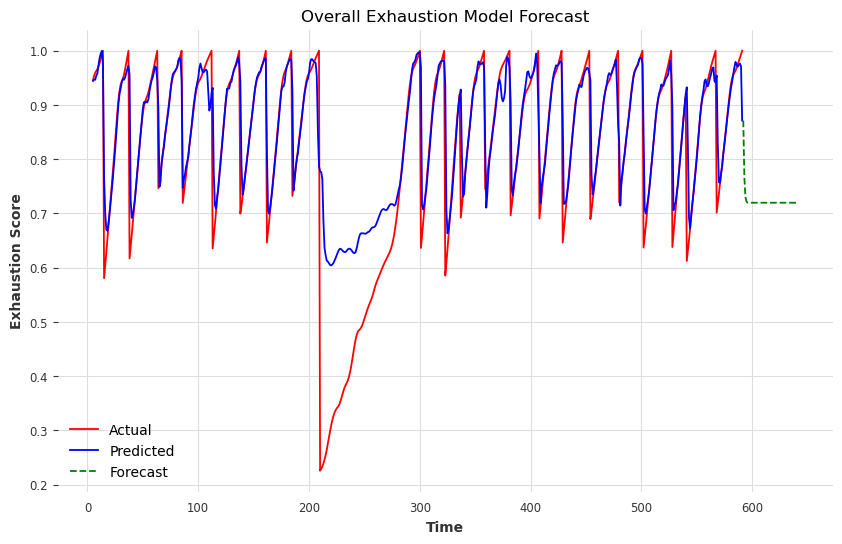

INFO: Created LSTM sequences: (587, 5, 11), (587,)


X_forecast shape: (592, 11), min: 8.951173136040325e-16, max: 90.7
X_forecast_scaled shape: (592, 11), min: -6.002000570705961, max: 5.488644275565178
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
predictions_prob shape: (587, 1), min: 0.00015278042701538652, max: 0.9902036190032959
After clipping - min: 0.00015278042701538652, max: 0.9902036190032959
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━

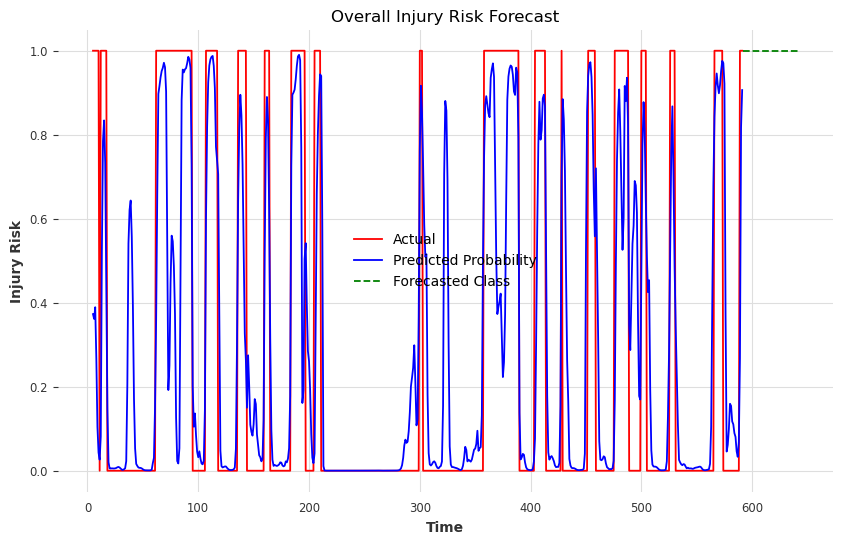

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

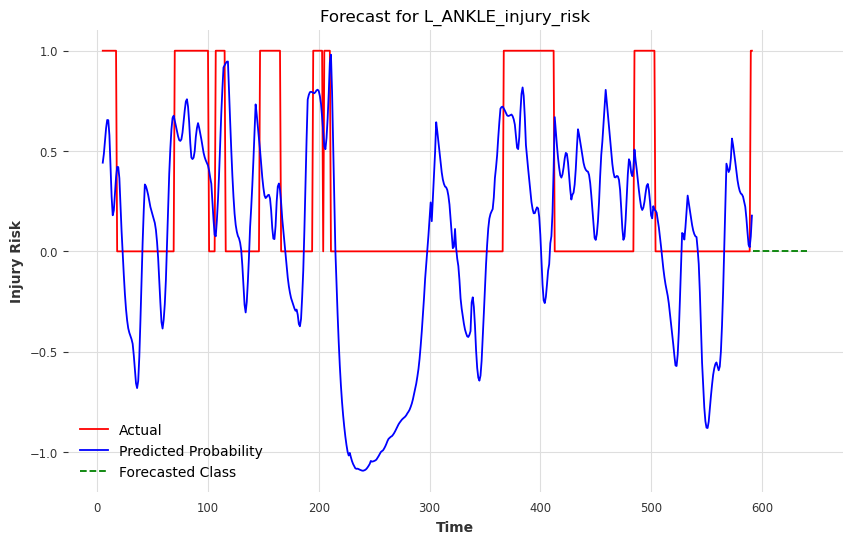

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

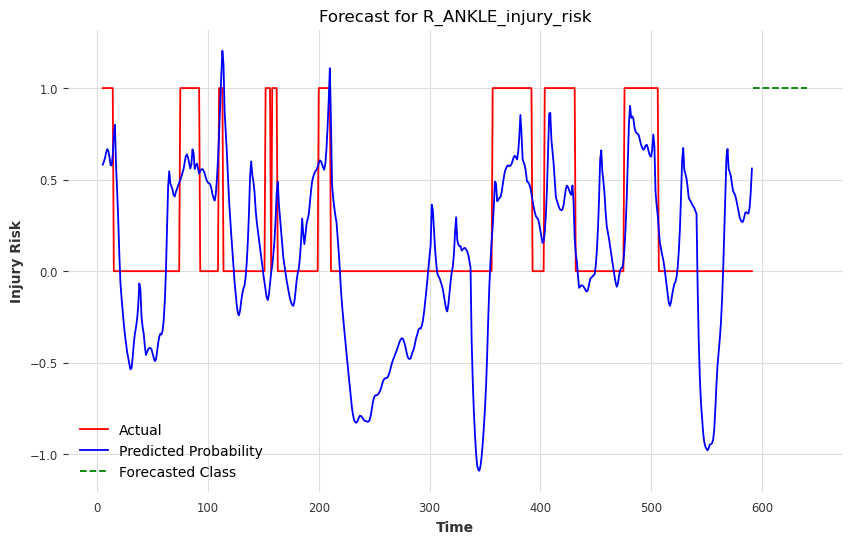

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

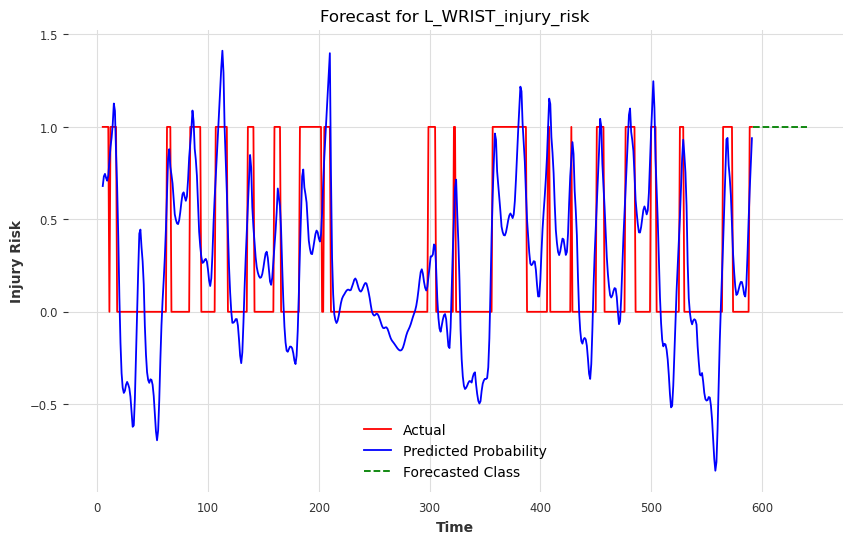

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

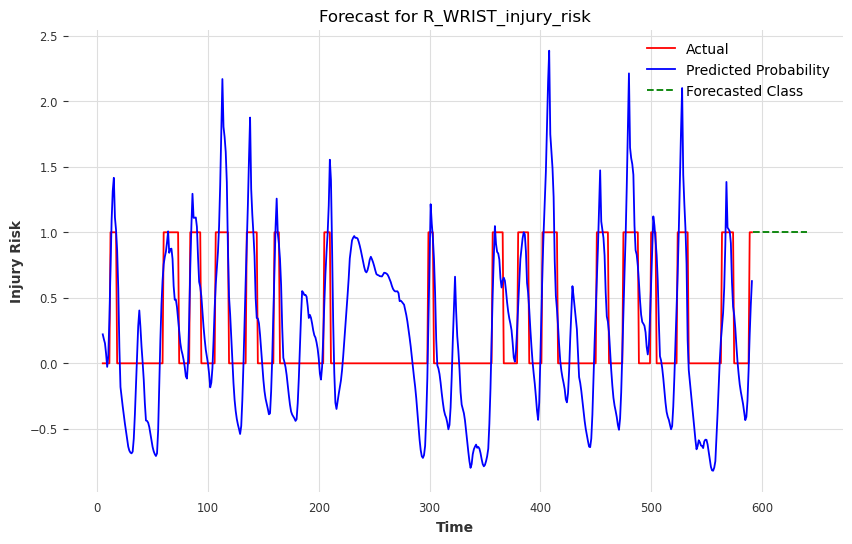

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

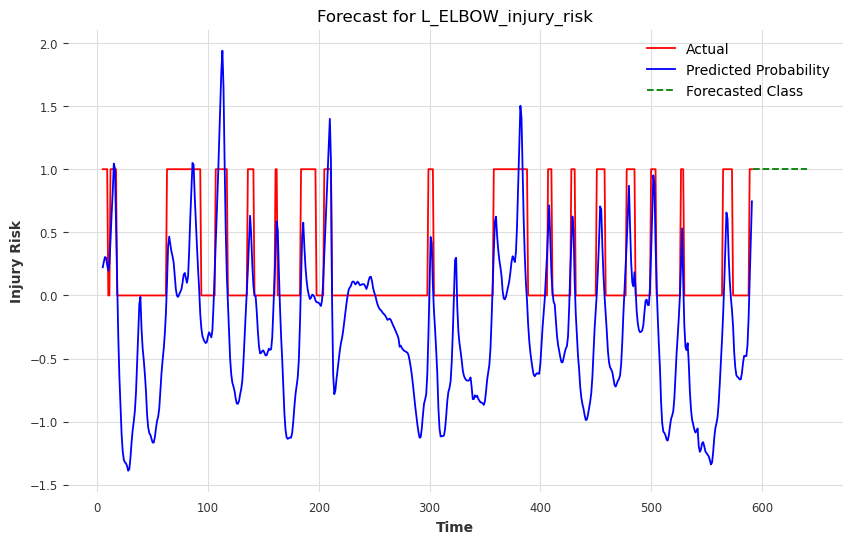

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

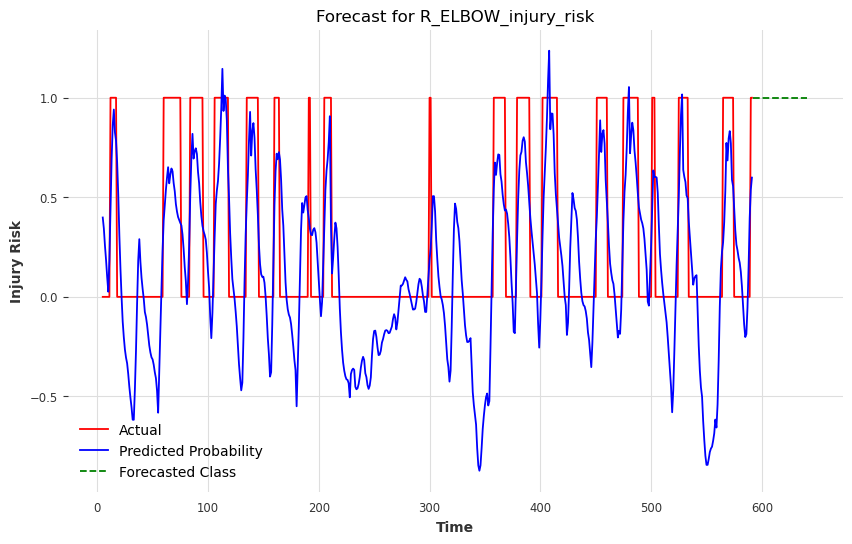

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

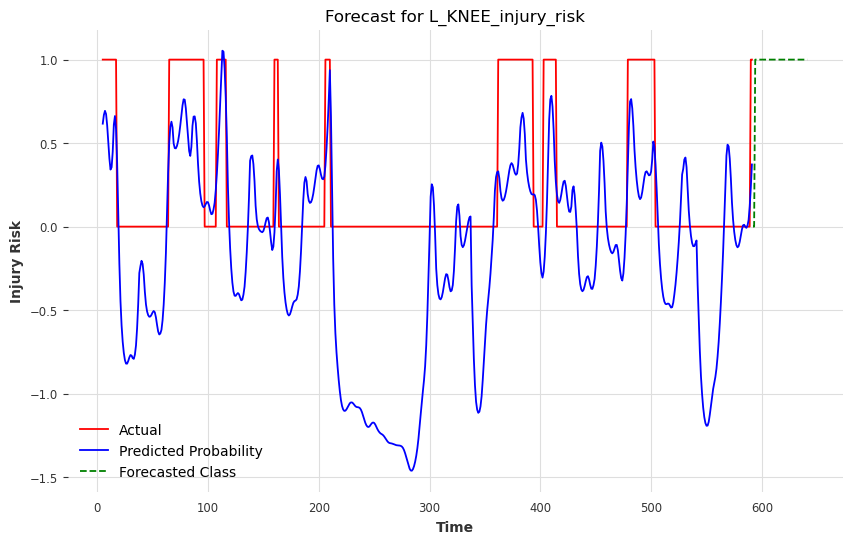

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

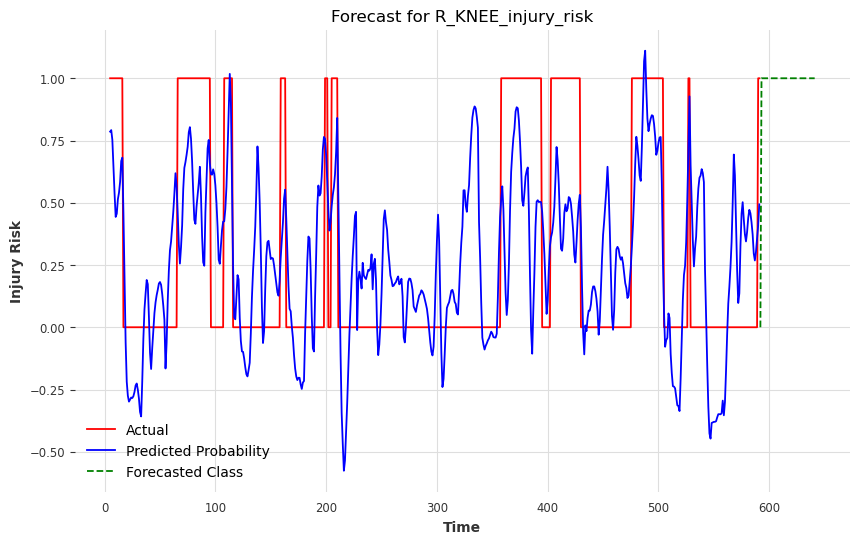

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

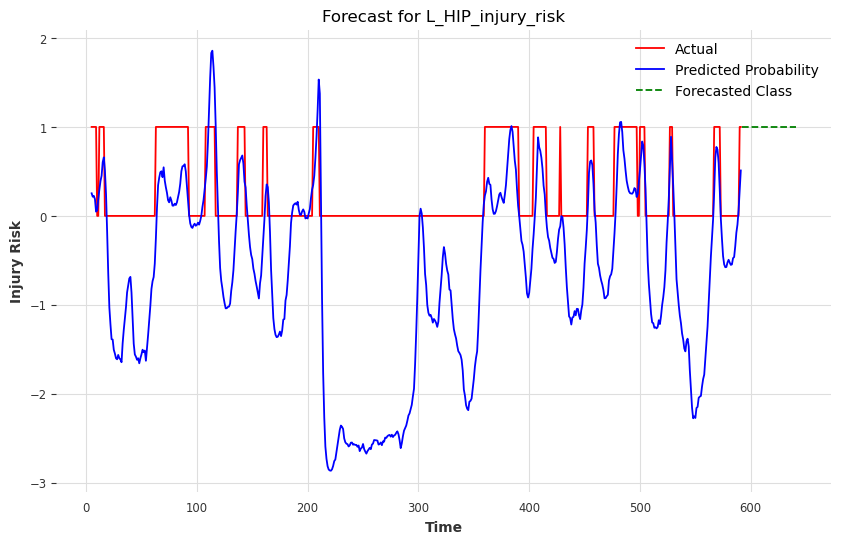

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

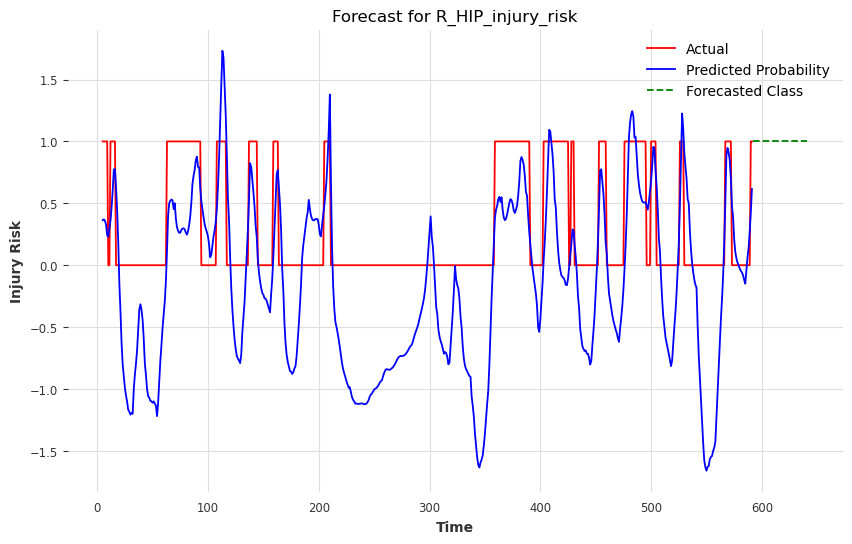

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

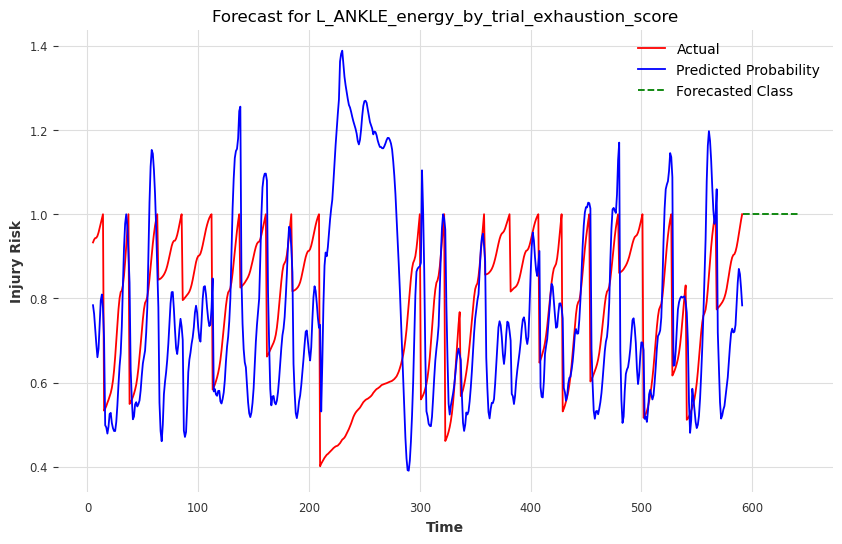

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

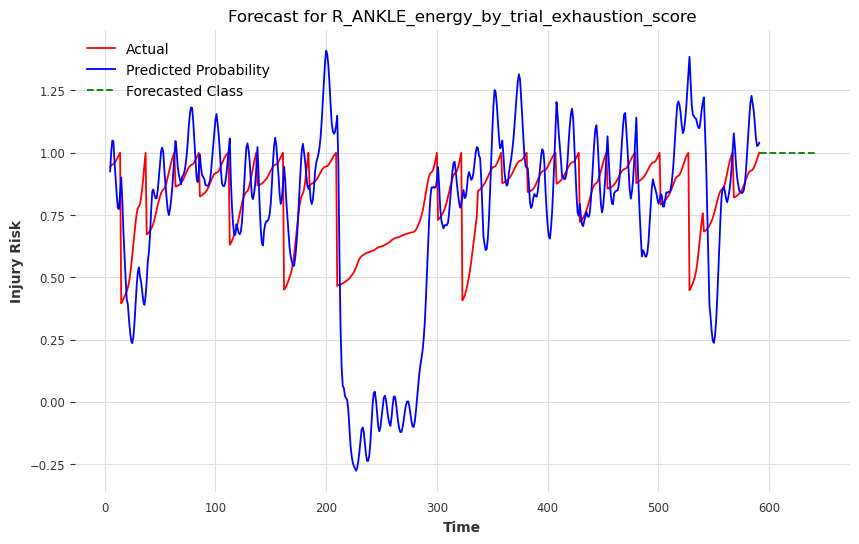

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

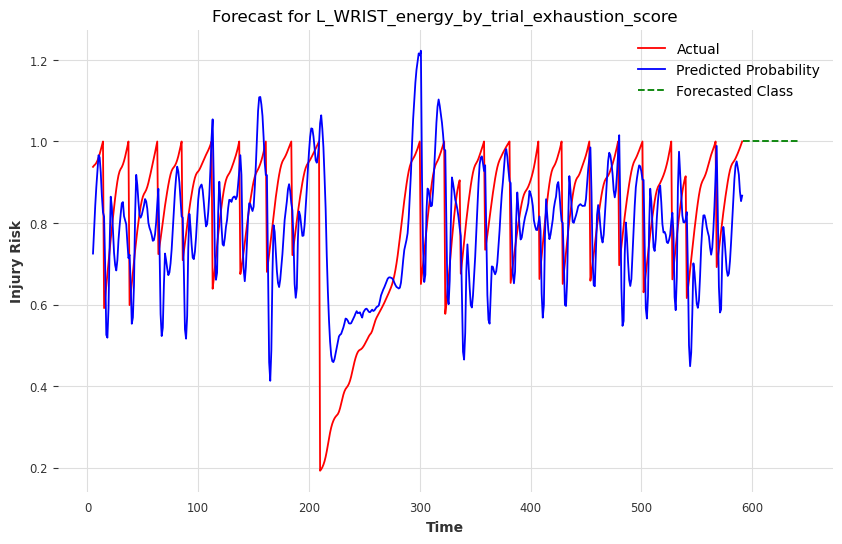

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

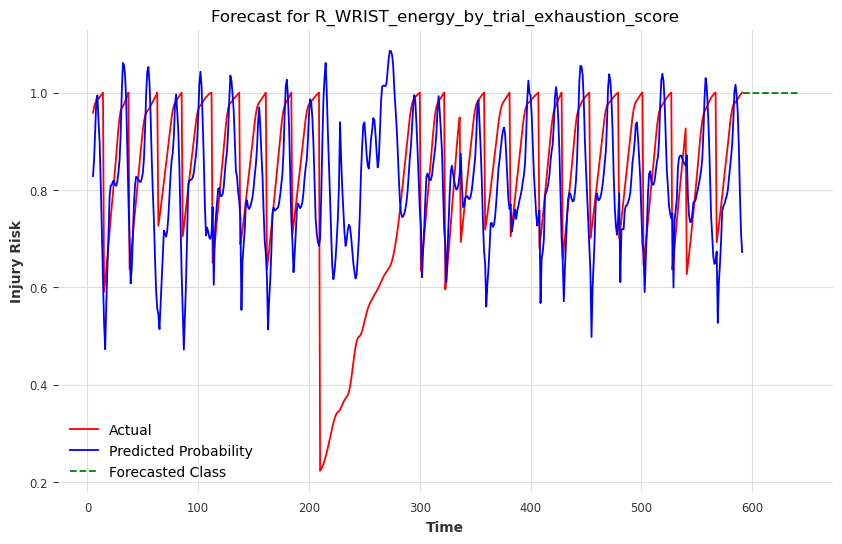

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

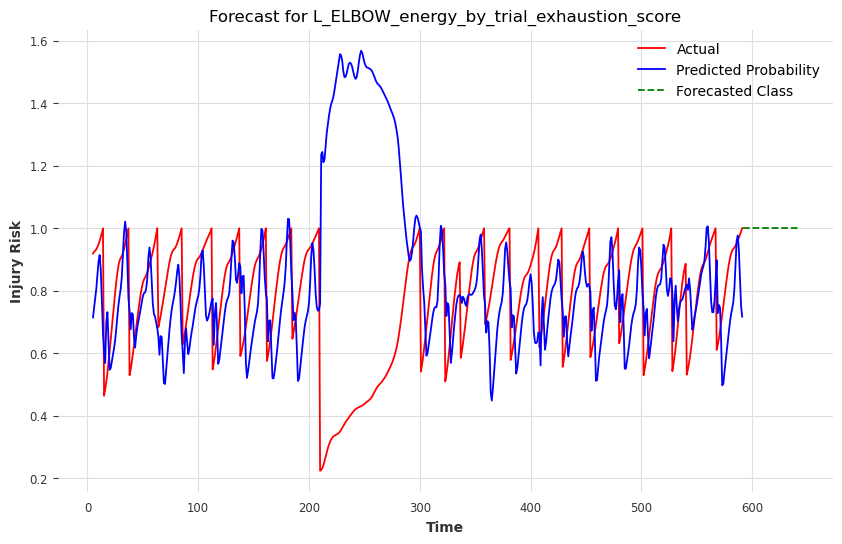

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

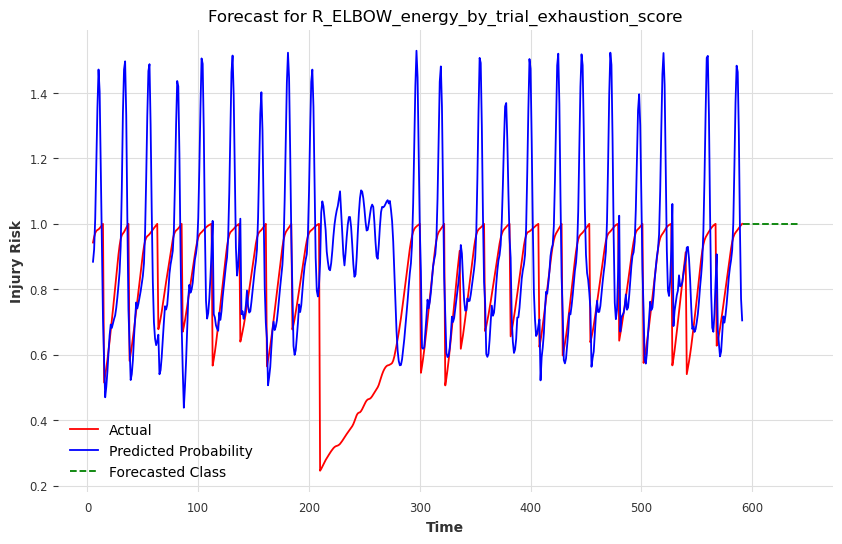

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

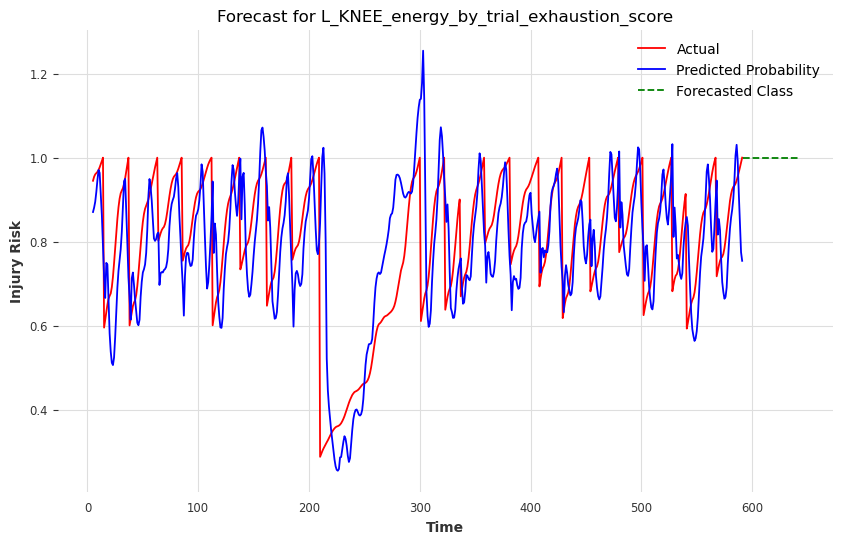

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

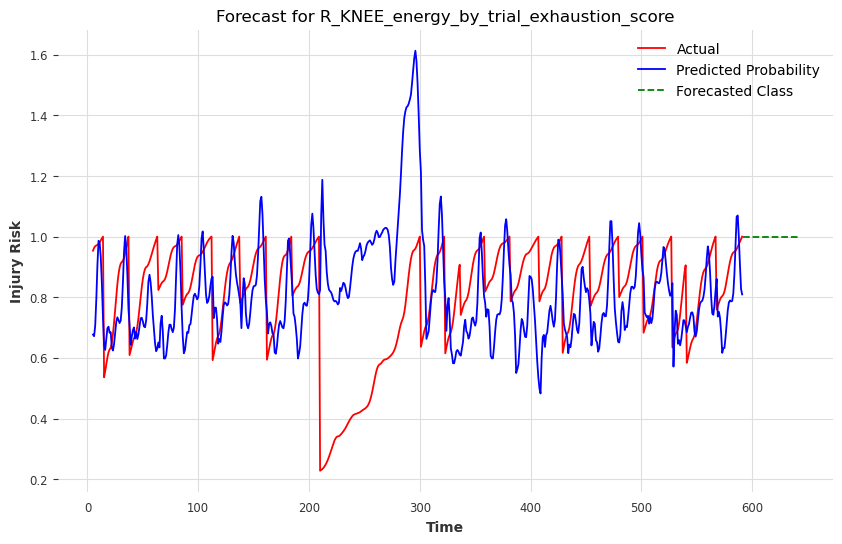

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

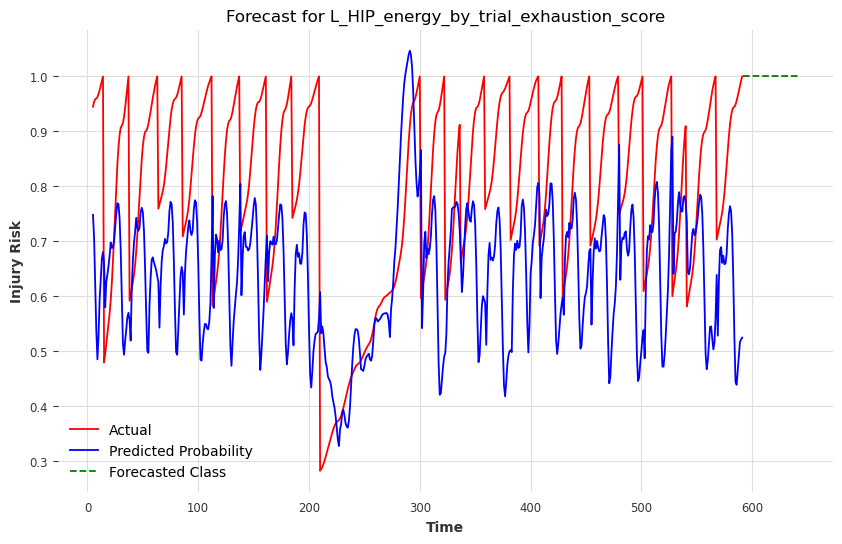

INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

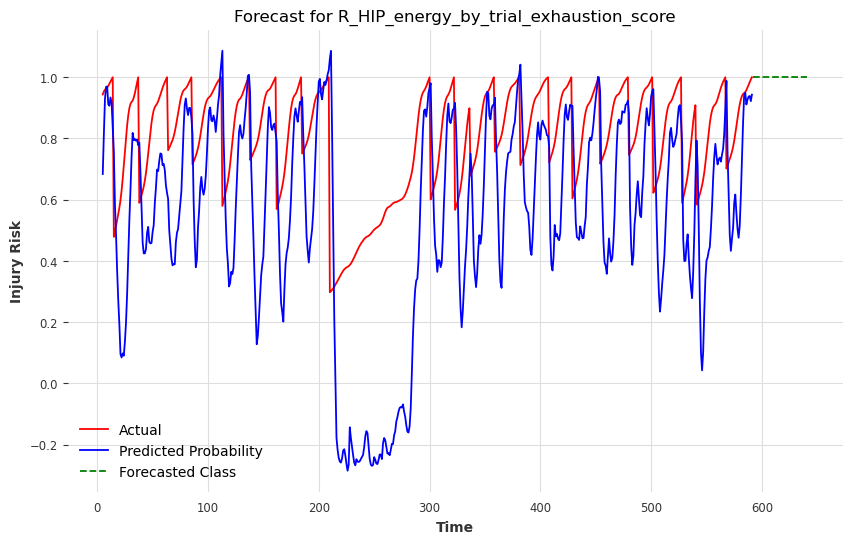

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (587, 5, 10), (587,)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Saved summary to ../../data/Deep_Learning_Final/model_summary_final.csv
INFO: Running conformal uncertainty integration for exhaustion model...


=== Model Summaries (Base Data) ===
                                       Model            Type       MSE  \
0                           Exhaustion Model      Regression  0.009076   
1                               Injury Model  Classification       NaN   
2                        L_ANKLE_injury_risk  Classification       NaN   
3                        R_ANKLE_injury_risk  Classification       NaN   
4                        L_WRIST_injury_risk  Classification       NaN   
5                        R_WRIST_injury_risk  Classification       NaN   
6                        L_ELBOW_injury_risk  Classification       NaN   
7                        R_ELBOW_injury_risk  Classification       NaN   
8                         L_KNEE_injury_risk  Classification       NaN   
9                         R_KNEE_injury_risk  Classification       NaN   
10                         L_HIP_injury_risk  Classification       NaN   
11                         R_HIP_injury_risk  Classification       NaN   
12

TypeError: add_conformal_to_exhaustion_model() got an unexpected keyword argument 'target_col'

In [71]:
# %%writefile ml/preprocess_train_predict/darts_models_for_comparison.py


import torch
import logging
import pandas as pd
import sys
device_str = "cuda" if torch.cuda.is_available() else "cpu"
print(device_str)
from darts.models import NBEATSModel, ExponentialSmoothing
from darts import TimeSeries
from darts.dataprocessing import Pipeline
forecast_horizon = 36  # Set your forecast horizon as needed
model_nbeats = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=forecast_horizon,
    pl_trainer_kwargs={"accelerator": "gpu", "devices": [0]}
)
from ml.load_and_prepare_data.load_data_and_analyze import (
    load_data, prepare_joint_features, 
    feature_engineering, summarize_data, check_and_drop_nulls,
    prepare_base_datasets)

from ml.feature_selection.feature_selection import (
    load_top_features, perform_feature_importance_analysis, save_top_features,
    analyze_joint_injury_features, check_for_invalid_values,
    perform_feature_importance_analysis, analyze_and_display_top_features, 
    run_feature_importance_analysis, run_feature_import_and_load_top_features)

from ml.preprocess_train_predict.base_training import (
    temporal_train_test_split, scale_features, create_sequences, train_exhaustion_model, 
    train_injury_model,  train_joint_models, forecast_and_plot_exhaustion, forecast_and_plot_injury,
    forecast_and_plot_joint, summarize_regression_model, summarize_classification_model, 
    summarize_joint_models, summarize_all_models, final_model_summary, 
    summarize_joint_exhaustion_models
    )
from ml.preprocess_train_predict.conformal_tights import (
    train_conformal_model, predict_with_uncertainty, plot_conformal_results, add_time_series_forecasting,
    add_conformal_to_exhaustion_model
    )

def preprocess_timeseries_darts(ts, transformers=None):
    """
    Preprocesses a Darts TimeSeries object using a pipeline of transformers from Darts.
    
    Parameters:
        ts (TimeSeries): Darts TimeSeries object to be transformed.
        transformers (list): Optional list of transformer objects. If None, a default pipeline
                             using MissingValuesFiller and Scaler is used.
                             
    Returns:
        TimeSeries: The transformed TimeSeries.
    """
    from darts.dataprocessing import Pipeline
    from darts.dataprocessing.transformers import MissingValuesFiller, Scaler


    # Use default transformers if none are provided.
    if transformers is None:
        transformers = [MissingValuesFiller(), Scaler()]

    # Create and fit the transformation pipeline.
    pipeline = Pipeline(transformers)
    ts_transformed = pipeline.fit_transform(ts)
    return ts_transformed



def detect_anomalies_with_darts(time_series, training_window=24, high_quantile=0.99, k=2, window=5):
    """
    Detects anomalies in a Darts TimeSeries using forecasting-based anomaly detection.
    
    This function utilizes the KMeansScorer and QuantileDetector from Darts AD module
    to compute anomaly scores and then convert them into binary anomaly flags.
    
    Parameters:
      - time_series (TimeSeries): Darts TimeSeries object containing the data.
      - training_window (int): Window size for training the anomaly scorer.
      - high_quantile (float): High quantile threshold for binary detection.
      - k (int): Number of clusters for KMeansScorer.
      - window (int): Rolling window size for anomaly scoring.
    
    Returns:
      - binary_anomalies (np.array): Array of binary anomaly flags (1 for anomaly, 0 for normal).
      - anomaly_scores (np.array): Anomaly scores computed for the time series.
    """
    from darts.ad import KMeansScorer, QuantileDetector

    # Use 80% of the series to train the anomaly scorer
    train_length = int(0.8 * len(time_series))
    training_data = time_series[:train_length]
    new_data = time_series[train_length:]
    
    # Train the anomaly scorer on the training data
    scorer = KMeansScorer(k=k, window=window)
    scorer.fit(training_data)
    
    # Score new data for anomalies.
    anomaly_scores = scorer.score(new_data)
    
    # Fit a detector on the training scores and detect anomalies on new data.
    detector = QuantileDetector(high_quantile=high_quantile)
    detector.fit(scorer.score(training_data))
    binary_anomalies = detector.detect(anomaly_scores)
    
    return binary_anomalies, anomaly_scores


from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import MissingValuesFiller, Scaler
from darts.models import NBEATSModel, ExponentialSmoothing
from darts.metrics import mae, mape, rmse, smape
import pandas as pd

def enhanced_forecasting_with_darts_and_metrics(
    data,
    timestamp_col='timestamp',
    target_col='exhaustion_rate',
    train_frac=0.8,
    freq='33ms'
):
    """
    Splits the series, fits two Darts models on train, forecasts on test,
    aligns timestamps, and returns forecasts + test_series + metrics_df.
    
    Parameters:
        data (pd.DataFrame): Input data with timestamp and target columns.
        timestamp_col (str): Name of the timestamp column.
        target_col (str): Name of the target column to forecast.
        train_frac (float): Fraction of data to use for training.
        freq (str): Frequency string for timestamps.
    
    Returns:
        train_series (TimeSeries): Training portion of the time series.
        test_series (TimeSeries): Testing portion of the time series.
        forecast_nbeats (TimeSeries): Forecast from the NBEATS model.
        forecast_es (TimeSeries): Forecast from the Exponential Smoothing model.
        metrics_df (pd.DataFrame): DataFrame containing metrics for both models.
    """
    from darts import TimeSeries
    from darts.dataprocessing import Pipeline
    from darts.dataprocessing.transformers import MissingValuesFiller, Scaler
    from darts.models import NBEATSModel, ExponentialSmoothing
    from darts.metrics import mae, mape, rmse, smape
    import pandas as pd
    import logging

    # Build and preprocess full series
    full_series = TimeSeries.from_dataframe(
        data, time_col=timestamp_col, value_cols=[target_col],
        fill_missing_dates=True, freq=freq
    )
    pipeline = Pipeline([MissingValuesFiller(), Scaler()])
    full_series = pipeline.fit_transform(full_series)

    # Split
    split_idx    = int(train_frac * len(full_series))
    train_series = full_series[:split_idx]
    test_series  = full_series[split_idx:]

    # Instantiate & fit
    model_nbeats = NBEATSModel(input_chunk_length=24, output_chunk_length=len(test_series))
    model_es     = ExponentialSmoothing()
    
    logging.info(f"Fitting NBEATS model for {target_col}...")
    model_nbeats.fit(train_series)
    
    logging.info(f"Fitting ExponentialSmoothing model for {target_col}...")
    model_es.fit(train_series)

    # Forecast exactly test length
    logging.info("Generating forecasts...")
    forecast_nbeats = model_nbeats.predict(n=len(test_series))
    forecast_es     = model_es.predict(n=len(test_series))

    # Compute metrics
    logging.info("Computing metrics...")
    metrics = {
        "NBEATS": {
            "MAE":   mae(test_series, forecast_nbeats),
            "RMSE":  rmse(test_series, forecast_nbeats),
            "SMAPE": smape(test_series, forecast_nbeats),
        },
        "ExpSmoothing": {
            "MAE":   mae(test_series, forecast_es),
            "RMSE":  rmse(test_series, forecast_es),
            "SMAPE": smape(test_series, forecast_es),
        }
    }
    metrics_df = pd.DataFrame(metrics).T
    
    logging.info(f"Darts metrics for {target_col}:\n{metrics_df}")
    
    return train_series, test_series, forecast_nbeats, model_nbeats, forecast_es, metrics_df







# --- Main Script: Running Three Separate Analyses ---
if __name__ == "__main__":
    import os
    from pathlib import Path
    import numpy as np
    import matplotlib.pyplot as plt
    from ml.load_and_prepare_data.load_data_and_analyze import (
        load_data, prepare_joint_features, feature_engineering, summarize_data, check_and_drop_nulls
    )
    debug = True
    importance_threshold = 0.01
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    output_dir = "../../data/Deep_Learning_Final"
    
    base_feature_dir = os.path.join(output_dir, "feature_lists/base")
    trial_feature_dir = os.path.join(output_dir, "feature_lists/trial_summary")
    shot_feature_dir = os.path.join(output_dir, "feature_lists/shot_phase_summary")
    
    data, trial_df, shot_df = prepare_base_datasets(csv_path, json_path, debug=debug)
    numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
    summary_targets = ['exhaustion_rate', 'injury_risk']
    trial_summary_features = [col for col in trial_df.columns if col not in summary_targets]
    trial_summary_features = [col for col in trial_summary_features if col in numeric_features]
    shot_summary_features = [col for col in shot_df.columns if col not in summary_targets]
    shot_summary_features = [col for col in shot_summary_features if col in numeric_features]
    print("Available target columns:", [c for c in data.columns if "exhaustion" in c])
    # ========================================
    # 1) Overall Base Dataset (including Joint-Specific Targets)
    # ========================================
    features = [
        'joint_energy', 'joint_power', 'energy_acceleration',
        'elbow_asymmetry', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 
        '1stfinger_asymmetry', '5thfinger_asymmetry',
        'elbow_power_ratio', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 
        'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio',
        'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme',
        'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme',
        'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme',
        'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme',
        'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme',
        'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme',
        'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme',
        'R_ANKLE_ROM', 'R_ANKLE_ROM_deviation', 'R_ANKLE_ROM_extreme',
        'exhaustion_lag1', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'time_since_start', 'ema_exhaustion', 'rolling_exhaustion', 'rolling_energy_std',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    classification_targets = 'injury_risk'
    regression_targets = 'by_trial_exhaustion_score' # exhaustion_rate
    base_targets = [classification_targets] + [regression_targets]
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    joint_injury_targets = [f"{side}_{joint}_{classification_targets}" for joint in joints for side in ['L', 'R']]
    joint_exhaustion_targets = [f"{side}_{joint}_energy_{regression_targets}" for joint in joints for side in ['L', 'R']] # by_trial_exhaustion_score
    # joint_exhaustion_targets = [f"{side}_{joint}_{regression_targets}" for joint in joints for side in ['L', 'R']]  # exhaustion_rate
    joint_targets = joint_injury_targets + joint_exhaustion_targets
    all_targets = base_targets + joint_targets

    logging.info("=== Base Dataset Analysis (Overall + Joint-Specific) ===")
    base_loaded_features = run_feature_import_and_load_top_features(
        dataset=data,
        features=features,
        targets=all_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/base",
        debug=debug,
        dataset_label="Base Data",
        importance_threshold=importance_threshold,
        n_top=10,
        run_analysis=True
    )
    print(f"Base Loaded Features: {base_loaded_features}")
    
    joint_feature_dict = {}
    for target in joint_targets:
        try:
            feat_loaded = base_loaded_features.get(target, [])
            logging.info(f"Test Load: Features for {target}: {feat_loaded}")
            joint_feature_dict[target] = feat_loaded
        except Exception as e:
            logging.error(f"Error loading features for {target}: {e}")
    
    # ========================================
    # 2) Trial Summary Dataset Analysis
    # ========================================

    
    logging.info("=== Trial Summary Dataset Analysis ===")
    trial_loaded_features = run_feature_import_and_load_top_features(
        dataset=trial_df,
        features=trial_summary_features,
        targets=summary_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/trial_summary",
        debug=debug,
        dataset_label="Trial Summary Data",
        importance_threshold=importance_threshold,
        n_top=10,
        run_analysis=False
    )
    features_exhaustion_trial = trial_loaded_features.get('by_trial_exhaustion_score', [])
    features_injury_trial = trial_loaded_features.get('injury_risk', [])
    trial_summary_data = trial_df.copy()
    
    # ========================================
    # 3) Shot Phase Summary Dataset Analysis
    # ========================================

    
    logging.info("=== Shot Phase Summary Dataset Analysis ===")
    shot_loaded_features = run_feature_import_and_load_top_features(
        dataset=shot_df,
        features=shot_summary_features,
        targets=summary_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/shot_phase_summary",
        debug=debug,
        dataset_label="Shot Phase Summary Data",
        importance_threshold=importance_threshold,
        n_top=10,
        run_analysis=False
    )
    features_exhaustion_shot = shot_loaded_features.get('by_trial_exhaustion_score', [])
    features_injury_shot = shot_loaded_features.get('injury_risk', [])
    shot_phase_summary_data = shot_df.copy()

    # ------------------------------
    # 5. Split Base Data for Training Models
    # ------------------------------
    train_data, test_data = temporal_train_test_split(data, test_size=0.2)
    timesteps = 5

    # Hyperparameters and architecture definitions.
    hyperparams = {
        "epochs": 200,
        "batch_size": 32,
        "early_stop_patience": 5
    }
    arch_exhaustion = {
        "num_lstm_layers": 1,
        "lstm_units": 64,
        "dropout_rate": 0.2,
        "dense_units": 1,
        "dense_activation": None
    }
    arch_injury = {
        "num_lstm_layers": 1,
        "lstm_units": 64,
        "dropout_rate": 0.2,
        "dense_units": 1,
        "dense_activation": "sigmoid"
    }
    
    # For demonstration, define features/targets (you can adjust these as needed)
    features_exhaustion = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'L_WRIST_angle', 'R_WRIST_angle',  # Updated: removed "wrist_angle"
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_exhaustion = 'by_trial_exhaustion_score'

    features_injury = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'knee_asymmetry', 
        'L_WRIST_angle', 'R_WRIST_angle',  # Updated: removed "wrist_angle"
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_injury = 'injury_risk'
    # ------------------------------
    # 6a. Train Models on Base Data for Overall Exhaustion and Injury Risk
    # ------------------------------
    model_exhaustion, scaler_exhaustion, target_scaler, X_val_exh, y_val_exh = train_exhaustion_model(
        train_data, test_data, features_exhaustion, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury, scaler_injury, X_val_injury, y_val_injury = train_injury_model(
        train_data, test_data, features_injury, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    # For joint models, train using the base data and the corresponding feature lists.
    joint_models = {}
    for joint_target, features_list in joint_feature_dict.items():
        try:
            logging.info(f"Training joint-specific injury model for {joint_target} using features: {features_list}")
            model, scaler, X_val_joint, y_val_joint = train_injury_model(
                train_data, test_data,
                features=features_list,
                timesteps=timesteps, 
                epochs=hyperparams["epochs"],
                batch_size=hyperparams["batch_size"],
                early_stop_patience=hyperparams["early_stop_patience"],
                num_lstm_layers=arch_exhaustion["num_lstm_layers"],
                lstm_units=arch_exhaustion["lstm_units"],
                dropout_rate=arch_exhaustion["dropout_rate"],
                dense_units=arch_exhaustion["dense_units"],
                dense_activation=arch_exhaustion["dense_activation"],
                target_col=joint_target
            )
            joint_models[joint_target] = {
                'model': model,
                'features': features_list,
                'scaler': scaler
            }
            logging.info(f"Successfully trained joint model for {joint_target}.")
        except Exception as e:
            logging.error(f"Error training joint model for {joint_target}: {e}")

    # 6c. Train joint exhaustion models (by_trial_exhaustion) for each joint.
    joint_exhaustion_models = {}
    for joint in joints:
        for side in ['L', 'R']:
            target_joint_exh = f"{side}_{joint}_exhaustion_rate"
            try:
                if target_joint_exh in joint_feature_dict:
                    features_list = joint_feature_dict[target_joint_exh]
                    logging.info(f"Using preloaded features for {target_joint_exh}: {features_list}")
                else:
                    features_list = load_top_features(target_joint_exh, feature_dir=base_feature_dir, df=data, n_top=10)
                    logging.info(f"Loaded features for {target_joint_exh}: {features_list}")
                
                model_exh, scaler_exh, target_scaler_exh, X_val_joint_exh, y_val_joint_exh = train_exhaustion_model(
                    train_data, test_data,
                    features=features_list,
                    timesteps=timesteps,
                    epochs=hyperparams["epochs"],
                    batch_size=hyperparams["batch_size"],
                    early_stop_patience=hyperparams["early_stop_patience"],
                    num_lstm_layers=arch_exhaustion["num_lstm_layers"],
                    lstm_units=arch_exhaustion["lstm_units"],
                    dropout_rate=arch_exhaustion["dropout_rate"],
                    dense_units=arch_exhaustion["dense_units"],
                    dense_activation=arch_exhaustion["dense_activation"],
                    target_col=target_joint_exh
                )
                joint_exhaustion_models[target_joint_exh] = {
                    'model': model_exh,
                    'features': features_list,
                    'scaler': scaler_exh
                }
                logging.info(f"Successfully trained joint exhaustion model for {target_joint_exh}.")
            except Exception as e:
                logging.error(f"Error training joint exhaustion model for {target_joint_exh}: {e}")

    # ------------------------------
    # 7a. Forecasting for Base Models
    # ------------------------------
    forecast_and_plot_exhaustion(
        model=model_exhaustion,
        test_data=test_data,
        forecast_features=features_exhaustion,
        scaler_exhaustion=scaler_exhaustion,
        target_scaler=target_scaler,
        timesteps=timesteps,
        future_steps=50,
        title="Overall Exhaustion Model Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury,
        test_data=test_data,
        forecast_features=features_injury,
        scaler_injury=scaler_injury,
        timesteps=timesteps,
        future_steps=50,
        title="Overall Injury Risk Forecast"
    )
    forecast_and_plot_joint(
        joint_models=joint_models,
        test_data=test_data,
        timesteps=timesteps,
        future_steps=50
    )

    # ------------------------------
    # 8. Summarize Base Model Testing Results
    # ------------------------------
    summary_df = summarize_all_models(
        model_exhaustion, X_val_exh, y_val_exh, target_scaler,
        model_injury, X_val_injury, y_val_injury,
        joint_models, test_data, timesteps, output_dir
    )
    print("=== Model Summaries (Base Data) ===")
    print(summary_df)


    # ------------------------------
    # Additional: Conformal Uncertainty Integration
    # ------------------------------
    logging.info("Running conformal uncertainty integration for exhaustion model...")
    conformal_model = add_conformal_to_exhaustion_model(train_data, test_data, target_col='by_trial_exhaustion_score',)
    
    try:
        # Time series forecasting with uncertainty using Darts.
        logging.info("Running time series forecasting with conformal uncertainty...")
        forecaster, forecast, test_target =add_time_series_forecasting(
            data,
            time_col='timestamp',
            value_cols=['by_trial_exhaustion_score']
        )

        # Plot forecast vs. actual (using Darts built-in plotting).
        forecast.plot(label="Forecast")
        test_target.plot(label="Actual")
        plt.title("Time Series Forecast with Conformal Uncertainty")
        plt.legend()
        plt.show()
    except Exception as e:
        logging.error("An error occurred in time series forecasting: " + str(e))
        sys.exit(1)


    # --- A. Preprocess TimeSeries with Darts ---
    from darts import TimeSeries
    # Create a TimeSeries from the exhaustion target column.
    ts_exhaustion = TimeSeries.from_dataframe(
    data,
    time_col='timestamp',
    value_cols=['by_trial_exhaustion_score'],
    fill_missing_dates=True,
    freq='33ms'
)

    # Preprocess the TimeSeries using the Darts pipeline.
    ts_preprocessed = preprocess_timeseries_darts(ts_exhaustion)
    print("Preprocessed TimeSeries head:")
    print(ts_preprocessed.to_dataframe().head())

    # --- B. Detect Anomalies with Darts ---
    anomaly_flags, anomaly_scores = detect_anomalies_with_darts(ts_preprocessed)
    print("Anomaly flags (first 10 values):", anomaly_flags[:10])
    print("Anomaly scores (first 10 values):", anomaly_scores[:10])

    # --- C. Enhanced Forecasting with Darts ---
    # Get the trained model and series from enhanced_forecasting
    train_series, test_series, forecast_nbeats, model_nbeats, forecast_es, metrics_df = enhanced_forecasting_with_darts_and_metrics(
        data, timestamp_col='timestamp', 
        target_col='by_trial_exhaustion_score')

    # And update the plotting code:
    plt.figure(figsize=(12, 6))
    test_series.plot(label="Actual")
    forecast_nbeats.plot(label="NBEATS Forecast")
    forecast_es.plot(label="ExpSmoothing Forecast")
    plt.title("Enhanced Forecasting with Darts")
    plt.legend()
    plt.show()
    # Explaining the model predictions
    from darts.metrics import mae, mape, rmse, smape

    errors = model_nbeats.backtest(
        series=ts_exhaustion,
        start=0.6,
        forecast_horizon=36,
        metric=smape,
        retrain=False
    )
    print("Rolling MAPE distribution:", errors)

    # Print the metrics
    print("\nForecast Metrics:")
    print(metrics_df)

    # ------------------------------
    # 9. Train, Forecast, and Summarize Aggregated Models
    # ------------------------------
    # Instead of using a hard-coded summary_features list, we now load the top features
    # specific to each aggregated dataset (which were saved using the threshold filter).
    
    # --- 9a. Process Trial Summary Data ---
    trial_train_data, trial_test_data = temporal_train_test_split(trial_summary_data, test_size=0.2)
    



    model_exhaustion_trial, scaler_exhaustion_trial, target_scaler_trial, X_val_exh_trial, y_val_exh_trial = train_exhaustion_model(
        trial_train_data, trial_test_data, features_exhaustion_trial, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury_trial, scaler_injury_trial, X_val_injury_trial, y_val_injury_trial = train_injury_model(
        trial_train_data, trial_test_data, features_injury_trial, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    
    forecast_and_plot_exhaustion(
        model=model_exhaustion_trial,
        test_data=trial_test_data,
        forecast_features=features_exhaustion_trial,
        scaler_exhaustion=scaler_exhaustion_trial,
        target_scaler=target_scaler_trial,
        timesteps=timesteps,
        future_steps=50,
        title="Trial Summary Aggregated Exhaustion Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury_trial,
        test_data=trial_test_data,
        forecast_features=features_injury_trial,
        scaler_injury=scaler_injury_trial,
        timesteps=timesteps,
        future_steps=50,
        title="Trial Summary Aggregated Injury Forecast"
    )
    
    trial_summary_df = summarize_all_models(
        model_exhaustion_trial, X_val_exh_trial, y_val_exh_trial, target_scaler_trial,
        model_injury_trial, X_val_injury_trial, y_val_injury_trial,
        joint_models, trial_test_data, timesteps, output_dir,
        include_joint_models=False, debug=debug
    )

    print("=== Model Summaries (Trial Summary Aggregated Data) ===")
    print(trial_summary_df)
    
    # --- 9b. Process Shot Phase Summary Data ---
    shot_train_data, shot_test_data = temporal_train_test_split(shot_phase_summary_data, test_size=0.2)
    


    model_exhaustion_shot, scaler_exhaustion_shot, target_scaler_shot, X_val_exh_shot, y_val_exh_shot = train_exhaustion_model(
        shot_train_data, shot_test_data, features_exhaustion_shot, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury_shot, scaler_injury_shot, X_val_injury_shot, y_val_injury_shot = train_injury_model(
        shot_train_data, shot_test_data, features_injury_shot, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    
    forecast_and_plot_exhaustion(
        model=model_exhaustion_shot,
        test_data=shot_test_data,
        forecast_features=features_exhaustion_shot,
        scaler_exhaustion=scaler_exhaustion_shot,
        target_scaler=target_scaler_shot,
        timesteps=timesteps,
        future_steps=50,
        title="Shot Phase Summary Aggregated Exhaustion Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury_shot,
        test_data=shot_test_data,
        forecast_features=features_injury_shot,
        scaler_injury=scaler_injury_shot,
        timesteps=timesteps,
        future_steps=50,
        title="Shot Phase Summary Aggregated Injury Forecast"
    )
    
    shot_summary_df = summarize_all_models(
        model_exhaustion_shot, X_val_exh_shot, y_val_exh_shot, target_scaler_shot,
        model_injury_shot, X_val_injury_shot, y_val_injury_shot,
        joint_models, shot_test_data, timesteps, output_dir,
        include_joint_models=False, debug=debug
    )

    print("=== Model Summaries (Shot Phase Summary Aggregated Data) ===")
    print(shot_summary_df)


    # ------------------------------
    # Final Step: Group and Compare Summaries Across Datasets
    # ------------------------------

    # Separate base summary into regression and classification parts.
    base_reg = summary_df[summary_df["Type"] == "Regression"]
    base_class = summary_df[summary_df["Type"] == "Classification"]

    trial_reg = trial_summary_df[trial_summary_df["Type"] == "Regression"]
    trial_class = trial_summary_df[trial_summary_df["Type"] == "Classification"]

    shot_reg = shot_summary_df[shot_summary_df["Type"] == "Regression"]
    shot_class = shot_summary_df[shot_summary_df["Type"] == "Classification"]

    # Generate joint injury summary from the base test data.
    joint_injury_dict = summarize_joint_models(joint_models, test_data, timesteps, debug=debug)
    joint_injury_df = pd.DataFrame.from_dict(joint_injury_dict, orient='index').reset_index().rename(columns={'index': 'Model'})
    joint_injury_df["Type"] = "Classification"

    # Generate joint exhaustion summary from the base test data.
    joint_exh_dict = summarize_joint_exhaustion_models(joint_exhaustion_models, test_data, timesteps, debug=debug)
    joint_exh_df = pd.DataFrame.from_dict(joint_exh_dict, orient='index').reset_index().rename(columns={'index': 'Model'})
    joint_exh_df["Type"] = "Regression"
    

    # Build lists for each group.
    regression_summaries = [base_reg, trial_reg, shot_reg]
    classification_summaries = [base_class, trial_class, shot_class]
    # Combine both joint summaries into one list.
    joint_summaries = [joint_injury_df, joint_exh_df]

    # Provide names for each dataset.
    dataset_names = ["Base", "Trial Aggregated", "Shot Aggregated"]
    # For joint models, you may label them as "Joint Injury" and "Joint Exhaustion".
    joint_names = ["Joint Injury Models", "Joint Exhaustion Models"]

    # Get the final combined summaries (including joint summaries).
    final_reg, final_class, final_joint, final_all = final_model_summary(
        regression_summaries, classification_summaries, 
        regression_names=dataset_names, classification_names=dataset_names,
        joint_summaries=joint_summaries, joint_names=joint_names
    )

    print("=== Final Regression Summary ===")
    print(final_reg)
    print("\n=== Final Classification Summary ===")
    print(final_class)
    print("\n=== Final Joint Summary ===")
    print(final_joint)
    print("\n=== Final Combined Summary ===")
    print(final_all) 




# add in the datapreprocessor to try the pad vs dtw vs set_window

https://github.com/ghadfield32/ml_preprocessor


In [ ]:
# %%writefile ml/preprocess_train_predict/datapreprocessor_lstm_experimental_training.py


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import json
from datetime import datetime
import os
import tensorflow as tf
import numpy as np
from datapreprocessor import DataPreprocessor
from darts import TimeSeries
from ml.load_and_prepare_data.load_data_and_analyze import (
    load_data, prepare_joint_features, feature_engineering, summarize_data)

from ml.feature_selection.feature_selection import (
    load_top_features, perform_feature_importance_analysis, save_top_features,
    analyze_joint_injury_features, check_for_invalid_values,
    perform_feature_importance_analysis, analyze_and_display_top_features)

from ml.preprocess_train_predict.base_training import (
    temporal_train_test_split, scale_features, create_sequences, train_exhaustion_model, 
    train_injury_model,  train_joint_models, forecast_and_plot_exhaustion, forecast_and_plot_injury,
    forecast_and_plot_joint, summarize_regression_model, summarize_classification_model, 
    summarize_joint_models, summarize_all_models, final_model_summary, 
    summarize_joint_exhaustion_models
    )


def check_for_nulls(df, step_msg=""):
    """Prints the total number of nulls and lists columns with null values."""
    total_nulls = df.isnull().sum().sum()
    if total_nulls > 0:
        cols_with_nulls = [col for col in df.columns if df[col].isnull().sum() > 0]
        print(f"[{step_msg}] WARNING: Found {total_nulls} null values in columns: {cols_with_nulls}")
    else:
        print(f"[{step_msg}] No null values found.")
        
# Check for extreme values that might cause instability
def analyze_data_distribution(X, name="Data"):
    print(f"\n{name} Analysis:")
    
    if np.isnan(X).any():
        print(f"WARNING: Contains {np.isnan(X).sum()} NaN values")
    
    if np.isinf(X).any():
        print(f"WARNING: Contains {np.isinf(X).sum()} infinite values")
    
    # Calculate statistics per feature
    for i in range(X.shape[-1]):
        feature_data = X[:,:,i].flatten()
        feature_data = feature_data[~np.isnan(feature_data)]  # Remove NaNs for calculation
        
        if len(feature_data) > 0:
            print(f"Feature {i}:")
            print(f"  Range: {np.min(feature_data):.4f} to {np.max(feature_data):.4f}")
            print(f"  Mean: {np.mean(feature_data):.4f}, Std: {np.std(feature_data):.4f}")
            
            # Check for potential outliers
            q1, q3 = np.percentile(feature_data, [25, 75])
            iqr = q3 - q1
            outlier_count = np.sum((feature_data < q1 - 1.5*iqr) | (feature_data > q3 + 1.5*iqr))
            print(f"  Potential outliers: {outlier_count} ({outlier_count/len(feature_data)*100:.2f}%)")




def evaluate_model_metrics(y_true, y_pred):
    """
    Evaluate model predictions using common metrics: MAE, RMSE, and R².
    
    Args:
        y_true (array-like): Ground truth target values.
        y_pred (array-like): Predicted values.
    
    Returns:
        dict: A dictionary with keys 'mae', 'rmse', and 'r2' representing the evaluation metrics.
    """
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import numpy as np

    # Ensure dimensions are compatible using the existing helper function.
    y_true, y_pred = ensure_compatible_dimensions(y_true, y_pred)
    
    # Compute metrics.
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2}

def generate_final_report(report_data):
    """
    Generate and print a summary report for model evaluation metrics.

    Args:
        report_data (list of dict): A list where each dictionary contains:
            'test' (str): A descriptive test name,
            'mae' (float): The Mean Absolute Error,
            'rmse' (float): The Root Mean Squared Error,
            'r2' (float): The R² score.
    """
    print("\n\n==== Final Evaluation Report ====")
    for entry in report_data:
        print(f"Test: {entry['test']}")
        print(f"  MAE: {entry['mae']:.4f}")
        print(f"  RMSE: {entry['rmse']:.4f}")
        print(f"  R²: {entry['r2']:.4f}\n")
    print("==== End of Report ====\n")


#---------------------------------------------
# Custom functions for preprocessing
#---------------------------------------------
def debug_datasets(variables, max_sample_rows=5):
    """
    Debug multiple datasets with detailed information.
    
    Args:
        variables (dict): Dictionary of variable_name: variable_value pairs to debug
        max_sample_rows (int, optional): Maximum number of sample rows to display
    """
    print("\n==== DATASET DEBUG INFORMATION ====")
    
    for name, value in variables.items():
        print(f"\n[{name}]:")
        print(f"  Type: {type(value)}")
        
        if hasattr(value, 'shape'):
            print(f"  Shape: {value.shape}")
        elif isinstance(value, dict):
            print(f"  Length: {len(value)} items")
        elif hasattr(value, '__len__'):
            print(f"  Length: {len(value)}")
        
        # Handle different data types
        if isinstance(value, pd.DataFrame):
            print("\n  Data Sample:")
            print(value.head(max_sample_rows))
            print("\n  Columns:")
            print(value.columns.tolist())
            print("\n  Data Types:")
            print(value.dtypes)
            print(f"\n  Missing Values: {value.isna().sum().sum()} total")
        elif isinstance(value, np.ndarray):
            print("\n  Array Sample:")
            if value.ndim == 1:
                print(value[:min(max_sample_rows, value.shape[0])])
            elif value.ndim == 2:
                print(value[:min(max_sample_rows, value.shape[0]), :min(10, value.shape[1])])
            else:
                print(f"  {value.ndim}-dimensional array (sample not shown)")
            print(f"\n  Data Type: {value.dtype}")
            if np.isnan(value).any():
                print(f"  Warning: Contains {np.isnan(value).sum()} NaN values")
        elif isinstance(value, dict):
            print("\n  Dictionary Keys:")
            print(list(value.keys())[:min(20, len(value))])
            if len(value) > 20:
                print(f"  ... and {len(value) - 20} more keys")
        
        # Add more detailed information for model prediction results
        if name.startswith('result') and isinstance(value, tuple):
            print("\n  Tuple Contents:")
            for i, item in enumerate(value):
                print(f"  Element {i}:")
                print(f"    Type: {type(item)}")
                if hasattr(item, 'shape'):
                    print(f"    Shape: {item.shape}")
                if isinstance(item, np.ndarray) and item.size > 0:
                    print(f"    Sample: {item.flatten()[:min(5, item.size)]}")
    
    print("\n==== END DEBUG INFORMATION ====")

# Example usage:
def debug_preprocessing_result(result, expected_shape=None):
    print(f"Type of result: {type(result)}")
    
    # Create a dictionary to pass to our debug function
    debug_data = {
        'result': result,
        'summary': summary,
        'test_data': test_data,
        'train_data': train_data
    }
    
    if expected_shape:
        debug_data['expected_shape'] = expected_shape
        
    # If result is a tuple, add each component separately
    if isinstance(result, tuple):
        for i, item in enumerate(result):
            debug_data[f'result_element_{i}'] = item
            
    # If we have sequence data, add those too
    if 'y_test_seq' in globals():
        debug_data['y_test_seq'] = y_test_seq
    if 'y_train_seq' in globals():
        debug_data['y_train_seq'] = y_train_seq
        
    debug_datasets(debug_data)
    
    return result

# Updated usage example:
# result = dtw_date_predict.final_preprocessing(new_data, model_input_shape=expected_shape)
# result = debug_preprocessing_result(result, expected_shape)

def select_complete_test_data(full_data, n_trials=2):
    """
    Select a subset of the data that contains complete sequences with all phases.
    
    Args:
        full_data (pd.DataFrame): The complete dataset
        n_trials (int): Number of complete trials to select
        
    Returns:
        pd.DataFrame: A subset containing complete sequences with all phases
    """
    # Get all unique phases in the dataset
    all_phases = full_data['shooting_phases'].unique()
    print(f"All phases in dataset: {all_phases}")
    
    # Find trials that contain all required phases
    complete_trials = []
    
    # Get unique trial/session combinations
    trial_combinations = full_data[['session_biomech', 'trial_biomech']].drop_duplicates().values
    
    for session, trial in trial_combinations:
        # Get data for this trial
        trial_data = full_data[(full_data['session_biomech'] == session) & 
                              (full_data['trial_biomech'] == trial)]
        
        # Check if this trial has all phases
        trial_phases = set(trial_data['shooting_phases'].unique())
        
        if len(trial_phases) >= len(all_phases) - 1:  # Allow for one missing phase
            complete_trials.append((session, trial, len(trial_data)))
    
    print(f"Found {len(complete_trials)} trials with complete phase data")
    
    # Sort by data size (descending) and select the top n_trials
    complete_trials.sort(key=lambda x: x[2], reverse=True)
    selected_trials = complete_trials[:n_trials]
    
    # Create a new DataFrame with the selected trials
    test_data = pd.DataFrame()
    for session, trial, _ in selected_trials:
        trial_data = full_data[(full_data['session_biomech'] == session) & 
                              (full_data['trial_biomech'] == trial)]
        print(f"Selected trial {session}/{trial} with {len(trial_data)} samples and phases: {trial_data['shooting_phases'].unique()}")
        test_data = pd.concat([test_data, trial_data])
    
    return test_data

if __name__ == "__main__":
    import pandas as pd
    import numpy as np
    from datetime import datetime
    import matplotlib.pyplot as plt
    import os
    import logging
    import yaml
    import shutil
    from tensorflow.keras.models import Sequential, load_model
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import os
    from pathlib import Path
    from ml.load_and_prepare_data.load_data_and_analyze import (
        load_data, prepare_joint_features, 
        feature_engineering, summarize_data, check_and_drop_nulls,
        prepare_base_datasets)

    from ml.feature_selection.feature_selection import (
        load_top_features, perform_feature_importance_analysis, save_top_features,
        analyze_joint_injury_features, check_for_invalid_values,
        perform_feature_importance_analysis, analyze_and_display_top_features, 
        run_feature_importance_analysis, run_feature_import_and_load_top_features)

    from ml.preprocess_train_predict.base_training import (
        temporal_train_test_split, scale_features, create_sequences, train_exhaustion_model, 
        train_injury_model,  train_joint_models, forecast_and_plot_exhaustion, forecast_and_plot_injury,
        forecast_and_plot_joint, summarize_regression_model, summarize_classification_model, 
        summarize_joint_models, summarize_all_models, final_model_summary, 
        summarize_joint_exhaustion_models
        )
    from ml.preprocess_train_predict.conformal_tights import (
        train_conformal_model, predict_with_uncertainty, plot_conformal_results, add_time_series_forecasting,
        add_conformal_to_exhaustion_model
        )
    from ml.preprocess_train_predict.darts_models_for_comparison import ( 
        preprocess_timeseries_darts, detect_anomalies_with_darts, enhanced_forecasting_with_darts_and_metrics)


    graphs_output_dir="../../data/Deep_Learning_Final/graphs"
    transformers_dir="../../data/Deep_Learning_Final/transformers"
    debug = True
    importance_threshold = 0.01
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    output_dir = "../../data/Deep_Learning_Final"
    
    base_feature_dir = os.path.join(output_dir, "feature_lists/base")
    trial_feature_dir = os.path.join(output_dir, "feature_lists/trial_summary")
    shot_feature_dir = os.path.join(output_dir, "feature_lists/shot_phase_summary")
    
    data, trial_df, shot_df = prepare_base_datasets(csv_path, json_path, debug=debug)
    # check uniques in shooting_phases
    print("Unique shooting phases:", data['shooting_phases'].unique())
    PHASE_MAP = {
    'leg_cock':      'leg_cock',
    'arm_cock':      'arm_cock',
    'arm_release':   'arm_release',
    'wrist_release': 'wrist_release'
    }
    EXPECTED_PHASES = {'leg_cock', 'arm_cock', 'arm_release', 'wrist_release'}

    # Group the data first by trial_id (or another appropriate column)
    for group_key, group_df in data.groupby('trial_id'):
        raw_phases = group_df['shooting_phases'].unique().tolist()
        normalized_phases = [PHASE_MAP.get(p, p) for p in raw_phases]
        unique_phases = set(normalized_phases)

        print(f"[DEBUG] Group {group_key}")
        print(f"  raw_phases      : {raw_phases}")
        print(f"  normalized      : {normalized_phases}")
        print(f"  unique_phases   : {unique_phases}")
        print(f"  expected        : {EXPECTED_PHASES}")

        missing = EXPECTED_PHASES - unique_phases
        if missing:
            print(f"  → DROPPING: missing {missing}")
            continue
        # else: proceed to build sequences


    numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
    summary_targets = ['exhaustion_rate', 'injury_risk']
    trial_summary_features = [col for col in trial_df.columns if col not in summary_targets]
    trial_summary_features = [col for col in trial_summary_features if col in numeric_features]
    shot_summary_features = [col for col in shot_df.columns if col not in summary_targets]
    shot_summary_features = [col for col in shot_summary_features if col in numeric_features]
    print("Available target columns:", [c for c in data.columns if "exhaustion" in c])
    # ========================================
    # 1) Overall Base Dataset (including Joint-Specific Targets)
    # ========================================
    features = [
        'joint_energy', 'joint_power', 'energy_acceleration',
        'elbow_asymmetry', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 
        '1stfinger_asymmetry', '5thfinger_asymmetry',
        'elbow_power_ratio', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 
        'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio',
        'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme',
        'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme',
        'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme',
        'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme',
        'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme',
        'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme',
        'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme',
        'R_ANKLE_ROM', 'R_ANKLE_ROM_deviation', 'R_ANKLE_ROM_extreme',
        'exhaustion_lag1', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'time_since_start', 'ema_exhaustion', 'rolling_exhaustion', 'rolling_energy_std',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    base_targets = ['exhaustion_rate', 'injury_risk']
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    joint_injury_targets = [f"{side}_{joint}_injury_risk" for joint in joints for side in ['L', 'R']]
    joint_exhaustion_targets = [f"{side}_{joint}_exhaustion_rate" for joint in joints for side in ['L', 'R']]
    joint_targets = joint_injury_targets + joint_exhaustion_targets
    all_targets = base_targets + joint_targets

    logging.info("=== Base Dataset Analysis (Overall + Joint-Specific) ===")
    base_loaded_features = run_feature_import_and_load_top_features(
        dataset=data,
        features=features,
        targets=all_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/base",
        debug=debug,
        dataset_label="Base Data",
        importance_threshold=importance_threshold,
        n_top=10,
        run_analysis=False
    )
    print(f"Base Loaded Features: {base_loaded_features}")
    
    joint_feature_dict = {}
    for target in joint_targets:
        try:
            feat_loaded = base_loaded_features.get(target, [])
            logging.info(f"Test Load: Features for {target}: {feat_loaded}")
            joint_feature_dict[target] = feat_loaded
        except Exception as e:
            logging.error(f"Error loading features for {target}: {e}")
    
    # ========================================
    # 2) Trial Summary Dataset Analysis
    # ========================================

    
    logging.info("=== Trial Summary Dataset Analysis ===")
    trial_loaded_features = run_feature_import_and_load_top_features(
        dataset=trial_df,
        features=trial_summary_features,
        targets=summary_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/trial_summary",
        debug=debug,
        dataset_label="Trial Summary Data",
        importance_threshold=importance_threshold,
        n_top=10,
        run_analysis=False
    )
    features_exhaustion_trial = trial_loaded_features.get('exhaustion_rate', [])
    features_injury_trial = trial_loaded_features.get('injury_risk', [])
    trial_summary_data = trial_df.copy()
    
    # ========================================
    # 3) Shot Phase Summary Dataset Analysis
    # ========================================

    
    logging.info("=== Shot Phase Summary Dataset Analysis ===")
    shot_loaded_features = run_feature_import_and_load_top_features(
        dataset=shot_df,
        features=shot_summary_features,
        targets=summary_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/shot_phase_summary",
        debug=debug,
        dataset_label="Shot Phase Summary Data",
        importance_threshold=importance_threshold,
        n_top=10,
        run_analysis=False
    )
    features_exhaustion_shot = shot_loaded_features.get('exhaustion_rate', [])
    features_injury_shot = shot_loaded_features.get('injury_risk', [])
    shot_phase_summary_data = shot_df.copy()
    # Nominal/Categorical variables: For example, identifiers or labels (none of these apply here)
    nominal_categorical = ['player_height_in_meters', 'player_weight__in_kg', 'shooting_phases']

    # Ordinal/Categorical variables: Categorical variables with a natural order (none of these apply here)
    ordinal_categorical = []

    # Numerical variables: All of your features are continuous numerical measurements.
    numerical = [
        'joint_energy',
        'joint_power',
        'energy_acceleration',
        'hip_asymmetry',
        'wrist_asymmetry',
        'rolling_power_std',
        'rolling_hr_mean',
        'rolling_energy_std',
        'simulated_HR'
    ]
    # Set up logging for debugging purposes.
    logging.basicConfig(level=logging.DEBUG, format='%(asctime)s [%(levelname)s] %(message)s')
    logger = logging.getLogger(__name__)

    features = nominal_categorical + ordinal_categorical + numerical
    base_targets = ['exhaustion_rate', 'injury_risk']
    
    
    # Load your training data
    logger.info(f"Training data loaded from {csv_path}. Shape: {data.shape}")
    
    y_variable = [base_targets[0]]
    ordinal_categoricals=ordinal_categorical
    nominal_categoricals=nominal_categorical
    numericals=numerical

    from tensorflow.keras.losses import MeanSquaredError
    # Define model building function
    def build_lstm_model(input_shape, horizon=1):
        """
        Build an LSTM model with an output layer that matches the specified horizon.
        
        Args:
            input_shape: Tuple defining the input shape (timesteps, features)
            horizon: Number of future timesteps to predict (output dimension)
            
        Returns:
            A compiled Keras Sequential model
        """
        model = Sequential([
            LSTM(64, input_shape=input_shape, return_sequences=True),
            Dropout(0.2),
            LSTM(32),
            Dropout(0.2),
            Dense(horizon)  # Output dimension now dynamically set by horizon
        ])
        model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mae'])
        return model

    def ensure_compatible_dimensions(targets, predictions):
        """
        Ensure that targets and predictions have compatible dimensions for error metric calculation.
        
        This function converts inputs to NumPy arrays, squeezes the last dimension if it is 1
        (to convert a (samples, time_steps, 1) array to (samples, time_steps)), truncates both arrays
        to the minimum number of samples if they differ, and reshapes 1D arrays to 2D if needed.
        
        Args:
            targets (array-like): Ground truth target values.
            predictions (array-like): Predicted values.
        
        Returns:
            Tuple[np.ndarray, np.ndarray]: The adjusted target and prediction arrays.
        """
        import numpy as np

        # Convert inputs to NumPy arrays
        targets = np.array(targets)
        predictions = np.array(predictions)

        # If targets or predictions have an extra dimension of size 1, squeeze that axis.
        if targets.ndim == 3 and targets.shape[2] == 1:
            targets = targets.squeeze(axis=2)
        if predictions.ndim == 3 and predictions.shape[2] == 1:
            predictions = predictions.squeeze(axis=2)

        # If number of samples (first axis) differ, truncate both arrays to the minimum count.
        if targets.shape[0] != predictions.shape[0]:
            n_samples = min(targets.shape[0], predictions.shape[0])
            targets = targets[:n_samples]
            predictions = predictions[:n_samples]

        # If one array is 1D and the other 2D, reshape the 1D array to 2D.
        if targets.ndim == 1 and predictions.ndim == 2:
            targets = targets.reshape(-1, 1)
        elif predictions.ndim == 1 and targets.ndim == 2:
            predictions = predictions.reshape(-1, 1)

        # Debug print the adjusted shapes
        print(f"Adjusted shapes - targets: {targets.shape}, predictions: {predictions.shape}")

        return targets, predictions



    def get_horizon_from_preprocessor(preprocessor):
        """
        Extract the horizon parameter from the preprocessor.
        
        For DTW or pad modes, if the horizon has not been computed yet,
        it returns the product of horizon_sequence_number and sequence_length.
        Otherwise, it returns the computed horizon.
        """
        if hasattr(preprocessor, 'time_series_sequence_mode') and preprocessor.time_series_sequence_mode in ["dtw", "pad"]:
            if preprocessor.horizon is not None:
                return preprocessor.horizon
            else:
                return preprocessor.horizon_sequence_number * preprocessor.sequence_length
        elif hasattr(preprocessor, 'options') and isinstance(preprocessor.options, dict):
            return preprocessor.options.get('horizon', 1)
        elif hasattr(preprocessor, 'horizon'):
            return preprocessor.horizon
        else:
            return 1  # Default horizon if not specified


    
    # ---------- Test 1: Percentage-based Split ----------
    print("\n\n=== Test 1: Percentage-based Split (80/20) ===")

    # Clean transformers directory
    shutil.rmtree('./transformers', ignore_errors=True)
    os.makedirs('./transformers', exist_ok=True)
    # Calculate the index to split the dataset into thirds
    split_index = int(len(data) * (2 / 3))

    # Set new_data as the last third of the dataset
    new_data = data.iloc[split_index:].copy()
    
    # list columns
    print("New data columns:", new_data.columns.tolist())

    # Debugging information
    print(f"Total dataset size: {len(data)}")
    print(f"Split index (start of last third): {split_index}")
    print(f"New data (last third) shape: {new_data.shape}")

    # Configure the preprocessor for training without explicit window_size, step_size, or horizon parameters.
    preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="train",
        options={
            "enabled": True,
            "time_column": "datetime",
            "horizon": 10,  # Horizon value is provided here
            "step_size": 1,  # Step size provided here
            "sequence_modes": {
                "set_window": {
                    "window_size": 10,  # Window size provided here
                    "max_sequence_length": 10
                }
            },
            "ts_sequence_mode": "set_window",
            "split_dataset": {
                "test_size": 0.2,
                "random_state": 42
            },
            "time_series_split": {
                "method": "standard"
            }
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        time_series_sequence_mode="set_window",
        debug=True
    )

    # Preprocess the training data
    X_train_seq, X_test_seq, y_train_seq, y_test_seq, recommendations, _ = preprocessor.final_ts_preprocessing(data)
    
    # Debug on the data
    analyze_data_distribution(X_train_seq, "Training Features")
    analyze_data_distribution(y_train_seq, "Training Targets")

    print(f"Train shapes - X: {X_train_seq.shape}, y: {y_train_seq.shape}")
    print(f"Test shapes - X: {X_test_seq.shape}, y: {y_test_seq.shape}")
    
    # Train a model
    print("Training LSTM model with percentage-based split...")
    # Extract horizon from preprocessor
    horizon = get_horizon_from_preprocessor(preprocessor)
    print(f"Using horizon of {horizon} for model output dimension")

    # Build the LSTM model using the extracted horizon
    model1 = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]), horizon=horizon)

    model1.fit(
        X_train_seq, y_train_seq, 
        validation_data=(X_test_seq, y_test_seq),
        epochs=10, batch_size=32, verbose=1
    )
    model1.save('./transformers/model_percentage_split.h5')
    
    # Predict using the test set
    predictions = model1.predict(X_test_seq)
    print(f"Predictions shape: {predictions.shape}, Target shape: {y_test_seq.shape}")
    if predictions.shape[-1] != y_test_seq.shape[-1]:
        print(f"WARNING: Shape mismatch detected: predictions {predictions.shape} vs targets {y_test_seq.shape}")
        
    # Apply dimension compatibility function
    y_test_seq, predictions = ensure_compatible_dimensions(y_test_seq, predictions)

    mae = mean_absolute_error(y_test_seq, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_seq, predictions))
    print(f"Model evaluation - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    
    # Predict using predict mode
    print("\nTesting prediction mode with new data...")
    
    # Take the last segment of data as "new" data for prediction
    # new_data = data.iloc[-48:].copy()  
    
    # Configure the preprocessor for prediction
    predict_preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="predict",
        options={
            "enabled": True,
            "time_column": "datetime",
            "horizon": 10,              # Number of time steps ahead to predict
            "step_size": 1,             # Step size for moving the window
            "sequence_modes": {         # Window configuration for sequence mode
                "set_window": {
                    "window_size": 10,         # Size of each window
                    "max_sequence_length": 10  # Maximum sequence length
                }
            },
            "ts_sequence_mode": "set_window"
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        transformers_dir="./transformers"
    )

    

    # Make predictions
    model1 = load_model('./transformers/model_percentage_split.h5')
    expected_shape = model1.input_shape
    print(f"Expected model input shape: {expected_shape}")

    # Preprocess new data for prediction
    # results = predict_preprocessor.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    # X_new_preprocessed = results[0]
    X_new_preprocessed, recommendations, X_inversed = predict_preprocessor.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    
    
    print(f"Prediction data shape: {X_new_preprocessed.shape}")
    
    predictions = model1.predict(X_new_preprocessed)
    print(f"Prediction results shape: {predictions.shape}")
    print(f"Predictions: {predictions[:5].flatten()}")
    # Compute and print evaluation metrics using the new function.
    model1_metrics = evaluate_model_metrics(y_test_seq, predictions)
    print(f"Model evaluation metrics - MAE: {model1_metrics['mae']:.4f}, RMSE: {model1_metrics['rmse']:.4f}, R²: {model1_metrics['r2']:.4f}")

    
    # ---------- Test 2: Date-based Split ----------
    print("\n\n=== Test 2: Date-based Split (2025-02-14 11:00) ===")
    
    # Clean transformers directory
    shutil.rmtree('./transformers', ignore_errors=True)
    os.makedirs('./transformers', exist_ok=True)

    new_data = new_data.copy()
    # Configure the preprocessor for training with date-based split
    preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="train",
        options={
            "enabled": True,
            "time_column": "datetime",
            "horizon": 10,
            "step_size": 1,
            "sequence_modes": {
                "set_window": {
                    "window_size": 10,  # 1 day window
                    "max_sequence_length": 10
                }
            },
            "ts_sequence_mode": "set_window",
            "split_dataset": {
                "test_size": 0.2,  # Not used for date-based split
                "random_state": 42,
                "time_split_column": "datetime",
                "time_split_value": pd.Timestamp("2025-02-14 11:50:00")
            },
            "time_series_split": {
                "method": "standard"
            }
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        time_series_sequence_mode="set_window",
        debug=True
    )
    
    # Preprocess the training data
    X_train_seq, X_test_seq, y_train_seq, y_test_seq, recommendations, _ = preprocessor.final_ts_preprocessing(data)
    
    print(f"Train shapes - X: {X_train_seq.shape}, y: {y_train_seq.shape}")
    print(f"Test shapes - X: {X_test_seq.shape}, y: {y_test_seq.shape}")
    
    # Train a model
    print("Training LSTM model with date-based split...")
    # Extract horizon from preprocessor
    horizon = get_horizon_from_preprocessor(preprocessor)
    print(f"Using horizon of {horizon} for model output dimension")

    # Build the LSTM model using the extracted horizon
    model2 = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]), horizon=horizon)

    model2.fit(
        X_train_seq, y_train_seq, 
        validation_data=(X_test_seq, y_test_seq),
        epochs=10, batch_size=32, verbose=1
    )
    model2.save('./transformers/model_date_split.h5')
    
    # Test prediction mode
    print("\nTesting prediction mode with new data...")
    
    # Take the last segment of data as "new" data for prediction
    # new_data = data.iloc[-48:].copy()  
    
    # Configure the preprocessor for prediction
    predict_preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="predict",
        options={
            "enabled": True,
            "time_column": "datetime",
            "horizon": 10,              # Number of time steps ahead to predict
            "step_size": 1,             # Step size for moving the window
            "sequence_modes": {         # Window configuration for sequence mode
                "set_window": {
                    "window_size": 10,         # Size of each window
                    "max_sequence_length": 10  # Maximum sequence length
                }
            },
            "ts_sequence_mode": "set_window"
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        transformers_dir="./transformers"
    )

    
    # Preprocess new data for prediction
    # results = predict_preprocessor.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    # X_new_preprocessed = results[0]
    X_new_preprocessed, recommendations, X_inversed = predict_preprocessor.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    
    # Make predictions
    model2 = load_model('./transformers/model_date_split.h5')
    expected_shape = model2.input_shape
    print(f"Expected model input shape: {expected_shape}")
    predictions = model2.predict(X_new_preprocessed)
    print(f"Prediction results shape: {predictions.shape}")
    # Apply dimension compatibility function
    y_test_seq, predictions = ensure_compatible_dimensions(y_test_seq, predictions)

    # Compute and print evaluation metrics using the new function.
    model2_metrics = evaluate_model_metrics(y_test_seq, predictions)
    print(f"Model evaluation metrics - MAE: {model2_metrics['mae']:.4f}, RMSE: {model2_metrics['rmse']:.4f}, R²: {model2_metrics['r2']:.4f}")

    # ---------- Test 3: PSI-based Split with Feature-Engine ----------
    print("\n\n=== Test 3: PSI-based Split with Feature-Engine ===")
    
    # Clean transformers directory
    shutil.rmtree('./transformers', ignore_errors=True)
    os.makedirs('./transformers', exist_ok=True)

    new_data = new_data.copy()
    # Configure the preprocessor for training with PSI-based split
    preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="train",
        options={
            "enabled": True,
            "time_column": "datetime",
            "horizon": 10,
            "step_size": 1,
            "sequence_modes": {
                "set_window": {
                    "window_size": 10,  # 1 day window
                    "max_sequence_length": 10
                }
            },
            "ts_sequence_mode": "set_window",
            "psi_feature_selection": {
                "enabled": True,
                "threshold": 0.25,
                "split_frac": 0.75,
                "split_distinct": False,
                "apply_before_split": True
            },
            "feature_engine_split": {
                "enabled": True,
                "split_frac": 0.75,
                "split_distinct": False
            },
            "time_series_split": {
                "method": "feature_engine"
            }
        },
        # sequence_categorical=["trial_id"],
        # sub_sequence_categorical=["shooting_phases"],
        time_series_sequence_mode="set_window",
        debug=True,
        graphs_output_dir="./plots"
    )
    
    # Preprocess the training data
    X_train_seq, X_test_seq, y_train_seq, y_test_seq, recommendations, _ = preprocessor.final_ts_preprocessing(data)
    
    print(f"Train shapes - X: {X_train_seq.shape}, y: {y_train_seq.shape}")
    print(f"Test shapes - X: {X_test_seq.shape}, y: {y_test_seq.shape}")
    
    # Visualize PSI results if the method was run
    preprocessor.visualize_psi_results(data, top_n=5)
    
    # Train a model
    print("Training LSTM model with PSI-based split...")
    # Extract horizon from preprocessor
    horizon = get_horizon_from_preprocessor(preprocessor)
    print(f"Using horizon of {horizon} for model output dimension")

    # Build the LSTM model using the extracted horizon
    model3 = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]), horizon=horizon)

    model3.fit(
        X_train_seq, y_train_seq, 
        validation_data=(X_test_seq, y_test_seq),
        epochs=10, batch_size=32, verbose=1
    )
    model3.save('./transformers/model_psi_split.h5')
    
    # Test prediction mode
    print("\nTesting prediction mode with new data...")
    
    # Take the last segment of data as "new" data for prediction
    # new_data = data.iloc[-48:].copy()  
    
    # Configure the preprocessor for prediction
    predict_preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="predict",
        options={
            "enabled": True,
            "time_column": "datetime",
            "horizon": 10,              # Number of time steps ahead to predict
            "step_size": 1,             # Step size for moving the window
            "sequence_modes": {         # Window configuration for sequence mode
                "set_window": {
                    "window_size": 10,         # Size of each window
                    "max_sequence_length": 10  # Maximum sequence length
                }
            },
            "ts_sequence_mode": "set_window"
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        transformers_dir="./transformers"
    )

    
    # Preprocess new data for prediction
    # results = predict_preprocessor.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    # X_new_preprocessed = results[0]
    X_new_preprocessed, recommendations, X_inversed = predict_preprocessor.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    
    # Make predictions
    model3 = load_model('./transformers/model_psi_split.h5')
    expected_shape = model3.input_shape
    print(f"Expected model input shape: {expected_shape}")
    predictions = model3.predict(X_new_preprocessed)
    print(f"Prediction results shape: {predictions.shape}")

    # Apply dimension compatibility function
    y_test_seq, predictions = ensure_compatible_dimensions(y_test_seq, predictions)

    # Compute and print evaluation metrics using the new function.
    model3_metrics = evaluate_model_metrics(y_test_seq, predictions)
    print(f"Model evaluation metrics - MAE: {model3_metrics['mae']:.4f}, RMSE: {model3_metrics['rmse']:.4f}, R²: {model3_metrics['r2']:.4f}")

    # ---------- Test 4: DTW/Pad Mode with PSI-based Split ----------
    print("\n\n=== Test 4: DTW/Pad Mode with PSI-based Split ===")
    
    # Clean transformers directory
    shutil.rmtree('./transformers', ignore_errors=True)
    os.makedirs('./transformers', exist_ok=True)

    new_data = new_data.copy()
    # Configure the preprocessor for training with DTW mode
    preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="train",
        options={
            "enabled": True,
            "time_column": "datetime",
            # "horizon": 379,
            "use_horizon_sequence": True,
            "horizon_sequence_number": 1,
            "step_size": 1,
            "sequence_modes": {
                "pad": {
                    "pad_threshold": 1.2,  # Allows up to 90% padding
                    "padding_side": "post"
                }
            },
            "ts_sequence_mode": "pad",
            "psi_feature_selection": {
                "enabled": True,
                "threshold": 0.25,
                "split_frac": 0.75,
                "split_distinct": False,
                "apply_before_split": True
            },
            "feature_engine_split": {
                "enabled": True,
                "split_frac": 0.75,
                "split_distinct": False
            },
            "time_series_split": {
                "method": "feature_engine"
            }
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        time_series_sequence_mode="pad",
        debug=True,
        graphs_output_dir="./plots"
    )
    
    # Preprocess the training data
    X_train_seq, X_test_seq, y_train_seq, y_test_seq, recommendations, _ = preprocessor.final_ts_preprocessing(data)
    
    print(f"Train shapes - X: {X_train_seq.shape}, y: {y_train_seq.shape}")
    print(f"Test shapes - X: {X_test_seq.shape}, y: {y_test_seq.shape}")
    
    # Train a model
    print("Training LSTM model with DTW/Pad mode...")
    # Extract horizon from preprocessor
    horizon = get_horizon_from_preprocessor(preprocessor)
    print(f"Using horizon of {horizon} for model output dimension")

    print(f"X_train_seq shape: {X_train_seq.shape}, X_test_seq shape: {X_test_seq.shape}")
    print(f"y_train_seq shape: {y_train_seq.shape}, y_test_seq shape: {y_test_seq.shape}")

    # Build the LSTM model using the extracted horizon
    model4 = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]), horizon=horizon)

    model4.fit(
        X_train_seq, y_train_seq, 
        validation_data=(X_test_seq, y_test_seq),
        epochs=10, batch_size=32, verbose=1
    )
    model4.save('./transformers/model_dtw_pad.h5')
    
    # Test prediction mode
    print("\nTesting prediction mode with new data...")
    
    # Take the last segment of data as "new" data for prediction
    # new_data = data.iloc[-48:].copy()  
    
    # Configure the preprocessor for prediction
    predict_preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="predict",
        options={
            "enabled": True,
            "time_column": "datetime",
            "ts_sequence_mode": "pad"
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        time_series_sequence_mode="pad",
        transformers_dir="./transformers"
    )
    
    # Preprocess new data for prediction
    # results = predict_preprocessor.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    # X_new_preprocessed = results[0]
    X_new_preprocessed, recommendations, X_inversed = predict_preprocessor.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    
    # Make predictions
    model4 = load_model('./transformers/model_dtw_pad.h5')
    expected_shape = model4.input_shape
    print(f"Expected model input shape: {expected_shape}")
    predictions = model4.predict(X_new_preprocessed)
    print(f"Prediction results shape: {predictions.shape}")
    
    print("\n\nAll tests completed successfully!")

    # Apply dimension compatibility function
    y_test_seq, predictions = ensure_compatible_dimensions(y_test_seq, predictions)

    # Compute and print evaluation metrics using the new function.
    model4_metrics = evaluate_model_metrics(y_test_seq, predictions)
    print(f"Model evaluation metrics - MAE: {model4_metrics['mae']:.4f}, RMSE: {model4_metrics['rmse']:.4f}, R²: {model4_metrics['r2']:.4f}")


    # Clean transformers directory
    shutil.rmtree('./transformers', ignore_errors=True)
    os.makedirs('./transformers', exist_ok=True)

    new_data = new_data.copy()
    # Configure the preprocessor for training with DTW mode
    preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="train",
        options={
            "enabled": True,
            "time_column": "datetime",
            # "horizon": 379,
            "use_horizon_sequence": True,
            "horizon_sequence_number": 1,
            "step_size": 1,
            "sequence_modes": {
                "dtw": {
                    "reference_sequence": "mean",  # Use mean sequence as reference
                    "dtw_threshold": 3.0          # DTW threshold for sequences
                }
            },
            "ts_sequence_mode": "dtw",
            "psi_feature_selection": {
                "enabled": True,
                "threshold": 0.25,
                "split_frac": 0.75,
                "split_distinct": False,
                "apply_before_split": True
            },
            "feature_engine_split": {
                "enabled": True,
                "split_frac": 0.75,
                "split_distinct": False
            },
            "time_series_split": {
                "method": "feature_engine"
            }
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        time_series_sequence_mode="dtw",
        debug=True,
        graphs_output_dir="./plots"
    )
    
    # Preprocess the training data
    X_train_seq, X_test_seq, y_train_seq, y_test_seq, recommendations, _ = preprocessor.final_ts_preprocessing(data)
    
    print(f"Train shapes - X: {X_train_seq.shape}, y: {y_train_seq.shape}")
    print(f"Test shapes - X: {X_test_seq.shape}, y: {y_test_seq.shape}")
    
    # Train a model
    print("Training LSTM model with DTW/Pad mode...")
    # Extract horizon from preprocessor
    horizon = get_horizon_from_preprocessor(preprocessor)
    print(f"Using horizon of {horizon} for model output dimension")

    # Build the LSTM model using the extracted horizon
    model5 = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]), horizon=horizon)

    model5.fit(
        X_train_seq, y_train_seq, 
        validation_data=(X_test_seq, y_test_seq),
        epochs=10, batch_size=32, verbose=1
    )
    model5.save('./transformers/model_dtw.h5')
    
    # Test prediction mode
    print("\nTesting prediction mode with new data...")
    
    # Take the last segment of data as "new" data for prediction
    # new_data = data.iloc[-48:].copy()  
    
    # Configure the preprocessor for prediction
    predict_preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="predict",
        options={
            "enabled": True,
            "time_column": "datetime",
            "ts_sequence_mode": "dtw"
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        time_series_sequence_mode="dtw",
        transformers_dir="./transformers"
    )
    # Load your model to extract the input shape
    model5 = load_model('./transformers/model_dtw.h5')
    expected_shape = model5.input_shape
    print(f"Expected model input shape: {expected_shape}")

    # Preprocess new data for prediction
    # results = predict_preprocessor.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    # X_new_preprocessed = results[0]
    X_new_preprocessed, recommendations, X_inversed = predict_preprocessor.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    
    # Make predictions
    # model5 = load_model('./transformers/model_dtw.h5')
    # expected_shape = model5.input_shape
    # print(f"Expected model input shape: {expected_shape}")
    predictions = model5.predict(X_new_preprocessed)
    print(f"Prediction results shape: {predictions.shape}")
    
    print("\n\nAll tests completed successfully!")

    # Test 5: Pad Mode with Percentage-Based Sequence-Aware Split
    print("\n\n=== Test 5: Pad Mode with Percentage-Based Sequence-Aware Split ===")

    # Clean transformers directory
    shutil.rmtree('./transformers', ignore_errors=True)
    os.makedirs('./transformers', exist_ok=True)
    new_data = new_data.copy()
    # Configure preprocessor for training with pad mode and percentage-based split
    pad_pct_preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="train",
        options={
            "enabled": True,
            "time_column": "datetime",
            # "horizon": 379,
            "use_horizon_sequence": True,
            "horizon_sequence_number": 1,
            "step_size": 1,
            "sequence_modes": {
                "pad": {
                    "pad_threshold": 0.3,  # Allows up to 90% padding
                    "padding_side": "post"
                }
            },
            "time_series_split": {
                "method": "sequence_aware",  # Use sequence-aware splitting
                # "test_size": 0.2,            # Use 20% of sequences for testing
                'target_train_fraction': 0.8,  # Aim for 80% training, 20% testing
                "debug_phases": True         # Enable detailed phase debugging
            }
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        time_series_sequence_mode="pad",
        debug=True,
        graphs_output_dir="./plots"
    )

    # Preprocess training data
    X_train_seq, X_test_seq, y_train_seq, y_test_seq, recommendations, _ = pad_pct_preprocessor.final_ts_preprocessing(data)

    print(f"Train shapes - X: {X_train_seq.shape}, y: {y_train_seq.shape}")
    print(f"Test shapes - X: {X_test_seq.shape}, y: {y_test_seq.shape}")

    # Train model
    print("Training LSTM model with pad mode and percentage-based split...")
    horizon = get_horizon_from_preprocessor(pad_pct_preprocessor)
    print(f"Using horizon of {horizon} for model output dimension")

    model5 = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]), horizon=horizon)
    model5.fit(
        X_train_seq, y_train_seq, 
        validation_data=(X_test_seq, y_test_seq),
        epochs=10, batch_size=32, verbose=1
    )
    model5.save('./transformers/model_pad_pct.h5')

    # Test prediction
    print("\nTesting prediction mode with new data...")
    # new_data = data.iloc[-48:].copy()

    pad_pct_predict = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="predict",
        options={
            "enabled": True,
            "time_column": "datetime",
            "time_series_split": {
                "method": "sequence_aware",  # Use sequence-aware splitting
                # "test_size": 0.2,            # Use 20% of sequences for testing
                'target_train_fraction': 0.8,  # Aim for 80% training, 20% testing
                "debug_phases": True         # Enable detailed phase debugging
            }
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        time_series_sequence_mode="pad",
        transformers_dir="./transformers"
    )

    # result = pad_pct_predict.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    # X_new_preprocessed = result[0]
    X_new_preprocessed, recommendations, X_inversed = pad_pct_predict.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    
    model5 = load_model('./transformers/model_pad_pct.h5')
    expected_shape = model5.input_shape
    print(f"Expected model input shape: {expected_shape}")
    predictions = model5.predict(X_new_preprocessed)
    print(f"Prediction results shape: {predictions.shape}")
    # Apply dimension compatibility function
    y_test_seq, predictions = ensure_compatible_dimensions(y_test_seq, predictions)

    # Compute and print evaluation metrics using the new function.
    model5_metrics = evaluate_model_metrics(y_test_seq, predictions)
    print(f"Model evaluation model5_metrics - MAE: {model5_metrics['mae']:.4f}, RMSE: {model5_metrics['rmse']:.4f}, R²: {model5_metrics['r2']:.4f}")

    # Test 6: Pad Mode with Date-Based Sequence-Aware Split
    print("\n\n=== Test 6: Pad Mode with Date-Based Sequence-Aware Split ===")

    # Clean transformers directory
    shutil.rmtree('./transformers', ignore_errors=True)
    os.makedirs('./transformers', exist_ok=True)

    new_data = new_data.copy()
    # Calculate median date for splitting
    median_date = data['datetime'].median()
    print(f"Using median date as split point: {median_date}")

    # Configure preprocessor for training with pad mode and date-based split
    pad_date_preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="train",
        options={
            "enabled": True,
            "time_column": "datetime",
            # "horizon": 379,
            "use_horizon_sequence": True,
            "horizon_sequence_number": 1,
            "step_size": 1,
            "sequence_modes": {
                "pad": {
                    "pad_threshold": 0.3,  # Allows up to 90% padding
                    "padding_side": "post"
                }
            },
            "time_series_split": {
                "method": "sequence_aware",   # Use sequence-aware splitting
                "split_date": str(median_date), # Split at the median date
                "debug_phases": True          # Enable detailed phase debugging
            }
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        time_series_sequence_mode="pad",
        debug=True,
        graphs_output_dir="./plots"
    )

    # Analyze potential split points first
    print("Analyzing potential split points...")
    split_options = pad_date_preprocessor.analyze_split_options(data)
    for i, option in enumerate(split_options[:3]):  # Show top 3
        print(f"Option {i+1}: Split at {option['split_time']} - Train fraction: {option['train_fraction']:.2f}")

    # Preprocess training data
    X_train_seq, X_test_seq, y_train_seq, y_test_seq, recommendations, _ = pad_date_preprocessor.final_ts_preprocessing(data)

    print(f"Train shapes - X: {X_train_seq.shape}, y: {y_train_seq.shape}")
    print(f"Test shapes - X: {X_test_seq.shape}, y: {y_test_seq.shape}")

    # Train model
    print("Training LSTM model with pad mode and date-based split...")
    horizon = get_horizon_from_preprocessor(pad_date_preprocessor)
    print(f"Using horizon of {horizon} for model output dimension")

    model6 = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]), horizon=horizon)
    model6.fit(
        X_train_seq, y_train_seq, 
        validation_data=(X_test_seq, y_test_seq),
        epochs=10, batch_size=32, verbose=1
    )
    model6.save('./transformers/model_pad_date.h5')

    # Test prediction
    print("\nTesting prediction mode with new data...")
    # new_data = data.iloc[-48:].copy()

    pad_date_predict = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="predict",
        options={
            "enabled": True,
            "time_column": "datetime",
            "time_series_split": {
                "method": "sequence_aware",   # Use sequence-aware splitting
                "split_date": str(median_date), # Split at the median date
                "debug_phases": True          # Enable detailed phase debugging
            }
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        time_series_sequence_mode="pad",
        transformers_dir="./transformers"
    )

    # result = pad_date_predict.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    # X_new_preprocessed = result[0]
    X_new_preprocessed, recommendations, X_inversed = pad_date_predict.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    
    model6 = load_model('./transformers/model_pad_date.h5')
    expected_shape = model6.input_shape
    print(f"Expected model input shape: {expected_shape}")
    predictions = model6.predict(X_new_preprocessed)
    print(f"Prediction results shape: {predictions.shape}")
    # Apply dimension compatibility function
    y_test_seq, predictions = ensure_compatible_dimensions(y_test_seq, predictions)

    # Compute and print evaluation metrics using the new function.
    model6_metrics = evaluate_model_metrics(y_test_seq, predictions)
    print(f"Model evaluation model6_metrics - MAE: {model6_metrics['mae']:.4f}, RMSE: {model6_metrics['rmse']:.4f}, R²: {model6_metrics['r2']:.4f}")

    # Test 7: DTW Mode with Percentage-Based Sequence-Aware Split
    print("\n\n=== Test 7: DTW Mode with Percentage-Based Sequence-Aware Split ===")

    # Clean transformers directory
    shutil.rmtree('./transformers', ignore_errors=True)
    os.makedirs('./transformers', exist_ok=True)
    
    new_data = new_data.copy()
    # Configure preprocessor for training with DTW mode and percentage-based split
    dtw_pct_preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="train",
        options={
            "enabled": True,
            "time_column": "datetime",
            # "horizon": 379,
            "use_horizon_sequence": True,
            "horizon_sequence_number": 1,
            "step_size": 1,
            "sequence_modes": {
                "dtw": {
                    "reference_sequence": "max",  # Use max length sequence as reference
                    "dtw_threshold": 0.3          # DTW threshold for sequences
                }
            },
            "time_series_split": {
                "method": "sequence_aware",  # Use sequence-aware splitting
                # "test_size": 0.2,            # Use 20% of sequences for testing
                'target_train_fraction': 0.75,  # Aim for 80% training, 20% testing
                "debug_phases": True         # Enable detailed phase debugging
            }
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        time_series_sequence_mode="dtw",
        debug=True,
        graphs_output_dir="./plots"
    )

    # Preprocess training data
    X_train_seq, X_test_seq, y_train_seq, y_test_seq, recommendations, _ = dtw_pct_preprocessor.final_ts_preprocessing(data)

    print(f"Train shapes - X: {X_train_seq.shape}, y: {y_train_seq.shape}")
    print(f"Test shapes - X: {X_test_seq.shape}, y: {y_test_seq.shape}")

    # Train model
    print("Training LSTM model with DTW mode and percentage-based split...")
    horizon = get_horizon_from_preprocessor(dtw_pct_preprocessor)
    print(f"Using horizon of {horizon} for model output dimension")

    model7 = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]), horizon=horizon)
    model7.fit(
        X_train_seq, y_train_seq, 
        validation_data=(X_test_seq, y_test_seq),
        epochs=10, batch_size=32, verbose=1
    )
    model7.save('./transformers/model_dtw_pct.h5')

    # Test prediction
    print("\nTesting prediction mode with new data...")
    # new_data = data.iloc[-48:].copy()

    dtw_pct_predict = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="predict",
        options={
            "enabled": True,
            "time_column": "datetime",
            "time_series_split": {
                "method": "sequence_aware",  # Use sequence-aware splitting
                # "test_size": 0.2,            # Use 20% of sequences for testing
                'target_train_fraction': 0.75,  # Aim for 80% training, 20% testing
                "debug_phases": True         # Enable detailed phase debugging
            }
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        time_series_sequence_mode="dtw",
        transformers_dir="./transformers"
    )
    
    # result = dtw_pct_predict.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    # X_new_preprocessed = result[0]
    X_new_preprocessed, recommendations, X_inversed = dtw_pct_predict.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    model7 = load_model('./transformers/model_dtw_pct.h5')
    expected_shape = model7.input_shape
    print(f"Expected model input shape: {expected_shape}")
    predictions = model7.predict(X_new_preprocessed)
    print(f"Prediction results shape: {predictions.shape}")
    # Apply dimension compatibility function
    y_test_seq, predictions = ensure_compatible_dimensions(y_test_seq, predictions)

    # Compute and print evaluation metrics using the new function.
    model7_metrics = evaluate_model_metrics(y_test_seq, predictions)
    print(f"Model evaluation model7_metrics - MAE: {model7_metrics['mae']:.4f}, RMSE: {model7_metrics['rmse']:.4f}, R²: {model7_metrics['r2']:.4f}")

    # Test 8: DTW Mode with Date-Based Sequence-Aware Split
    print("\n\n=== Test 8: DTW Mode with Date-Based Sequence-Aware Split ===")

    # Clean transformers directory
    shutil.rmtree('./transformers', ignore_errors=True)
    os.makedirs('./transformers', exist_ok=True)

    # Configure preprocessor for training with DTW mode and date-based split
    dtw_date_preprocessor = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="train",
        options={
            "enabled": True,
            "time_column": "datetime",
            # "horizon": 379,
            "use_horizon_sequence": True,
            "horizon_sequence_number": 1,
            "step_size": 1,
            "sequence_modes": {
                "dtw": {
                    "reference_sequence": "max",  # Use max length sequence as reference
                    "dtw_threshold": 0.3          # DTW threshold for sequences
                }
            },
            "time_series_split": {
                "method": "sequence_aware",      # Use sequence-aware splitting
                "split_date": str(median_date),   # Split at the calculated date
                "debug_phases": True             # Enable detailed phase debugging
            }
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        time_series_sequence_mode="dtw",
        debug=True,
        graphs_output_dir="./plots"
    )

    # Analyze potential split points first
    print("Analyzing potential split points...")
    split_options = dtw_date_preprocessor.analyze_split_options(data)
    for i, option in enumerate(split_options[:3]):  # Show top 3
        print(f"Option {i+1}: Split at {option['split_time']} - Train fraction: {option['train_fraction']:.2f}")

    # Preprocess training data
    X_train_seq, X_test_seq, y_train_seq, y_test_seq, recommendations, _ = dtw_date_preprocessor.final_ts_preprocessing(data)

    print(f"Train shapes - X: {X_train_seq.shape}, y: {y_train_seq.shape}")
    print(f"Test shapes - X: {X_test_seq.shape}, y: {y_test_seq.shape}")

    # Train model
    print("Training LSTM model with DTW mode and date-based split...")
    horizon = get_horizon_from_preprocessor(dtw_date_preprocessor)
    print(f"Using horizon of {horizon} for model output dimension")

    model8 = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]), horizon=horizon)
    model8.fit(
        X_train_seq, y_train_seq, 
        validation_data=(X_test_seq, y_test_seq),
        epochs=10, batch_size=32, verbose=1
    )
    model8.save('./transformers/model_dtw_date.h5')

    # Test prediction
    print("\nTesting prediction mode with new data...")




    dtw_date_predict = DataPreprocessor(
        model_type="LSTM",
        y_variable=y_variable,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode="predict",
        options={
            "enabled": True,
            "time_column": "datetime",
            "time_series_split": {
                "method": "sequence_aware",      # Use sequence-aware splitting
                "split_date": str(median_date),   # Split at the calculated date
                "debug_phases": True             # Enable detailed phase debugging
            }
        },
        sequence_categorical=["trial_id"],
        sub_sequence_categorical=["shooting_phases"],
        time_series_sequence_mode="dtw",
        transformers_dir="./transformers"
    )


    expected_shape = model8.input_shape
    X_new_preprocessed, recommendations, X_inversed = dtw_date_predict.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    print(f"Expected model input shape: {expected_shape}")
    # result = dtw_date_predict.final_ts_preprocessing(new_data, model_input_shape=expected_shape)
    # result = debug_preprocessing_result(result, expected_shape)
                

    # X_new_preprocessed = result[0]
    # print(f"Type of result: {type(result)}")
    # if isinstance(result, tuple):
    #     print(f"Result contains {len(result)} elements")
    #     for i, item in enumerate(result):
    #         print(f"Item {i} is of type {type(item)}")
    #         if hasattr(item, 'shape'):
    #             print(f"  Shape: {item.shape}")
    model8 = load_model('./transformers/model_dtw_date.h5')
    predictions = model8.predict(X_new_preprocessed)
    print(f"Prediction results shape: {predictions.shape}")
    # Apply dimension compatibility function
    y_test_seq, predictions = ensure_compatible_dimensions(y_test_seq, predictions)

    # Compute and print evaluation metrics using the new function.
    model8_metrics = evaluate_model_metrics(y_test_seq, predictions)
    print(f"Model evaluation metrics - MAE: {model8_metrics['mae']:.4f}, RMSE: {model8_metrics['rmse']:.4f}, R²: {model8_metrics['r2']:.4f}")


    print("\n\nAll tests completed successfully!")


    # At the end of all tests, collect each model's metrics into a report list.
    evaluation_report = []
    evaluation_report.append({
        'test': 'Model 1: Percentage-based Split',
        'mae': model1_metrics['mae'],
        'rmse': model1_metrics['rmse'],
        'r2': model1_metrics['r2']
    })
    evaluation_report.append({
        'test': 'Model 2: Date-based Split',
        'mae': model2_metrics['mae'],
        'rmse': model2_metrics['rmse'],
        'r2': model2_metrics['r2']
    })
    evaluation_report.append({
        'test': 'Model 3: PSI-based Split with Feature-Engine',
        'mae': model3_metrics['mae'],
        'rmse': model3_metrics['rmse'],
        'r2': model3_metrics['r2']
    })
    evaluation_report.append({
        'test': 'Model 4: DTW/Pad Mode with PSI-based Split',
        'mae': model4_metrics['mae'],
        'rmse': model4_metrics['rmse'],
        'r2': model4_metrics['r2']
    })
    evaluation_report.append({
        'test': 'Model 5: DTW Mode with Feature-Engine Split',
        'mae': model5_metrics['mae'],
        'rmse': model5_metrics['rmse'],
        'r2': model5_metrics['r2']
    })
    evaluation_report.append({
        'test': 'Model 6: Pad Mode with Date-based Sequence-Aware Split',
        'mae': model6_metrics['mae'],
        'rmse': model6_metrics['rmse'],
        'r2': model6_metrics['r2']
    })
    evaluation_report.append({
        'test': 'Model 7: DTW Mode with Percentage-Based Sequence-Aware Split',
        'mae': model7_metrics['mae'],
        'rmse': model7_metrics['rmmse'] if 'rmmse' in model7_metrics else model7_metrics['rmse'],  # ensuring consistency
        'r2': model7_metrics['r2']
    })
    evaluation_report.append({
        'test': 'Model 8: DTW Mode with Date-Based Sequence-Aware Split',
        'mae': model8_metrics['mae'],
        'rmse': model8_metrics['rmse'],
        'r2': model8_metrics['r2']
    })

    # Generate the final summary report.
    generate_final_report(evaluation_report)

def get_horizon_from_preprocessor(preprocessor):
    """
    Extract the horizon parameter from the preprocessor.
    
    For DTW or pad modes, if the horizon has not been computed yet,
    it returns the product of horizon_sequence_number and sequence_length.
    Otherwise, it returns the computed horizon.
    """
    if hasattr(preprocessor, 'time_series_sequence_mode') and preprocessor.time_series_sequence_mode in ["dtw", "pad"]:
        if preprocessor.horizon is not None:
            return preprocessor.horizon
        else:
            # Compute dynamic horizon as horizon_sequence_number * sequence_length
            return preprocessor.horizon_sequence_number * preprocessor.sequence_length
    elif hasattr(preprocessor, 'options') and isinstance(preprocessor.options, dict):
        return preprocessor.options.get('horizon', 1)
    elif hasattr(preprocessor, 'horizon'):
        return preprocessor.horizon
    else:
        return 1  # Default horizon if not specified

        
# -----------------------------------------------------------------------------
# Helper function to ensure targets and predictions have compatible dimensions.
def ensure_compatible_dimensions(targets, predictions):
    import numpy as np

    targets = np.array(targets)
    predictions = np.array(predictions)

    if targets.ndim == 3 and targets.shape[2] == 1:
        targets = targets.squeeze(axis=2)
    if predictions.ndim == 3 and predictions.shape[2] == 1:
        predictions = predictions.squeeze(axis=2)

    if targets.shape[0] != predictions.shape[0]:
        n_samples = min(targets.shape[0], predictions.shape[0])
        targets = targets[:n_samples]
        predictions = predictions[:n_samples]

    if targets.ndim == 1 and predictions.ndim == 2:
        targets = targets.reshape(-1, 1)
    elif predictions.ndim == 1 and targets.ndim == 2:
        predictions = predictions.reshape(-1, 1)

    print(f"Adjusted shapes - targets: {targets.shape}, predictions: {predictions.shape}")
    return targets, predictions

import matplotlib.pyplot as plt

def forecast_model(model, predict_preprocessor, forecast_data):
    """
    Generate forecast predictions on unseen forecast_data using the provided model and preprocessor.
    
    Args:
         model: A trained Keras model.
         predict_preprocessor: A DataPreprocessor instance configured for prediction.
         forecast_data: A pandas DataFrame containing unseen future data.
         
    Returns:
         forecast: Numpy array of forecast predictions.
    """
    # Get the expected input shape from the model.
    expected_shape = model.input_shape
    print(f"[Forecast Model] Expected model input shape: {expected_shape}")
    
    # Preprocess the forecast data using final_ts_preprocessing.
    X_forecast, recommendations, X_inversed = predict_preprocessor.final_ts_preprocessing(
        forecast_data, model_input_shape=expected_shape)
    print(f"[Forecast Model] Processed forecast data shape: {X_forecast.shape}")
    
    # Generate predictions (the forecast) with the model.
    forecast = model.predict(X_forecast)
    print(f"[Forecast Model] Forecast prediction shape: {forecast.shape}")
    
    return forecast


def plot_forecasts(actual, predicted, forecast, title="Actual vs Predicted & Forecast"):
    """
    Plot actual and predicted values for a given time span along with forecast predictions.
    
    In this example, we assume that the provided arrays represent the forecast period.
    The x-axis is indexed by time steps.
    
    Args:
        actual (np.array): Actual target values for the forecast period (1D array).  
                           (If not available, pass an array of zeros.)
        predicted (np.array): Predicted target values for the forecast period (1D array).
        forecast (np.array): Forecast predictions for the forecast period (1D array).
        title (str): Title for the plot.
    """
    T = len(actual)
    x = list(range(T))
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, actual, label="Actual Forecast", marker='o')
    plt.plot(x, predicted, label="Predicted Forecast", marker='x')
    plt.plot(x, forecast, label="Forecast", marker='s')
    plt.xlabel("Time Step")
    plt.ylabel("Target Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


def run_forecasting_experiments(data):
    """
    Run forecast experiments for multiple trained models on a hold-out forecast segment,
    and plot the forecast results.
    
    For each forecasting test (each model/sequence mode combination), this function:
      - Loads the saved model.
      - Creates a prediction preprocessor with matching settings.
      - Runs forecast_model() on a forecast data segment (e.g. the last 48 rows).
      - If the forecast_data contains the true target column (e.g. "exhaustion_rate"),
        it will extract those values and plot a graph showing actual vs predicted vs forecast.
    
    Args:
         data (pd.DataFrame): The full dataset from which a forecast segment is taken.
    
    Returns:
         forecasts_dict: Dictionary mapping test names to forecast prediction arrays.
    """
    from tensorflow.keras.models import load_model
    import pandas as pd

    # Mapping of descriptive test names to (model file path, sequence mode).
    # (Adjust the model file names and sequence modes to match your saved models.)
    forecasting_tests = {
        "Percentage-based (set_window)": ("./transformers/model_percentage_split.h5", "set_window"),
        "DTW (Feature-Engine)": ("./transformers/model_dtw.h5", "dtw"),
        "Pad (Date-based)": ("./transformers/model_pad_date.h5", "pad"),
        "DTW (Date-based)": ("./transformers/model_dtw_date.h5", "dtw"),
    }
    
    # Define a hold-out forecast segment.
    # For this example, we choose the last 48 rows of the DataFrame.
    forecast_data = data.iloc[-48:].copy()
    print(f"[Forecast Experiment] Forecasting on unseen data segment with shape: {forecast_data.shape}")
    
    forecasts_dict = {}
    
    # Loop over each forecasting test.
    for test_name, (model_path, seq_mode) in forecasting_tests.items():
        print(f"\n[Forecast Experiment] Running forecast test: {test_name}")
        # Create a prediction preprocessor using a configuration matching the model.
        predict_preprocessor = DataPreprocessor(
            model_type="LSTM",
            y_variable=["exhaustion_rate"],  # adjust if your target is different
            ordinal_categoricals=[],
            nominal_categoricals=nominal_categorical,
            numericals=numerical,
            mode="predict",
            options={
                "enabled": True,
                "time_column": "datetime",
                "ts_sequence_mode": seq_mode
            },
            sequence_categorical=["trial_id"],
            sub_sequence_categorical=["shooting_phases"],
            transformers_dir="./transformers"
        )
        # Load the trained model.
        model_instance = load_model(model_path)
        print(f"[Forecast Experiment] Loaded model from {model_path}")
        
        # Run the forecast using the helper function.
        forecast_pred = forecast_model(model_instance, predict_preprocessor, forecast_data)
        forecasts_dict[test_name] = forecast_pred
        
        # If forecast_data contains the actual target, extract it and plot.
        if "exhaustion_rate" in forecast_data.columns:
            # Obtain the actual forecast target values.
            # Here we assume the forecast segment’s target values can be extracted directly.
            forecast_actual = forecast_data["exhaustion_rate"].values  
            # Since the preprocessor reshapes the data into sequences,
            # we assume forecast_pred is of shape (n_seq, time_steps, [1]) or (n_seq, time_steps).
            # For simplicity, we take the first sequence from forecast_pred.
            if forecast_pred.ndim == 3:
                fp = forecast_pred[0].flatten()
            elif forecast_pred.ndim == 2:
                fp = forecast_pred[0].flatten()
            else:
                fp = forecast_pred.flatten()
            # We then slice the actual target to match the length of the forecast predictions.
            T_forecast = len(fp)
            fa = forecast_actual[-T_forecast:]
            # Use the same actual values for both "actual" and "predicted" lines on the forecast period
            # if a separate “predicted” value is not available for the forecast segment.
            # (Alternatively, if you have a separate forecast prediction from an evaluation split, you can use it.)
            plot_forecasts(fa, fa, fp, title=f"{test_name} - Forecast (Actual vs Predicted)")
        else:
            # If there is no actual target column, plot forecast predictions against zeros.
            print(f"[Forecast Experiment] No actual target found in forecast_data for {test_name}; plotting forecast only.")
            dummy_actual = np.zeros_like(forecast_pred.flatten())
            plot_forecasts(dummy_actual, dummy_actual, forecast_pred.flatten(), title=f"{test_name} - Forecast (Predicted Only)")
        
    return forecasts_dict


# -----------------------------------------------------------------------------
# Function to train an LSTM (or TCN-LSTM) model.
def train_lstm_model(X_train, y_train, ts_params, config, use_tcn=False, bidirectional=False):
    """
    Train an LSTM or TCN-LSTM model based on provided configuration.

    Args:
        X_train (np.ndarray): Training data of shape (samples, timesteps, features).
        y_train (np.ndarray): Target training data.
        ts_params (dict): Time series parameters dictionary, used to extract horizon.
        config (dict): Configuration dictionary.
        use_tcn (bool): If True, use TCN layer before LSTM.
        bidirectional (bool): If True, use Bidirectional wrapper for LSTM layers.

    Returns:
        model: Trained Keras model.
    """
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    if bidirectional:
        from tensorflow.keras.layers import Bidirectional

    horizon = ts_params.get("horizon", 1)
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = Sequential()
    
    if use_tcn:
        try:
            from tcn import TCN
        except ImportError:
            raise ImportError("TCN layer not found. Please install the tcn package.")
        
        # Add a TCN layer; wrap with Bidirectional if needed.
        if bidirectional:
            model.add(Bidirectional(TCN(nb_filters=64, return_sequences=True), input_shape=input_shape))
        else:
            model.add(TCN(nb_filters=64, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))
        
        # Follow with an LSTM layer.
        if bidirectional:
            model.add(Bidirectional(LSTM(32)))
        else:
            model.add(LSTM(32))
        model.add(Dropout(0.2))
        model.add(Dense(horizon))
    else:
        # Standard LSTM architecture.
        if bidirectional:
            model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
        else:
            model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))
        if bidirectional:
            model.add(Bidirectional(LSTM(32)))
        else:
            model.add(LSTM(32))
        model.add(Dropout(0.2))
        model.add(Dense(horizon))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Train the model using default training parameters.
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
    
    return model

# -----------------------------------------------------------------------------
# Experiment function for running models in different sequence modes.
def run_sequence_mode_experiment(data, sequence_mode, model_architectures):
    """
    Run an experiment for a given sequence mode by preprocessing the data,
    training a model for each architecture, and evaluating predictions.
    
    Args:
        data (pd.DataFrame): The complete dataset.
        sequence_mode (str): The sequence mode (e.g., "set_window", "dtw", "pad").
        model_architectures (list): List of architecture configurations to test.
        
    Returns:
        dict: A dictionary of results with metrics and shapes for each architecture.
    """
    results = {}

    # Set up sequence-specific parameters.
    if sequence_mode in ["set_window"]:
        ts_params = {
            "enabled": True,
            "time_column": "datetime",
            "horizon": 5,  # initial dummy horizon; will be updated later
            "step_size": 1,
            "window_size": 10,
            "sequence_modes": {},
            "ts_sequence_mode": sequence_mode,
            "split_dataset": {"test_size": 0.2, "random_state": 42},
            "time_series_split": {"method": "standard"}
        }
        ts_params["sequence_modes"]["set_window"] = {"window_size": 10, "max_sequence_length": 10}
    elif sequence_mode == "pad":
        ts_params = {
            "enabled": True,
            "time_column": "datetime",
            "use_horizon_sequence": True,
            "horizon_sequence_number": 1,
            "step_size": 1,
            "sequence_modes": {},
            "ts_sequence_mode": sequence_mode,
            "split_dataset": {"test_size": 0.2, "random_state": 42},
            "time_series_split": {"method": "standard"}
        }
        ts_params["sequence_modes"]["pad"] = {"pad_threshold": 0.3, "padding_side": "post"}
    elif sequence_mode == "dtw":
        ts_params = {
            "enabled": True,
            "time_column": "datetime",
            "use_horizon_sequence": True,
            "horizon_sequence_number": 1,
            "step_size": 1,
            "sequence_modes": {},
            "ts_sequence_mode": sequence_mode,
            "split_dataset": {"test_size": 0.2, "random_state": 42},
            "time_series_split": {"method": "standard"}
        }
        ts_params["sequence_modes"]["dtw"] = {"reference_sequence": "max", "dtw_threshold": 0.3}

    try:
        # Create the DataPreprocessor for training.
        preprocessor = DataPreprocessor(
            model_type="LSTM",
            y_variable=y_variable,
            ordinal_categoricals=ordinal_categoricals,
            nominal_categoricals=nominal_categoricals,
            numericals=numericals,
            mode="train",
            options=ts_params,
            sequence_categorical=["trial_id"],
            sub_sequence_categorical=["shooting_phases"],
            time_series_sequence_mode=sequence_mode,
            debug=True,
            graphs_output_dir=graphs_output_dir,
            transformers_dir=transformers_dir
        )

        # Call final_ts_preprocessing; this call updates preprocessor.horizon dynamically
        X_train_seq, X_test_seq, y_train_seq, y_test_seq, recommendations, _ = preprocessor.final_ts_preprocessing(data)

        # --- NEW STEP: Update ts_params with the computed horizon ---
        ts_params["horizon"] = preprocessor.horizon
        preprocessor.logger.info(f"Updated ts_params horizon to: {ts_params['horizon']}")

        # Loop over each model architecture to train and evaluate.
        for arch in model_architectures:
            arch_name = f"{'TCN-' if arch['use_tcn'] else ''}{'Bi' if arch['bidirectional'] else ''}LSTM"
            # Use the updated horizon from ts_params when building the model.
            model = build_lstm_model(
                (X_train_seq.shape[1], X_train_seq.shape[2]),
                horizon=ts_params.get("horizon", 1)
            )
            model.fit(
                X_train_seq, y_train_seq, 
                validation_data=(X_test_seq, y_test_seq),
                epochs=10, batch_size=32, verbose=1
            )
            predictions = model.predict(X_test_seq)
            # Ensure targets and predictions have compatible dimensions.
            y_test_seq, predictions = ensure_compatible_dimensions(y_test_seq, predictions)
            metrics = {
                'mae': mean_absolute_error(y_test_seq, predictions),
                'rmse': np.sqrt(mean_squared_error(y_test_seq, predictions)),
                'r2': r2_score(y_test_seq, predictions)
            }
            results[arch_name] = {
                'metrics': metrics,
                'train_shape': X_train_seq.shape,
                'test_shape': X_test_seq.shape,
                'architecture': arch
            }
            del model
            tf.keras.backend.clear_session()

    except Exception as e:
        results['preprocessing_error'] = str(e)

    return results



# -----------------------------------------------------------------------------
def save_experiment_results(results, config):
    """Save experiment results to a JSON file."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"experiment_results_{timestamp}.json"
    filepath = os.path.join(config["paths"]["training_output_dir"], filename)
    
    def convert_to_serializable(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj
    
    serializable_results = json.loads(json.dumps(results, default=convert_to_serializable))
    
    with open(filepath, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    
    print(f"Results saved to {filepath}")

# -----------------------------------------------------------------------------
def print_experiment_summary(all_results):
    """Print a summary of all experiment results."""
    print("\n" + "="*100)
    print("EXPERIMENT SUMMARY")
    print("="*100)
    
    for sequence_mode, results in all_results.items():
        print(f"\nSequence Mode: {sequence_mode}")
        print("-" * 80)
        
        if 'preprocessing_error' in results:
            print(f"ERROR: {results['preprocessing_error']}")
            continue
            
        for arch_name, arch_results in results.items():
            if 'error' in arch_results:
                print(f"{arch_name}: ERROR - {arch_results['error']}")
                continue
                
            metrics = arch_results['metrics']
            print(f"\n{arch_name}:")
            print(f"  Sequence Shape: {arch_results['train_shape']}")
            print(f"  MAE: {metrics['mae']:.4f}")
            print(f"  RMSE: {metrics['rmse']:.4f}")
            print(f"  R²: {metrics['r2']:.4f}")
            # Assuming MAPE is part of metrics if computed elsewhere.
            if 'mape' in metrics:
                print(f"  MAPE: {metrics['mape']:.4f}")

# -----------------------------------------------------------------------------
# Define model architectures to test
model_architectures = [
    {'use_tcn': False, 'bidirectional': False},  # LSTM
    {'use_tcn': False, 'bidirectional': True},   # BiLSTM
    {'use_tcn': True, 'bidirectional': False},   # TCN-LSTM
    {'use_tcn': True, 'bidirectional': True}       # TCN-BiLSTM
]

# Sequence modes to test
sequence_modes = ["set_window", "dtw", "pad"]

# Run experiments for each sequence mode and collect results.
all_results = {}
for mode in sequence_modes:
    all_results[mode] = run_sequence_mode_experiment(data, mode, model_architectures)

# Print summary of all experiments.
print_experiment_summary(all_results)


In [ ]:
%%writefile ml/preprocess_train_predict/auto_ts_training.py
# adding Autots

# https://github.com/winedarksea/AutoTS

from autots import AutoTS
import pandas as pd
from autots import AutoTS, load_daily

# sample datasets can be used in either of the long or wide import shapes
# long = False
# df = load_daily(long=long)
# df = data.copy()
df = trial_summary_df.copy()
print(df.columns.tolist())


# Convert 'trial_id' to numeric ordering (e.g., T0001 → 1)
df['trial_order'] = df['trial_id'].str.extract('T(\d+)').astype(int)

# Normalize 'frame_time' within each trial
df['normalized_frame_time'] = df.groupby('trial_order')['frame_time'].transform(lambda x: x - x.min())

# Create global time by offsetting each trial’s frame_time based on trial_order
# Assume a buffer between trials (e.g., 10,000 units of time)
buffer_between_trials = 10000
df['global_time'] = df['trial_order'] * buffer_between_trials + df['normalized_frame_time']

# Create a pseudo datetime column starting from an arbitrary start time
start_time = pd.Timestamp("2024-01-01 00:00:00")
df['datetime'] = start_time + pd.to_timedelta(df['global_time'], unit='ms')



print(df.head())
print(df.columns)
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Option 1: For wide format data (DatetimeIndex with series as columns)
# Assuming df is your pandas DataFrame with DatetimeIndex
model = AutoTS(
    forecast_length=5,  # Forecast horizon (days/periods ahead)
    frequency="infer",   # Can be set to 'D', 'M', 'H', etc.
    prediction_interval=0.9,
    ensemble=None,       # Set to None for single models, or 'simple', 'horizontal', etc.
    model_list="fast",   # Try "superfast", "fast", "default" based on your needs
    transformer_list="fast",
    max_generations=10,  # More generations = more thorough model search
    num_validations=2
)

# Assuming you have a column like 'date' or 'timestamp'
date_col = 'datetime'  # replace with your actual date column name

# Make sure it's datetime type
df[date_col] = pd.to_datetime(df[date_col])

# check on datetime duplicates
print("date column duplicates======================"  ,df[date_col].duplicated().sum())
# check on datetime nulls
print(df[date_col].isnull().sum())

# Set it as the index
data_wide = df.set_index(date_col)

# Now fit the model with proper DatetimeIndex
model = model.fit(data_wide)


# Option 2: For long format data
# Assuming df_long has columns 'date', 'series_id', 'value'
model = AutoTS(
    forecast_length=5,
    frequency="infer",
    prediction_interval=0.9,
    ensemble=None,
    model_list="fast",
    transformer_list="fast",
    max_generations=10,
    num_validations=1,
    min_allowed_train_percent=0.5  # Default is 1.0
)



# Fit the model (for long format)
model_long = model_long.fit(
    df,
    date_col='date',     # Your date column name
    value_col='value',   # Your value column name
    id_col='series_id'   # Your series identifier column
)

# Generate forecasts
prediction = model.predict()

# Access the forecasts
forecast_df = prediction.forecast
upper_forecast = prediction.upper_forecast  # Upper bound of prediction interval
lower_forecast = prediction.lower_forecast  # Lower bound of prediction interval

# Get model details
print(model)

# Plot a specific series (first column in this example)
prediction.plot(model.df_wide_numeric, series=model.df_wide_numeric.columns[0])

# Get model performance metrics
model_results = model.results()
validation_results = model.results("validation")
